# Disentangling the impacts of abiotic and biotic environmental factors and dispersal dynamics on pangenome plasticity of bacterial pathogens in soil.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.stats.multitest as smt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu
from itertools import combinations
from collections import defaultdict
from statannot import add_stat_annotation

In [2]:
# Folder paths
data_path = "/projects/leaph/yingxian/0_datasets/"
data_path_lm = "/projects/leaph/yingxian/0_datasets/lm_lineage/"
out_path_1 = "/projects/leaph/yingxian/lm_lineage_4va/out_2/fig_1/"
out_path_2 = "/projects/leaph/yingxian/lm_lineage_4va/out_2/fig_2/"
out_path_3 = "/projects/leaph/yingxian/lm_lineage_4va/out_2/fig_3/"
out_path_4 = "/projects/leaph/yingxian/lm_lineage_4va/out_2/fig_4/"
out_path_supp = "/projects/leaph/yingxian/lm_lineage_4va/out_2/supp_figs/"
out_path_oth = "/projects/leaph/yingxian/lm_lineage_4va/out_2/others/"

In [3]:
def assign_core_accessory(df, output_path, output_filename):
    """
    Process the input DataFrame, categorize rows based on the presence of '1' and '0', 
    and save the resulting DataFrame to a CSV file.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame to be processed.
    output_path (str): The directory path where the CSV file will be saved.
    output_filename (str): The name of the CSV file.
    
    Returns:
    None
    """
    # Convert all values to strings and strip spaces
    df = df.applymap(lambda x: str(x).strip())

    # Remove rows where all cells (excluding the index) contain '0'
    df = df.loc[~(df == '0').all(axis=1)]

    # Categorize rows based on the presence of '1' and '0'
    df.loc[(df == '1').all(axis=1), 'cat'] = 'Core'
    df['cat'].fillna('Accessory', inplace=True)

    # Export to CSV
    output_file = out_path_oth + output_filename
    df.to_csv(output_file)

In [4]:
# Load input files
env_phyla_cog_rich = pd.read_csv(data_path_lm + "env_phyla_richness_cog.csv", index_col=False)
env_phyla_cog_rich.rename(columns={'richness': 'Overall'}, inplace=True)

gen_pre_abs = pd.read_csv(data_path + "gene_pre_abs_lm.csv", index_col=0)
assign_core_accessory(gen_pre_abs, './', 'overall_pangenome.csv')
overall_pan = pd.read_csv(out_path_oth + "overall_pangenome.csv", index_col=0)

### Fig. S1 Pangenome size and gene richness of _L. monocytogenes_ (_Lm_).

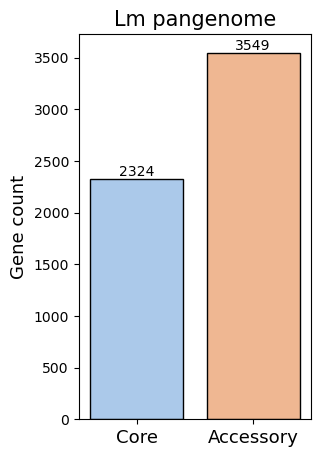

In [5]:
# Barplot of core and accessory genome
overall_pan_counts = overall_pan['cat'].value_counts()
overall_pan_percent = overall_pan['cat'].value_counts(normalize=True) * 100

# Convert to DataFrame for plotting
overall_pan_counts_df = overall_pan_counts.reset_index()
overall_pan_counts_df.columns = ['Category', 'Count']

# Sort categories to ensure "Core" is on the left
overall_pan_counts_df['Category'] = pd.Categorical(
    overall_pan_counts_df['Category'],
    categories=['Core', 'Accessory'],  # Define desired order
    ordered=True
)
overall_pan_counts_df = overall_pan_counts_df.sort_values('Category')

# Add percentages to the DataFrame for annotation
#overall_pan_counts_df['Percentage'] = overall_pan_counts_df['Category'].map(overall_pan_percent)

# Plotting
plt.rcParams["figure.figsize"] = (3, 5)

sns.barplot(
    data=overall_pan_counts_df,
    x="Category",
    y="Count",
    palette=sns.color_palette("pastel"),
    edgecolor="black",
)

# Add titles and labels
plt.title("Lm pangenome", fontsize=15)
plt.xticks(fontsize=13, rotation=0, ha="center")
plt.xlabel("")
plt.ylabel("Gene count", fontsize=13)

# Annotating the bars with values only
for p, value in zip(plt.gca().patches, overall_pan_counts_df['Count']):
    plt.annotate(
        f"{value}",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center',
        xytext=(0, 5),
        textcoords='offset points'
    )

plt.savefig(out_path_supp + "fig_s1a_Lm_core_acess.pdf", bbox_inches="tight", dpi=300)
plt.show()

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_single_box_with_swarm(data, y, title="", ylab=None, figsize=(4, 6), 
                               color="#52BE80", boxplot_kwargs=None, swarm_kwargs=None, 
                               out_path="", file_name=""):
    """
    Plots a single box plot with a swarm plot overlay.

    Parameters:
    - data (DataFrame): The data to plot.
    - y (str): The name of the column in 'data' for the y-axis values.
    - title (str): Title of the plot.
    - ylab (str): Label for the y-axis. If None, defaults to the column name.
    - figsize (tuple): Size of the figure.
    - color (str): Color for the box plot and swarm plot.
    - boxplot_kwargs (dict): Additional keyword arguments for the box plot.
    - swarm_kwargs (dict): Additional keyword arguments for the swarm plot.
    - out_path (str): Path to save the output figure.
    - file_name (str): Custom file name for the saved plot. If empty, the title will be used.
    """

    # Default boxplot appearance if no additional arguments are given
    if boxplot_kwargs is None:
        boxplot_kwargs = {
            'boxprops': {'edgecolor': 'k', 'linewidth': 2.5, 'facecolor': 'white'},
            'medianprops': {'color': 'k', 'linewidth': 2.5},
            'whiskerprops': {'color': 'k', 'linewidth': 2.5},
            'capprops': {'color': 'k', 'linewidth': 2.5},
            'width': 0.5
        }

    # Default swarmplot appearance if no additional arguments are given
    if swarm_kwargs is None:
        swarm_kwargs = {
            'size': 5,
            'edgecolor': 'k',
            'linewidth': 0.5
        }

    # Remove rows where the y-values are NaN
    data = data.dropna(subset=[y])

    # Ensure there is data left to plot after filtering
    if data.empty:
        print(f"No data to plot for {title} after filtering out NaN rows.")
        return

    # Set figure size
    plt.figure(figsize=figsize)

    # Plot the boxplot
    sns.boxplot(data=data, y=y, color=color, showfliers=False, **boxplot_kwargs)

    # Overlay the swarmplot
    sns.swarmplot(data=data, y=y, color=color, **swarm_kwargs)

    # Customize plot appearance
    plt.title(title, fontsize=15)
    plt.xticks([])  # Remove x-axis labels for a single boxplot
    plt.ylabel(ylab if ylab else y, fontsize=15)  # Use custom ylab or default to column name
    plt.tight_layout()

    # Determine the file name for saving
    save_file_name = file_name if file_name else title.replace('/', '_').replace('\\', '_')

    # Save the plot to the specified path
    if out_path:
        plt.savefig(f"{out_path}{save_file_name}.pdf", format='pdf', dpi=600)

    # Show the plot
    plt.show()

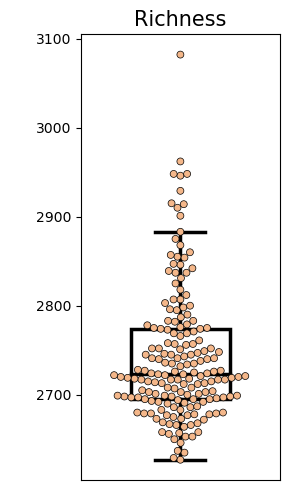

In [7]:
gen_pre_abs_t = gen_pre_abs.transpose()
gen_pre_abs_t["richness"] = gen_pre_abs_t.sum(axis=1)

plot_single_box_with_swarm(
    data=gen_pre_abs_t,
    y="richness",
    title="Richness",
    file_name="fig_s1b_richness",
    figsize=(3, 5),
    ylab=" ",
    out_path=out_path_supp,
    color="#F4B78A"
)

In [8]:
print(gen_pre_abs_t['richness'].min())
print(gen_pre_abs_t['richness'].max())

2627
3082


## Fig. 1 | Pangenome plasticity of _Lm_ is associated with abiotic factors.

### Fig. 1a Variation partitioning analysis (VPA) showing the variation of gene richness explained by geolocation, soil properties, climate, and surrounding land use.

In [9]:
# VPA for abiotic environmental variables and gene richness 
%load_ext rpy2.ipython

In [10]:
%R -i env_phyla_cog_rich

R[write to console]: Loading required package: permute

R[write to console]: Loading required package: lattice

R[write to console]: This is vegan 2.6-4



── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
png 
  2 


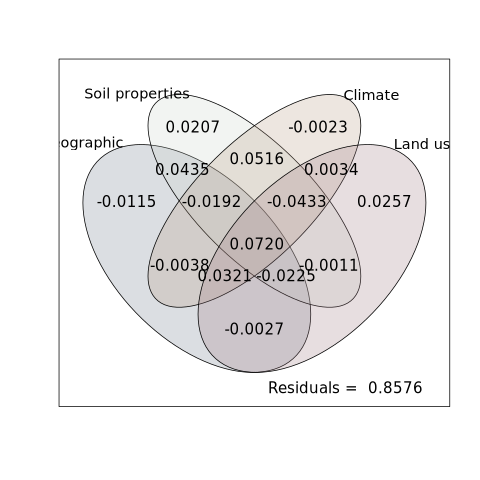

In [11]:
%%R

library(vegan)
library(tidyverse)

# Define the environmental variable list
env_list_all <- list(
  Geographic = env_phyla_cog_rich[, c(3:5)],
  Soil = env_phyla_cog_rich[, c(6:22)],
  Climate = env_phyla_cog_rich[, c(23:26)],
  `Land Use` = env_phyla_cog_rich[, c(27:36)]
)

# Define the richness variable
richness_all <- list(
  Richness = env_phyla_cog_rich[, c(64)]
)

# Function to perform variation partitioning
VarPart <- function(richness_all, env_list_all, out_path) {
  title <- file.path(out_path, 'fig_1a_env_richness_vpa.pdf')
  pdf(title, width = 5, height = 5, pointsize = 8)

  # Perform the analysis on the specified variables
  plot(
    varpart(
      richness_all$Richness,
      env_list_all$Geographic,
      env_list_all$Soil,
      env_list_all$Climate,
      env_list_all$`Land Use`
    ),
    digits = 2,
    cutoff = -Inf,
    Xnames = c('Geographic', 'Soil properties', 'Climate', 'Land use'),
    bg = c("#6D7A8A", "#CCD3CA", "#B89C85", "#9F7C84"),
    cex = 1.25 # Adjust font size
  )
    
  title(main = 'VPA for gene richness')
  dev.off()
}

# Perform the analysis on the specified variables
  plot(
    varpart(
      richness_all$Richness,
      env_list_all$Geographic,
      env_list_all$Soil,
      env_list_all$Climate,
      env_list_all$`Land Use`
    ),
    digits = 2,
    cutoff = -Inf,
    Xnames = c('Geographic', 'Soil properties', 'Climate', 'Land use'),
    bg = c("#6D7A8A", "#CCD3CA", "#B89C85", "#9F7C84"),
    cex = 1.25 # Adjust font size
  )

# Call the function for partitioning
out_path_1 <- "/projects/leaph/yingxian/lm_lineage_4va/out_2/fig_1/"
VarPart(richness_all, env_list_all, out_path_1)

#### Permutation test

In [12]:
df_env_sub = pd.read_csv(data_path_lm + "fig_1_vpa/1a_env_vpa.csv", index_col=0)
df_shannon = pd.read_csv(data_path_lm + "fig_1_vpa/1a_richness_vpa.csv", index_col=0)

In [13]:
%R -i df_env_sub
%R -i df_shannon

In [14]:
%%R

library(vegan)
library(tidyverse)

# Define the environmental variable list
env_list_all <- list(
  Geo = df_env_sub[, c(1:3)],
  Soil = df_env_sub[, c(4:20)],
  Climate = df_env_sub[, c(21:24)],
  Landuse = df_env_sub[, c(25:34)]
)

# Define the richness variable
richness_all <- list(
  Richness = df_shannon[, c(1)]
)

# Function to perform variation partitioning and extract residual R^2
VarPart <- function(richness_all, env_list_all) {
  # Perform variation partitioning (VPA)
  response <- varpart(
    richness_all$Richness,
    env_list_all$Geo,
    env_list_all$Soil,
    env_list_all$Climate,
    env_list_all$Landuse
  )
  
  # Extract the residual R^2 (adjusted R^2)
  residual_r2 <- response$part$indfract$Adj.R.square[[length(response$part$indfract$Adj.R.square)]]
  
  # Calculate explained variance
  explained_variance <- 1 - residual_r2
  
  # Return residual R^2 and explained variance
  return(c(residual_r2 = residual_r2, explained_variance = explained_variance))
}

# Observed results
observed_results <- VarPart(richness_all, env_list_all)

# Function to shuffle rows in df_shannon and compute VPA residual R^2
compute_shuffled_r2 <- function(df_env_sub, df_shannon) {
  # Shuffle the rows of df_shannon
  shuffled_shannon <- df_shannon
  shuffled_shannon[] <- lapply(shuffled_shannon, sample)  # Shuffle each column independently
  
  # Recompute the richness list
  shuffled_richness_all <- list(
    Richness = shuffled_shannon[, c(1)]
  )
  
  # Compute residual R^2 for shuffled data
  response <- varpart(
    shuffled_richness_all$Richness,
    env_list_all$Geo,
    env_list_all$Soil,
    env_list_all$Climate,
    env_list_all$Landuse
  )
  
  residual_r2 <- response$part$indfract$Adj.R.square[[length(response$part$indfract$Adj.R.square)]]
  explained_variance <- 1 - residual_r2
  
  return(c(residual_r2 = residual_r2, explained_variance = explained_variance))
}

# Function to perform 100 simulations and conduct one-tailed tests
run_simulations <- function(df_env_sub, df_shannon, observed_results, n_simulations = 100) {
  simulation_results <- data.frame(
    simulation = 1:n_simulations,
    residual_r2 = numeric(n_simulations),
    explained_variance = numeric(n_simulations),
    stringsAsFactors = FALSE
  )
  
  # Simulations
  for (i in 1:n_simulations) {
    result <- compute_shuffled_r2(df_env_sub, df_shannon)
    simulation_results$residual_r2[i] <- result["residual_r2"]
    simulation_results$explained_variance[i] <- result["explained_variance"]
  }
  
  # Observed explained variance
  observed_explained_variance <- observed_results["explained_variance"]
  
  # One-tailed p-value calculation
  p_value_higher <- mean(simulation_results$explained_variance >= observed_explained_variance)
  p_value_lower <- mean(simulation_results$explained_variance <= observed_explained_variance)
  
  # Save results
  simulation_results_metadata <- data.frame(
    observed_explained_variance = observed_explained_variance,
    P_val_higher = p_value_higher,
    P_val_lower = p_value_lower
  )
  
  # Define the output path
  out_path_vpa <- "/projects/leaph/yingxian/lm_lineage_4va/out_2/fig_1/vpa_permute/"
  
  # Save results
  write.csv(simulation_results, file = paste0(out_path_vpa, "1a_simulation_results.csv"), row.names = FALSE)
  write.csv(simulation_results_metadata, file = paste0(out_path_vpa, "1a_simulation_metadata.csv"), row.names = FALSE)
  
  return(list(simulation_results = simulation_results, metadata = simulation_results_metadata))
}

# Run simulations
results <- run_simulations(df_env_sub, df_shannon, observed_results, n_simulations = 100)

### Fig. 1b Variation of gene richness for Clusters of Orthologous Genes (COGs) explained by abiotic factors in VPA.

In [15]:
df_env_sub = pd.read_csv(data_path_lm + "fig_1_vpa/1b_env_vpa.csv", index_col=0)
df_shannon = pd.read_csv(data_path_lm + "fig_1_vpa/1b_shannon_VPA.csv", index_col=0)

In [16]:
%R -i df_env_sub
%R -i df_shannon

In [17]:
%%R

library(vegan)
library(tidyverse)

out_path_vpa <- "/projects/leaph/yingxian/lm_lineage_4va/out_2/fig_1/vpa_permute/"

VarPart_val <- function(env_ls, shannon_ls){
  adjr2_ls <- list()
  for (shannon in names(shannon_ls)){
    response <- varpart(shannon_ls[[shannon]], env_ls$Geo, env_ls$Soil, env_ls$Climate, env_ls$Landuse)
    adjr2 <- response$part$indfract$Adj.R.square[[length(response$part$indfract$Adj.R.square)]]
    adjr2_ls[[shannon]] <- adjr2
  }
  df <- as.data.frame(adjr2_ls)
  return(df)  # Ensure the function explicitly returns the data frame
}

VarPart_plot <- function(env_ls, shannon_ls, shannon_colors = NULL){
  for (shannon in names(shannon_ls)){
    response <- varpart(shannon_ls[[shannon]], env_ls$Geo, env_ls$Soil, env_ls$Climate, env_ls$Landuse)
    pdf(paste0(out_path_vpa, shannon, "_cog_env_vpa.pdf"), width=5, height=5)
    plot(response, digits=2, Xnames = c('Geo', 'Soil', 'Climate', 'Landuse'), bg = c('grey'))
    title(main = shannon)
    dev.off()
  }
}

repeat_varpart <- function(r, k, df_env_sub, df_shannon, output_csv) {
  # Repeat the random selection `r` times
  dfs <- replicate(r, {
    # Randomly select k indices
    random_indices <- sample(nrow(df_env_sub), k)
    env_ls <- list(
      Geo = df_env_sub[random_indices, c(1:3)],
      Soil = df_env_sub[random_indices, c(4:20)],
      Climate = df_env_sub[random_indices, c(21:24)],
      Landuse = df_env_sub[random_indices, c(25:34)]
    )
    shannon_ls <- as.list(df_shannon[random_indices, ])
    df <- VarPart_val(env_ls, shannon_ls)
    return(list(env_ls = env_ls, shannon_ls = shannon_ls, df = df))
  }, simplify = FALSE)
  
  # Extract results from the last iteration
  last_iteration <- dfs[[r]]
  observed_df <- last_iteration$df
  
  # Ensure that the COG column names are the same as those in df_shannon
  cog_names <- colnames(df_shannon)
  
  # Reshape the data to include 'COG', 'Observed_R2', and 'Explained_variance'
  observed_r2 <- data.frame(
    COG = cog_names,
    Observed_R2 = as.numeric(unlist(observed_df)),
    Explained_var = 1 - as.numeric(unlist(observed_df))
  )
  
  # Write the simplified CSV file
  write.csv(observed_r2, output_csv, row.names = FALSE)
  
  # Return the last iteration's env_ls and shannon_ls for plotting
  return(last_iteration)
}

# Run the analysis
results <- repeat_varpart(1, 167, df_env_sub, df_shannon, "cog_env_residuals.csv")

# Extract env_ls and shannon_ls from the last iteration's results for plotting
env_ls <- results$env_ls
shannon_ls <- results$shannon_ls

# Generate plots based on the last iteration's results
VarPart_plot(env_ls, shannon_ls, out_path_vpa)

#### Shuffle the data for each COGs independently and repeat for VPA, correct the _P_-value using BH-FDR method

In [18]:
%%R

library(vegan)
library(tidyverse)

# Define the output path
output_path <- "/projects/leaph/yingxian/lm_lineage_4va/out_2/fig_1/vpa_permute/"

# Part 1: Simulate the results and store them in 1b_simulation_results.csv
simulate_varpart <- function(df_env_sub, df_shannon, n_shuffles = 100) {
  # Initialize the results list
  all_simulation_results <- list()

  # Loop over each COG
  for (cog in colnames(df_shannon)) {
    residual_r2_values <- numeric(n_shuffles)  # Store residual R² values for each shuffle

    for (i in 1:n_shuffles) {
      # Shuffle the COG data
      shuffled_shannon <- df_shannon
      shuffled_shannon[[cog]] <- sample(shuffled_shannon[[cog]])

      # Calculate the adjusted R² (residual R²) using VarPart_val
      env_ls <- list(
        Geo = df_env_sub[, c(1:3)],
        Soil = df_env_sub[, c(4:20)],
        Climate = df_env_sub[, c(21:24)],
        Landuse = df_env_sub[, c(25:34)]
      )
      shannon_ls <- as.list(shuffled_shannon)

      adj_r2_df <- VarPart_val(env_ls, shannon_ls)
      residual_r2_values[i] <- adj_r2_df[[cog]]  # Store the calculated residual R² value
    }

    # Store the simulation results for the current COG
    simulation_results <- data.frame(
      COG = cog,
      simulation = 1:n_shuffles,
      residual_r2 = residual_r2_values,
      explained_variance = 1 - residual_r2_values
    )
    all_simulation_results[[cog]] <- simulation_results
  }

  # Combine all simulation results into one data frame
  combined_simulation_results <- do.call(rbind, all_simulation_results)

  # Write the combined results to a CSV
  write.csv(combined_simulation_results, file = paste0(output_path, "1b_simulation_results.csv"), row.names = FALSE)

  return(combined_simulation_results)
}

# Run simulation and get results
simulation_results <- simulate_varpart(df_env_sub, df_shannon, n_shuffles = 100)

# Part 2: Calculate the one-tailed p-values and apply FDR correction
calculate_p_values <- function(df_env_sub, df_shannon, simulation_results) {
  metadata_accum <- data.frame(
    COG = character(),
    Observed_R2 = numeric(),
    Explained_Variance = numeric(),
    P_r2_higher = numeric(),
    P_r2_lower = numeric(),
    P_var_exp_higher = numeric(),
    P_var_exp_lower = numeric(),
    stringsAsFactors = FALSE
  )

  for (cog in colnames(df_shannon)) {
    env_ls <- list(
      Geo = df_env_sub[, c(1:3)],
      Soil = df_env_sub[, c(4:20)],
      Climate = df_env_sub[, c(21:24)],
      Landuse = df_env_sub[, c(25:34)]
    )
    shannon_ls <- as.list(df_shannon)

    adj_r2_df <- VarPart_val(env_ls, shannon_ls)
    observed_r2 <- adj_r2_df[[cog]]
    observed_explained_variance <- 1 - observed_r2

    residual_r2_values <- simulation_results[simulation_results$COG == cog, "residual_r2"]
    explained_variance_values <- 1 - residual_r2_values

    p_r2_higher <- mean(residual_r2_values >= observed_r2, na.rm = TRUE)
    p_r2_lower <- mean(residual_r2_values <= observed_r2, na.rm = TRUE)
    p_var_exp_higher <- mean(explained_variance_values >= observed_explained_variance, na.rm = TRUE)
    p_var_exp_lower <- mean(explained_variance_values <= observed_explained_variance, na.rm = TRUE)

    metadata_accum <- rbind(metadata_accum, data.frame(
      COG = cog,
      Observed_R2 = observed_r2,
      Explained_Variance = observed_explained_variance,
      P_r2_higher = p_r2_higher,
      P_r2_lower = p_r2_lower,
      P_var_exp_higher = p_var_exp_higher,
      P_var_exp_lower = p_var_exp_lower
    ))
  }

  # Apply FDR correction to p-values
  metadata_accum$P_r2_higher_FDR <- p.adjust(metadata_accum$P_r2_higher, method = "BH")
  metadata_accum$P_r2_lower_FDR <- p.adjust(metadata_accum$P_r2_lower, method = "BH")
  metadata_accum$P_var_exp_higher_FDR <- p.adjust(metadata_accum$P_var_exp_higher, method = "BH")
  metadata_accum$P_var_exp_lower_FDR <- p.adjust(metadata_accum$P_var_exp_lower, method = "BH")

  # Write the results to a CSV file
  write.csv(metadata_accum, file = paste0(output_path, "1b_metadata_cog_results_with_fdr.csv"), row.names = FALSE)

  return(metadata_accum)
}

# Run p-value calculation
metadata_df <- calculate_p_values(df_env_sub, df_shannon, simulation_results)

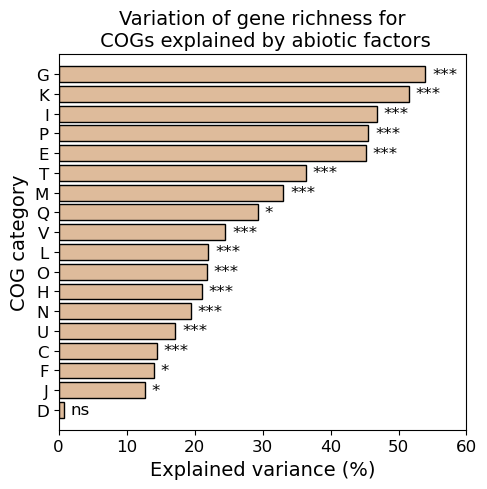

In [19]:
# Barplot for variance explained and their P-vals
env_cog_permute = pd.read_csv(data_path_lm + "metadata_env_cog_results_with_fdr.csv", index_col=False)
env_cog_permute = env_cog_permute[['COG', 'Explained_Variance', 'P_var_exp_higher_FDR', 'P_var_exp_lower_FDR']]

# Create a new column 'P-val' with the relevant values or 'NS' if none are < 0.05
env_cog_permute['FDR-P-val'] = np.where(
    env_cog_permute['P_var_exp_higher_FDR'] < 0.05,
    env_cog_permute['P_var_exp_higher_FDR'],
    np.where(env_cog_permute['P_var_exp_lower_FDR'] < 0.05, env_cog_permute['P_var_exp_lower_FDR'], 'NS')
)

# Create a new column 'than_null' with 'higher', 'lower', or 'NS'
env_cog_permute['than_null'] = np.where(
    env_cog_permute['P_var_exp_higher_FDR'] < 0.05,
    'higher',
    np.where(env_cog_permute['P_var_exp_lower_FDR'] < 0.05, 'lower', 'NS')
)

env_cog_permute = env_cog_permute[['COG', 'Explained_Variance', 'FDR-P-val', 'than_null']]

# Sorting the proportions in descending order
env_cog_permute_sorted = env_cog_permute.sort_values(by='Explained_Variance', ascending=True)
env_cog_permute_sorted = env_cog_permute_sorted[~env_cog_permute_sorted['COG'].isin(['S', 'W'])]

# Convert Explained_Variance to percentages
env_cog_permute_sorted['Explained_Variance'] *= 100

# Create asterisks based on FDR-P-val
env_cog_permute_sorted['FDR-P-val'] = pd.to_numeric(env_cog_permute_sorted['FDR-P-val'], errors='coerce')
env_cog_permute_sorted['FDR-P-val'] = env_cog_permute_sorted['FDR-P-val'].fillna('NS')

def get_asterisks(p_val):
    if p_val == 'NS':
        return 'ns'
    elif p_val < 0.001:
        return '***'
    elif p_val < 0.01:
        return '**'
    elif p_val < 0.05:
        return '*'
    else:
        return '' 

env_cog_permute_sorted['Asterisks'] = env_cog_permute_sorted['FDR-P-val'].apply(get_asterisks)

# Define a color mapping based on 'than_null' column
color_mapping = {
    'higher': '#DEBB9B',  
    'lower': '#f39c12',   
    'NS': '#DEBB9B'
}

# Map colors to the 'than_null' column
bar_colors = env_cog_permute_sorted['than_null'].map(color_mapping)

# Plotting the horizontal bar chart
plt.figure(figsize=(5, 5))
bars = plt.barh(
    env_cog_permute_sorted['COG'], 
    env_cog_permute_sorted['Explained_Variance'], 
    color=bar_colors,
    edgecolor='#000000'
)

# Adding the asterisks at the end of the respective bars
for bar, label in zip(bars, env_cog_permute_sorted['Asterisks']):
    if label: 
        plt.text(
            bar.get_width() + 1, 
            bar.get_y() + bar.get_height() / 2,
            label, 
            va='center', 
            ha='left', 
            fontsize=12, 
            color='black'
        )

# Customize labels and title
plt.xlabel('Explained variance (%)', fontsize=14)
plt.ylabel('COG category', fontsize=14)
plt.title('Variation of gene richness for\n COGs explained by abiotic factors', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.xlim(0, 60)  # Adjust x-axis limit based on your data
plt.ylim(-1, len(env_cog_permute_sorted))

# Save the figure
plt.savefig(out_path_1 + 'fig_1b_cog_env_var_exp.pdf', bbox_inches='tight', dpi=600)
plt.show()

In [20]:
# Define abiotic, phyla, and richness columns

abiotic_columns = [
    'Latitude', 'Longitude', 'Elevation (m)', 'Moisture', 'Total nitrogen (%)', 'Total carbon (%)',
    'pH', 'Organic matter (%)', 'Aluminum (mg/Kg)', 'Calcium (mg/Kg)', 'Copper (mg/Kg)', 'Iron (mg/Kg)',
    'Potassium (mg/Kg)', 'Magnesium (mg/Kg)', 'Manganese (mg/Kg)', 'Molybdenum (mg/Kg)', 'Sodium (mg/Kg)',
    'Phosphorus (mg/Kg)', 'Sulfur (mg/Kg)', 'Zinc (mg/Kg)', 'Precipitation (mm)', 'Max temperature (C)',
    'Min temperature (C)', 'Wind speed (m/s)', 'Open water (%)', 'Developed (< 20% Impervious) (%)',
    'Developed (> 20% Impervious) (%)', 'Barren (%)', 'Forest (%)', 'Shrubland (%)', 'Grassland (%)',
    'Cropland (%)', 'Pasture (%)', 'Wetland (%)'
]

phyla_columns = [
    'AD3', 'Acidobacteria', 'Actinobacteria', 'Armatimonadetes', 'BHI80-139', 'BRC1', 'Bacteroidetes',
    'Chlamydiae', 'Chlorobi', 'Chloroflexi', 'Cyanobacteria', 'Elusimicrobia', 'FCPU426', 'Fibrobacteres',
    'Firmicutes', 'GAL15', 'Gemmatimonadetes', 'Nitrospirae', 'Planctomycetes', 'Proteobacteria', 'TM6',
    'TM7', 'Verrucomicrobia', 'WPS-2', 'WS2', 'WS3', '[Thermi]'
]

all_var_columns = abiotic_columns + phyla_columns

richness_columns = [
    'Overall', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'S', 'T', 'U', 'V', 'W'
]


In [21]:
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Compute Spearman correlation and adjust p-values
def compute_spearman_correlation(env_df, richness_df, abiotic_columns, richness_columns):
    corr_results = []
    for abiotic_col in abiotic_columns:
        for richness_col in richness_columns:
            if richness_col != "Isolate_ID":
                corr, pval = spearmanr(env_df[abiotic_col], richness_df[richness_col])
                corr_results.append([abiotic_col, richness_col, corr, pval])
    
    corr_df = pd.DataFrame(corr_results, columns=["Abiotic", "Richness", "spearmanr_coefficient", "pvalue"])
    
    # Adjust p-values using FDR
    _, fdr_adjusted_pvalues, _, _ = multipletests(corr_df["pvalue"], method="fdr_bh")
    corr_df["fdr_adjusted_pvalue"] = fdr_adjusted_pvalues
    
    # Assign significance levels
    conditions = [
        corr_df["fdr_adjusted_pvalue"] < 0.001,
        corr_df["fdr_adjusted_pvalue"] < 0.01,
        corr_df["fdr_adjusted_pvalue"] < 0.05,
        corr_df["fdr_adjusted_pvalue"] >= 0.05,
    ]
    choices = ["***", "**", "*", " "]
    corr_df["asterisk"] = np.select(conditions, choices, default="ns")
    
    return corr_df

# Create pivot tables for heatmap
def prepare_pivot_tables(corr_df):
    # Spearman correlation coefficients
    pivot_corr = corr_df.pivot(index="Abiotic", columns="Richness", values="spearmanr_coefficient")
    
    # Significance asterisks
    pivot_asterisks = corr_df.pivot(index="Abiotic", columns="Richness", values="asterisk")
    
    return pivot_corr, pivot_asterisks

# Plot heatmap
def plot_heatmap(pivot_corr, pivot_asterisks, title, output_path=None, cmap="PuOr", vmin=-1, vmax=1, figsize=(14, 10)):
    """
    Plot a heatmap for the Spearman correlation results with significance annotations.

    Parameters:
    - pivot_corr: DataFrame containing the Spearman correlation coefficients.
    - pivot_asterisks: DataFrame containing significance level annotations.
    - title: Title of the heatmap.
    - output_path: Path to save the heatmap. If None, the plot is not saved.
    - cmap: Colormap for the heatmap.
    - vmin: Minimum value for the color scale.
    - vmax: Maximum value for the color scale.
    - figsize: Tuple specifying the figure size (width, height).
    """
    plt.figure(figsize=figsize)
    ax = sns.heatmap(
        pivot_corr,
        annot=pivot_asterisks,
        annot_kws={"size": 10},
        fmt="",
        cmap=cmap,
        center=0,
        cbar_kws={"label": "Spearman coefficient", "pad": 0.02, "shrink": 1, "aspect": 40},  # Adjust aspect for the colorbar
        vmin=vmin,
        vmax=vmax,
    )
    cbar = ax.collections[0].colorbar
    cbar.ax.yaxis.label.set_size(16)
    cbar.ax.tick_params(labelsize=16)
    
    plt.title(title, fontsize=18)
    plt.xticks(rotation=0, ha="center", fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, bbox_inches="tight", dpi=300)
    plt.show()

### Fig. 1c Spearman’s correlation between abiotic factors and gene richness, overall and for significant COGs identified in VPA.

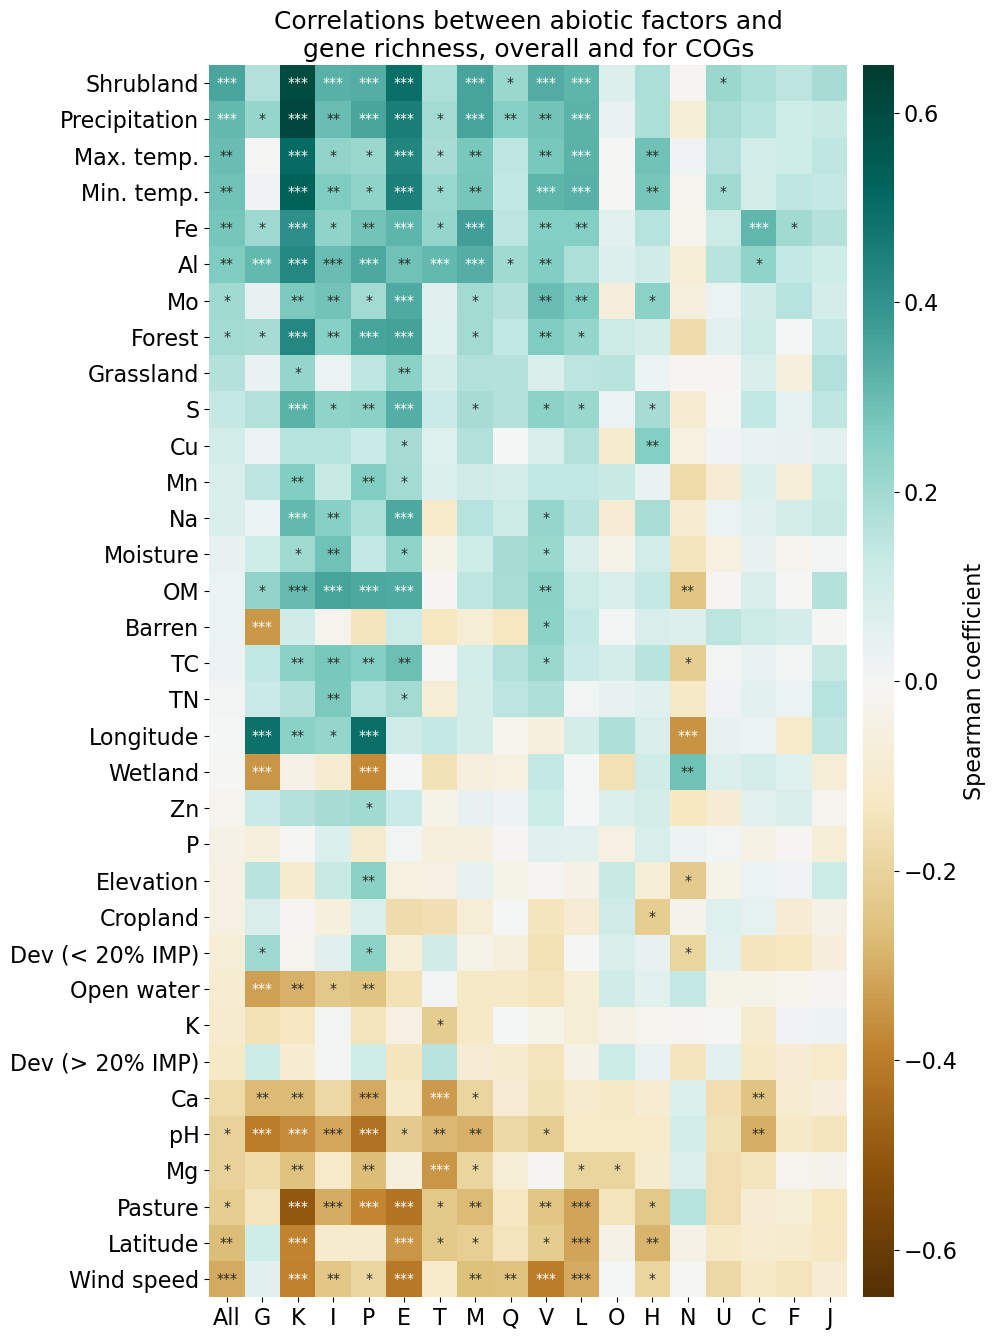

In [22]:
import pandas as pd

# Compute correlation between abiotic variables and COG gene richness
corr_df = compute_spearman_correlation(env_phyla_cog_rich, env_phyla_cog_rich, abiotic_columns, richness_columns)

# Prepare pivot tables
pivot_corr, pivot_asterisks = prepare_pivot_tables(corr_df)

# Order COG categories by variance explained
vpa_order = ['Overall', 'G', 'K', 'I', 'P', 'E', 'T', 'M', 'Q', 'V', 'L', 'O', 'H', 'N', 'U', 'C', 'F', 'J', 'S', 'W', 'D']
pivot_corr, pivot_asterisks = pivot_corr[vpa_order], pivot_asterisks[vpa_order]
pivot_corr = pivot_corr.rename(columns={'Overall': 'All'})
pivot_asterisks = pivot_asterisks.rename(columns={'Overall': 'All'})

# Keep top 10 COGs (drop 'S', 'W', 'D')
pivot_corr_sel, pivot_asterisks_sel = pivot_corr.drop(columns=['S', 'W', 'D']), pivot_asterisks.drop(columns=['S', 'W', 'D'])

# Define and apply desired abiotic variable order
abiotic_order = [
    'Latitude', 'Longitude', 'Elevation (m)', 'Moisture', 'Total nitrogen (%)', 'Total carbon (%)', 'pH', 
    'Organic matter (%)', 'Aluminum (mg/Kg)', 'Calcium (mg/Kg)', 'Copper (mg/Kg)', 'Iron (mg/Kg)',
    'Potassium (mg/Kg)', 'Magnesium (mg/Kg)', 'Manganese (mg/Kg)', 'Molybdenum (mg/Kg)', 'Sodium (mg/Kg)',
    'Phosphorus (mg/Kg)', 'Sulfur (mg/Kg)', 'Zinc (mg/Kg)', 'Precipitation (mm)', 'Max temperature (C)',
    'Min temperature (C)', 'Wind speed (m/s)', 'Open water (%)', 'Developed (< 20% Impervious) (%)',
    'Developed (> 20% Impervious) (%)', 'Barren (%)', 'Forest (%)', 'Shrubland (%)', 'Grassland (%)',
    'Cropland (%)', 'Pasture (%)', 'Wetland (%)'
]

pivot_corr_sel, pivot_asterisks_sel = pivot_corr_sel.reindex(abiotic_order), pivot_asterisks_sel.reindex(abiotic_order)

# Define renaming dictionary
rename_dict = {
    'Total nitrogen (%)': 'TN', 'Total carbon (%)': 'TC', 'Elevation (m)': 'Elevation',
    'Organic matter (%)': 'OM', 'Aluminum (mg/Kg)': 'Al', 'Calcium (mg/Kg)': 'Ca', 'Copper (mg/Kg)': 'Cu', 'Iron (mg/Kg)': 'Fe',
    'Potassium (mg/Kg)': 'K', 'Magnesium (mg/Kg)': 'Mg', 'Manganese (mg/Kg)': 'Mn', 'Molybdenum (mg/Kg)': 'Mo', 'Sodium (mg/Kg)': 'Na',
    'Phosphorus (mg/Kg)': 'P', 'Sulfur (mg/Kg)': 'S', 'Zinc (mg/Kg)': 'Zn', 'Precipitation (mm)': 'Precipitation', 'Max temperature (C)': 'Max. temp.',
    'Min temperature (C)': 'Min. temp.', 'Wind speed (m/s)': 'Wind speed', 'Open water (%)': 'Open water', 'Developed (< 20% Impervious) (%)': 'Dev (< 20% IMP)',
    'Developed (> 20% Impervious) (%)': 'Dev (> 20% IMP)', 'Barren (%)': 'Barren', 'Forest (%)': 'Forest', 'Shrubland (%)': 'Shrubland', 'Grassland (%)': 'Grassland',
    'Cropland (%)': 'Cropland', 'Pasture (%)': 'Pasture', 'Wetland (%)': 'Wetland'
}

# Apply renaming
pivot_corr_sel.rename(index=rename_dict, inplace=True)
pivot_asterisks_sel.rename(index=rename_dict, inplace=True)

# Sort abiotic factors based on 'All' column
sorted_index = pivot_corr_sel['All'].sort_values(ascending=False).index

# Reindex both correlation and asterisk tables
pivot_corr_sel = pivot_corr_sel.reindex(sorted_index)
pivot_asterisks_sel = pivot_asterisks_sel.reindex(sorted_index)

plot_heatmap(
    pivot_corr_sel, pivot_asterisks_sel,
    title="Correlations between abiotic factors and\ngene richness, overall and for COGs",
    output_path=out_path_1 + "fig_1c_spearmancorr_abiotic_vpa.pdf",
    cmap="BrBG", vmin=-0.65, vmax=0.65, figsize=(10, 13.5)
)

### Fig. S2 Frequency of abiotic environmental factors significantly correlated with gene richness for COGs, sorted in descending order

In [23]:
# Function to count cells with asterisks in each column or row
def count_asterisks(data, axis=0):
    return data.astype(str).apply(lambda x: x.str.contains(r'\*', regex=True)).sum(axis=axis)

In [24]:
columns_to_drop = ['All', 'S', 'W', 'D'] 
pivot_corr_3 = pivot_corr.drop(columns=columns_to_drop)
pivot_asterisks_3 = pivot_asterisks.drop(columns=columns_to_drop)

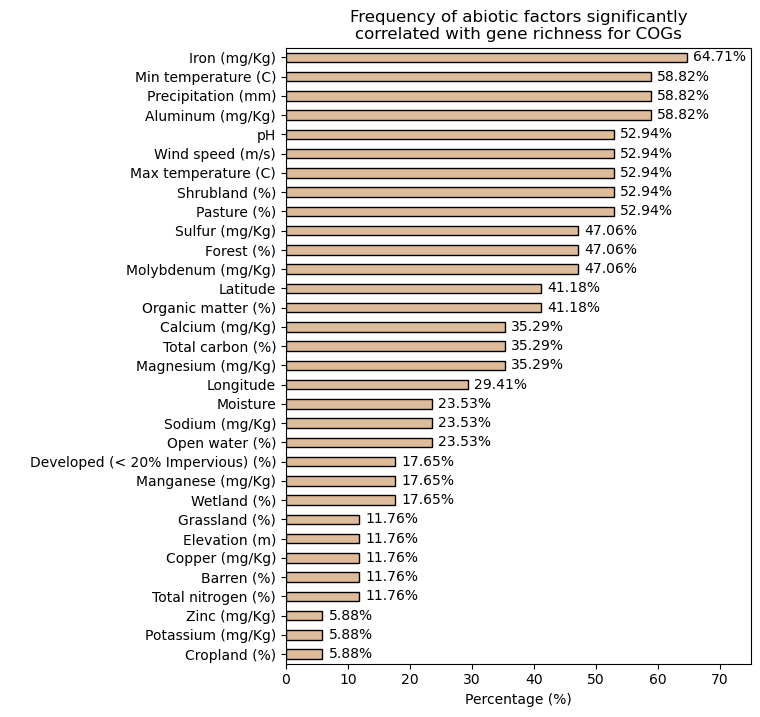

In [25]:
# Count asterisks for each row
asterisk_counts_rows = count_asterisks(pivot_asterisks_3, axis=1)

import pandas as pd
import matplotlib.pyplot as plt

total_rows = pivot_asterisks_3.shape[1]
asterisk_counts_rows = pivot_asterisks_3.astype(str).apply(lambda x: x.str.contains(r'\*', regex=True)).sum(axis=1)
asterisk_percentage_rows = (asterisk_counts_rows / total_rows) * 100
asterisk_percentage_rows_sorted = asterisk_percentage_rows.sort_values(ascending=True)

# Filter out rows with 0% before sorting
asterisk_percentage_rows_filtered = asterisk_percentage_rows[asterisk_percentage_rows > 0]
asterisk_percentage_rows_sorted = asterisk_percentage_rows_filtered.sort_values(ascending=True)

# Plotting the horizontal bar chart
plt.figure(figsize=(6, 8))
bars = asterisk_percentage_rows_sorted.plot(kind='barh', color='#DEBB9B', edgecolor='#000000')
plt.xlabel('Percentage (%)')
plt.ylabel(' ')
plt.title('Frequency of abiotic factors significantly\ncorrelated with gene richness for COGs')

# Setting x-axis limits
plt.xlim(0, 75)  # Since it's a percentage, the max limit is 100

# Adding percentage values at the end of the bars
for index, value in enumerate(asterisk_percentage_rows_sorted):
    plt.text(value + 1, index, f'{value:.2f}%', va='center', ha='left', color='black')

# Save the figure
plt.savefig(out_path_supp + 'fig_s2_env_sig_spearman_prop.pdf', bbox_inches='tight', dpi=600)
plt.show()

In [26]:
from statannotations.Annotator import Annotator
import seaborn as sns
import matplotlib.pyplot as plt
import os

def plot_2_box_with_swarm_and_mw(
    data, 
    x, 
    y, 
    group1, 
    group2, 
    title="", 
    out_path="./", 
    output_file_name=None, 
    figsize=(4, 6), 
    boxplot_kwargs=None, 
    ylabel="Y-axis Label",
    xlabel="X-axis Label",
    swarm_colors=None  # Define separate colors for the swarm plot
):
    """
    Plots a combined box plot with statistical annotations and swarm plot.

    Parameters:
    - data (DataFrame): The data to plot.
    - x (str): The name of the column in 'data' to be used as x-axis groups.
    - y (str): The name of the column in 'data' for the y-axis values.
    - group1 (str): The name of the first group to compare.
    - group2 (str): The name of the second group to compare.
    - title (str): Title of the plot.
    - out_path (str): The output directory for saving the plot.
    - output_file_name (str): Custom file name for the output file (optional).
    - figsize (tuple): Size of the figure.
    - boxplot_kwargs (dict): Additional keyword arguments for the box plot.
    - ylabel (str): Label for the y-axis.
    - xlabel (str): Label for the x-axis.
    - swarm_colors (list): List of two colors for the swarm points of group1 and group2.
    """

    # Default boxplot appearance if no additional arguments are given
    if boxplot_kwargs is None:
        boxplot_kwargs = {
            "boxprops": {"edgecolor": "k", "linewidth": 2.5},
            "medianprops": {"color": "k", "linewidth": 2.5},
            "whiskerprops": {"color": "k", "linewidth": 2.5},
            "capprops": {"color": "k", "linewidth": 2.5},
            "width": 0.5,
        }

    # Default swarm plot colors if none are provided
    if swarm_colors is None:
        swarm_colors = ["#1f77b4", "#ff7f0e"]  # Default colors: blue for group1, orange for group2

    # Ensure data is not empty
    data = data.dropna(subset=[y])
    if data.empty:
        print(f"No data to plot for {title} after filtering out NaN rows.")
        return

    # Set figure size
    plt.rcParams["figure.figsize"] = figsize

    # Create figure and axis for plotting
    fig, ax = plt.subplots()

    # Plot the boxplot without specific colors
    sns.boxplot(
        data=data,
        x=x,
        y=y,
        order=[group1, group2],
        ax=ax,
        **boxplot_kwargs,
        showfliers=False
    )

    # Plot swarm plots with different colors for each group
    for i, group in enumerate([group1, group2]):
        sns.swarmplot(
            data=data[data[x] == group],  # Filter data for the current group
            x=x,
            y=y,
            ax=ax,
            color=swarm_colors[i],
            order=[group1, group2]
        )

    # Add statistical annotations
    box_pairs = [(group1, group2)]
    annotator = Annotator(ax, box_pairs, data=data, x=x, y=y, order=[group1, group2])
    annotator.configure(
        test="Mann-Whitney",
        text_format="full",
        comparisons_correction=None,
        loc="inside",
        verbose=2,
        pvalue_format_string="{:.2g}",
    )

    try:
        annotator.apply_and_annotate()
    except ValueError as e:
        print(f"Error in statistical annotation for {title}: {e}")

    # Customize plot appearance
    plt.xticks(ticks=[0, 1], labels=[group1.capitalize(), group2.capitalize()], size=12)
    plt.ylabel(ylabel, size=12)
    plt.xlabel(xlabel, size=12)
    plt.title(title, size=14)
    plt.tight_layout()

    # Generate output file name
    if output_file_name is None:
        output_file_name = f"{title.strip().replace(' ', '_').replace(':', '').replace('/', '_')}.pdf"

    # Combine output path and file name
    output_file = os.path.join(out_path, output_file_name)

    # Save the plot to the specified path
    plt.savefig(output_file, format="pdf", dpi=300)
    plt.show()

In [27]:
from statannotations.Annotator import Annotator
import seaborn as sns
import matplotlib.pyplot as plt
import os

def plot_2_box_with_mw(
    data, 
    x, 
    y, 
    group1, 
    group2, 
    title="", 
    out_path="./", 
    output_file_name=None, 
    figsize=(4, 6), 
    boxplot_kwargs=None, 
    ylabel="Y-axis Label",
    xlabel="X-axis Label", 
    box_colors=None  # Define separate colors for the boxplot
):
    """
    Plots a box plot with statistical annotations.

    Parameters:
    - data (DataFrame): The data to plot.
    - x (str): The name of the column in 'data' to be used as x-axis groups.
    - y (str): The name of the column in 'data' for the y-axis values.
    - group1 (str): The name of the first group to compare.
    - group2 (str): The name of the second group to compare.
    - title (str): Title of the plot.
    - out_path (str): The output directory for saving the plot.
    - output_file_name (str): Custom file name for the output file (optional).
    - figsize (tuple): Size of the figure.
    - boxplot_kwargs (dict): Additional keyword arguments for the box plot.
    - ylabel (str): Label for the y-axis.
    - xlabel (str): Label for the x-axis.
    - box_colors (list): List of two colors for the boxplot of group1 and group2.
    """

    # Default boxplot appearance if no additional arguments are given
    if boxplot_kwargs is None:
        boxplot_kwargs = {
            "boxprops": {"edgecolor": "k", "linewidth": 2.5},
            "medianprops": {"color": "k", "linewidth": 2.5},
            "whiskerprops": {"color": "k", "linewidth": 2.5},
            "capprops": {"color": "k", "linewidth": 2.5},
            "width": 0.5,
        }

    # Default boxplot colors if none are provided
    if box_colors is None:
        box_colors = ["#1f77b4", "#ff7f0e"]  # Default colors: blue for group1, orange for group2

    # Ensure data is not empty
    data = data.dropna(subset=[y])
    if data.empty:
        print(f"No data to plot for {title} after filtering out NaN rows.")
        return

    # Set figure size
    plt.rcParams["figure.figsize"] = figsize

    # Create figure and axis for plotting
    fig, ax = plt.subplots()

    # Plot the boxplot with different colors for each group
    sns.boxplot(
        data=data,
        x=x,
        y=y,
        order=[group1, group2],
        ax=ax,
        **boxplot_kwargs,
        showfliers=False,
        palette=box_colors  # Set the color palette for the boxplot
    )

    # Add statistical annotations
    box_pairs = [(group1, group2)]
    annotator = Annotator(ax, box_pairs, data=data, x=x, y=y, order=[group1, group2])
    annotator.configure(
        test="Mann-Whitney",
        text_format="full",
        comparisons_correction=None,
        loc="inside",
        verbose=2,
        pvalue_format_string="{:.2g}",
    )

    try:
        annotator.apply_and_annotate()
    except ValueError as e:
        print(f"Error in statistical annotation for {title}: {e}")

    # Customize plot appearance
    plt.xticks(ticks=[0, 1], labels=[group1.capitalize(), group2.capitalize()], size=12)
    plt.ylabel(ylabel, size=12)
    plt.xlabel(xlabel, size=12)
    plt.title(title, size=14)
    plt.tight_layout()

    # Generate output file name
    if output_file_name is None:
        output_file_name = f"{title.strip().replace(' ', '_').replace(':', '').replace('/', '_')}.pdf"

    # Combine output path and file name
    output_file = os.path.join(out_path, output_file_name)

    # Save the plot to the specified path
    plt.savefig(output_file, format="pdf", dpi=300)
    plt.show()


#### Detrended correspondence analysis (DCA)

In [28]:
# Load input data - isolate metadata
isolate = pd.read_csv(data_path + "Listeria_genomes.csv", index_col=0)

# renaming L1, L2, L3 to LM lineage III, LM lineage II, LM lineage I respectively
rename_mapping = {
    "L1": "III",
    "L2": "II",
    "L3": "I",
}
isolate["Phylogroup"] = isolate["Phylogroup"].apply(lambda x: rename_mapping.get(x, x))

# Filtering for L. monocytogenes
lm_isolate = isolate[isolate["Species"] == "L. monocytogenes"]
lm_isolate = lm_isolate.set_index('Isolate ID')

lm_1 = list(lm_isolate[lm_isolate["Phylogroup"] == "I"].index)
lm_2 = list(lm_isolate[lm_isolate["Phylogroup"] == "II"].index)
lm_3 = list(lm_isolate[lm_isolate["Phylogroup"] == "III"].index)
lm_all = lm_isolate.index.tolist()

# Load input data - pre/abs matrix
gen_pre_abs = pd.read_csv(data_path + "gene_pre_abs_lm.csv", index_col=0)
gen_pre_abs = gen_pre_abs.transpose()
gen_pre_abs = gen_pre_abs.rename_axis('Isolate ID')

# Reset index and select relevant columns from lm_isolate
lm_sample = lm_isolate.reset_index()
lm_sample = lm_sample[['Isolate ID', 'Sample ID']]

# Load environmental data
env = pd.read_csv(data_path + 'environ_all.csv', index_col=0)
env = env.dropna()

# Merge with lm_sample
env_isolate = lm_sample.merge(env, left_on='Sample ID', right_index=True, how='left', suffixes=('', '_env'))

# Set 'Isolate ID' as the index and drop 'Sample ID' column
env_isolate.set_index('Isolate ID', inplace=True)
env_isolate.drop(columns=['Sample ID'], inplace=True)

# Drop rows with NaN values
env_isolate = env_isolate.dropna()

# Drop rows not present in either gen_pre_abs or env_isolate
common_index = gen_pre_abs.index.intersection(env_isolate.index)
gen_pre_abs_env = gen_pre_abs.loc[common_index]
env_isolate = env_isolate.loc[common_index]

# Remove title for index
env_isolate.index.name = None
env_isolate.columns.name = None
gen_pre_abs_env.index.name = None
gen_pre_abs_env.columns.name = None

# Drop columns that consist only zeros in 'gen_pre_abs' df
column_totals = gen_pre_abs_env.sum(axis=0)

## Identify columns with a total of 0
columns_with_zero_total = column_totals[column_totals == 0].index

# Drop the columns that consist only of zeros
gen_pre_abs_env = gen_pre_abs_env.drop(columns=columns_with_zero_total)

# Export DataFrame to CSV
gen_pre_abs_env.to_csv(data_path_lm + 'gen_pre_abs_env.csv', index=True)
env_isolate.to_csv(data_path_lm + 'env_isolate.csv', index=True)

# Merge the two dataframes based on the index of gen_pre_abs
merged_df = gen_pre_abs_env.merge(env_isolate, left_index=True, right_index=True)

print(env_isolate.shape)
print(gen_pre_abs_env.shape)

(169, 34)
(169, 5818)


In [29]:
# Scale the environmental variables before performing DCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit and transform the DataFrame
scaled_env = pd.DataFrame(scaler.fit_transform(env_isolate), 
                          columns=env_isolate.columns,
                          index=env_isolate.index)

In [30]:
# Perform detrended correspondence analysis (DCA) to determine RDA or CCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri, r
from rpy2.robjects.conversion import localconverter

# Import required R packages
vegan = importr('vegan')

# Convert pandas DataFrames to R dataframes
with localconverter(pandas2ri.converter):
    r_gen_pre_abs = pandas2ri.py2rpy(gen_pre_abs_env)
    r_scaled_env_variables = pandas2ri.py2rpy(scaled_env)

# Perform DCA
dca_result = vegan.decorana(r_gen_pre_abs)

# Extract isolate scores (row projection)
isolate_scores = pd.DataFrame(np.array(dca_result.rx2('rproj')),
                           index=gen_pre_abs_env.index, 
                           columns=['DCA1', 'DCA2', 'DCA3', 'DCA4'])

# Extract gene scores (column projections)
gene_scores = pd.DataFrame(np.array(dca_result.rx2('cproj')),
                              index=gen_pre_abs_env.columns, 
                              columns=['DCA1', 'DCA2', 'DCA3', 'DCA4'])

# Calculate eigenvectors
eigenvalues = np.array(dca_result.rx2('evals'))

# Project environmental variables onto DCA axes
env_fit = vegan.envfit(dca_result, r_scaled_env_variables)
env_vectors = pd.DataFrame(np.array(env_fit.rx2('vectors').rx2('arrows')), 
                           index=scaled_env.columns, 
                           columns=['DCA1', 'DCA2'])

# The length of the first DCA axis (DCA1)
length_dca1 = eigenvalues[0]
print(f"Length of the first DCA axis (DCA1): {length_dca1:.3f}")

# Length of the first DCA axis (DCA1): 0.025 - smaller than 3 s.d. - use RDA

Length of the first DCA axis (DCA1): 0.025


#### Feature selection for RDA using L1 regularization (Lasso)

In [31]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.preprocessing import StandardScaler, RobustScaler

# Scale data using RobustScaler - account for outliers, more robust
scaler = RobustScaler()
X = scaler.fit_transform(env_isolate)

# Perform L1 regularization (Lasso)
lasso = Lasso(alpha=0.1, max_iter=10000, tol=1e-3)
lasso_selector = lasso.fit(X, gen_pre_abs_env.sum(axis=1)) # Using gene richness as a proxy target
lasso_support = lasso_selector.coef_ != 0
lasso_features = env_isolate.columns[lasso_support]
#print("Lasso selected features:", lasso_features)

# Create a new dataframe with selected features
selected_env = env_isolate[list(lasso_features)]
selected_env = env_isolate.loc[:, lasso_features].copy()

# Rename the columns for later visualization
selected_env.rename(columns={
    'Total nitrogen (%)': 'TN', 
    'Total carbon (%)': 'TC', 
    'Organic matter (%)': 'OM', 
    'Aluminum (mg/Kg)': 'Al', 
    'Calcium (mg/Kg)': 'Ca', 
    'Copper (mg/Kg)': 'Cu', 
    'Iron (mg/Kg)': 'Fe', 
    'Magnesium (mg/Kg)': 'Mg', 
    'Manganese (mg/Kg)': 'Mn', 
    'Molybdenum (mg/Kg)': 'Mo', 
    'Sodium (mg/Kg)': 'Na',
    'Phosphorus (mg/Kg)': 'P', 
    'Sulfur (mg/Kg)': 'S', 
    'Zinc (mg/Kg)': 'Zn', 
    'Elevation (m)': 'Elevation', 
    'Min temperature (C)': 'Min. temp.',
    'Wind speed (m/s)': 'Wind speed', 
    'Precipitation (mm)': 'Precipitation', 
    'Open water (%)': 'Open water', 
    'Developed (< 20% Impervious) (%)': 'Dev (<20% PIMP)',
    'Developed (> 20% Impervious) (%)': 'Dev (>20% PIMP)', 
    'Barren (%)': 'Barren', 
    'Shrubland (%)': 'Shrubland',
    'Grassland (%)': 'Grassland', 
    'Cropland (%)': 'Cropland', 
    'Pasture (%)': 'Pasture',
    'Wetland (%)': 'Wetland'
}, inplace=True)

print(len(env_isolate.columns))
print(len(selected_env.columns))

34
31


### Fig. 1d Redundancy Analysis (RDA) biplot illustrating the relationships between the _Lm_ accessory genome and 31 abiotic variables selected by Lasso regularization.

In [32]:
# Performing RDA between environmental variables and pangenome
import pandas as pd
from skbio.stats.ordination import rda

# Perform RDA between selected environmental variables and pangenome
rda_result = rda(gen_pre_abs_env, selected_env, scale_Y=False, scaling=1)
RDA1 = rda_result.proportion_explained[0]
RDA2 = rda_result.proportion_explained[1]
total_explained = RDA1 + RDA2
print(f"Total Explained: {total_explained:.2%}")

Total Explained: 5.00%


In [33]:
# Extracting RDA axes 1 and 2 for machine learning
sample_scores = rda_result.samples

# Extract RDA1 and RDA2 scores
RDA1_scores = sample_scores.iloc[:, 0]  # First column for RDA1
RDA2_scores = sample_scores.iloc[:, 1]  # Second column for RDA2

# Combine RDA1 and RDA2 scores into a DataFrame if needed
rda_scores_df = sample_scores.loc[:, ['RDA1', 'RDA2']] = sample_scores.iloc[:, [0, 1]]

# Combine the data and export for ML 
env_isolate_rda = pd.merge(selected_env, rda_scores_df, left_index=True, right_index=True)
env_isolate_rda = env_isolate_rda.reset_index(drop=False)
env_isolate_rda = env_isolate_rda.rename(columns={'index': 'isolate_id'})
env_isolate_rda.to_csv(out_path_oth + "tab_1_env_isolate_rda_pangenome.csv", index=False)

In [34]:
import pandas as pd

# Load the data
gen_pre_abs_env = pd.read_csv(data_path_lm + "gen_pre_abs_env.csv", index_col=0)

# Rename L1, L2, L3 to LM lineage III, LM lineage II, LM lineage I respectively
rename_mapping = {
    'L1': 'III',
    'L2': 'II',
    'L3': 'I',
}
isolate['Phylogroup'] = isolate['Phylogroup'].apply(lambda x: rename_mapping.get(x, x))

# Filter for monocytogenes
monocytogenes_isolate = isolate[isolate['Species'] == 'L. monocytogenes']
monocytogenes_isolate = monocytogenes_isolate.reset_index()
monocytogenes_isolate = monocytogenes_isolate.set_index('Isolate ID')
monocytogenes_isolate = monocytogenes_isolate[monocytogenes_isolate['Phylogroup'].isin(['III', 'II', 'I'])]

# Merge with sample data
sample = gen_pre_abs_env.copy()
merged_df_2= pd.merge(sample, monocytogenes_isolate, left_index=True, right_index=True)

# Create lm_lineage and ensure it is a copy
lm_lineage = merged_df_2[['Phylogroup']].copy()
lm_lineage.rename(columns={'Phylogroup': 'Lineage'}, inplace=True)

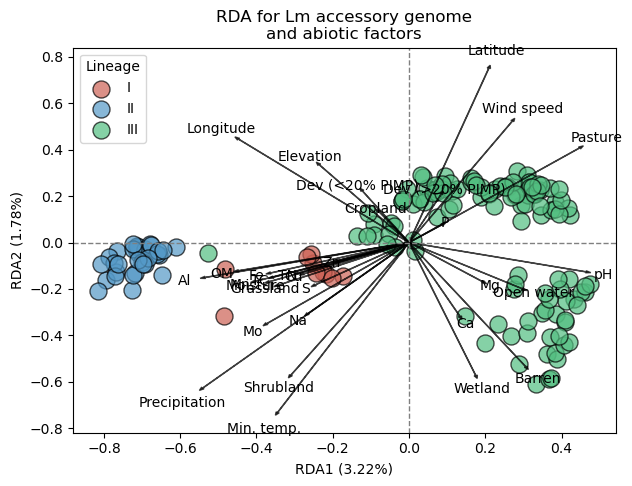

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define colors for each lm_lineage
#color_dict = {'I': '#b7950b', 'II': '#b7950b', 'III': '#b7950b'}
color_dict = {'I': '#CD6155', 'II': '#5499C7', 'III': '#52BE80'}

# Set up the plot
plt.figure(figsize=(7, 5))

# Plot the isolates
for group in color_dict.keys():
    sns.scatterplot(
        x=rda_result.samples.loc[lm_lineage['Lineage'] == group, 'RDA1'], 
        y=rda_result.samples.loc[lm_lineage['Lineage'] == group, 'RDA2'], 
        s=150, edgecolor='black', alpha=0.7, color=color_dict[group] , label=f'{group}'
    )

# Plot arrows for environmental variables
for i in range(rda_result.biplot_scores.shape[0]):
    plt.arrow(0, 0, rda_result.biplot_scores['RDA1'][i], rda_result.biplot_scores['RDA2'][i], 
              color='black', alpha=0.7, head_width=0.009)
    plt.text(rda_result.biplot_scores['RDA1'][i]*1.1, rda_result.biplot_scores['RDA2'][i]*1.1, 
             rda_result.biplot_scores.index[i], color='black', ha='center', va='center')
    
# Add labels and title
plt.xlabel(f"RDA1 ({rda_result.proportion_explained[0]:.2%})")
plt.ylabel(f"RDA2 ({rda_result.proportion_explained[1]:.2%})")
plt.title("RDA for Lm accessory genome\nand abiotic factors")
plt.axhline(0, color='grey', lw=1, linestyle='--')
plt.axvline(0, color='grey', lw=1, linestyle='--')

# Add legend
plt.legend(title='Lineage', loc='upper left')

# Show plot
plt.grid(False)
plt.savefig(out_path_1 + 'fig_1d_rda_env_pan.pdf', bbox_inches='tight', dpi=600)
plt.show()

#### Identification of abiotic-linked genes.

In [36]:
# Identifying abiotic-linked genes
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Load input data
gen_pre_abs_env = pd.read_csv(data_path_lm + "gen_pre_abs_env.csv", index_col=0)
env_isolate = pd.read_csv(data_path_lm + 'env_isolate.csv', index_col=0)

# Initialize an empty DataFrame to store the raw p-values
raw_pval = pd.DataFrame()

# Initialize an empty DataFrame to store significant results after FDR correction
fdr_corrected_results = pd.DataFrame()

# Iterate through each gene in sig_gen_pre_abs
for gene in gen_pre_abs_env.columns:
    present_rows = gen_pre_abs_env[gen_pre_abs_env[gene] == 1].index
    absent_rows = gen_pre_abs_env[gen_pre_abs_env[gene] == 0].index
    
    if len(present_rows) == 0 or len(absent_rows) == 0:
        # Skip this gene since one of the groups is empty (no variation)
        continue
    
    # Initialize lists to store Mann-Whitney test results
    u_values = []
    p_values = []
    
    # Iterate through each environmental variable in env_isolate
    for env in env_isolate.columns:
        # Get the environmental values for the present and absent groups
        present_env = env_isolate.loc[present_rows, env]
        absent_env = env_isolate.loc[absent_rows, env]
        
        # Perform Mann-Whitney U test
        u_statistic, p_value = mannwhitneyu(present_env, absent_env)
        
        # Append the results to the lists
        u_values.append(u_statistic)
        p_values.append(p_value)
    
    # Create a DataFrame to store the Mann-Whitney test results for each env_var
    mw_results = pd.DataFrame({
        'Gene': gene,
        'Env_var': env_isolate.columns,
        'U_Value': u_values,
        'P_Value': p_values
    })
    
    # Concatenate the raw p-values results
    raw_pval = pd.concat([raw_pval, mw_results])

# Perform False Discovery Rate (FDR) correction on the combined p-values
rejected, p_corrected, _, _ = multipletests(raw_pval['P_Value'], alpha=0.05, method='fdr_bh')

# Add the FDR-corrected p-values to the raw_pval DataFrame
raw_pval['FDR_Corrected_P_Value'] = p_corrected
raw_pval['Rejected'] = rejected

# Filter for significant results after FDR correction
fdr_adjusted_pval = raw_pval[raw_pval['Rejected']]

# Select columns for the FDR corrected results
fdr_adjusted_env_pval = fdr_adjusted_pval[['Gene', 'Env_var', 'U_Value', 'P_Value', 'FDR_Corrected_P_Value']]

# Reorder the raw_pval_results columns as per your requirement
raw_env_pval = raw_pval[['Gene', 'Env_var', 'U_Value', 'P_Value', 'FDR_Corrected_P_Value']]

# Sort significant_results based on 'FDR_Corrected_P_Value' column
fdr_adjusted_env_pval_sorted = fdr_adjusted_env_pval.sort_values(by='FDR_Corrected_P_Value')
fdr_adjusted_env_pval_sorted.to_csv(out_path_supp + 'tab_s1_all_env_all_gene.csv')

In [37]:
print(len(raw_env_pval))
print(len(fdr_adjusted_env_pval)) # number of significant association between abiotic factor and gene
print(len(fdr_adjusted_env_pval['Gene'].unique())) # number of unique genes involved

118592
5792
803


In [38]:
gen_pre_abs_env.shape

(169, 5818)

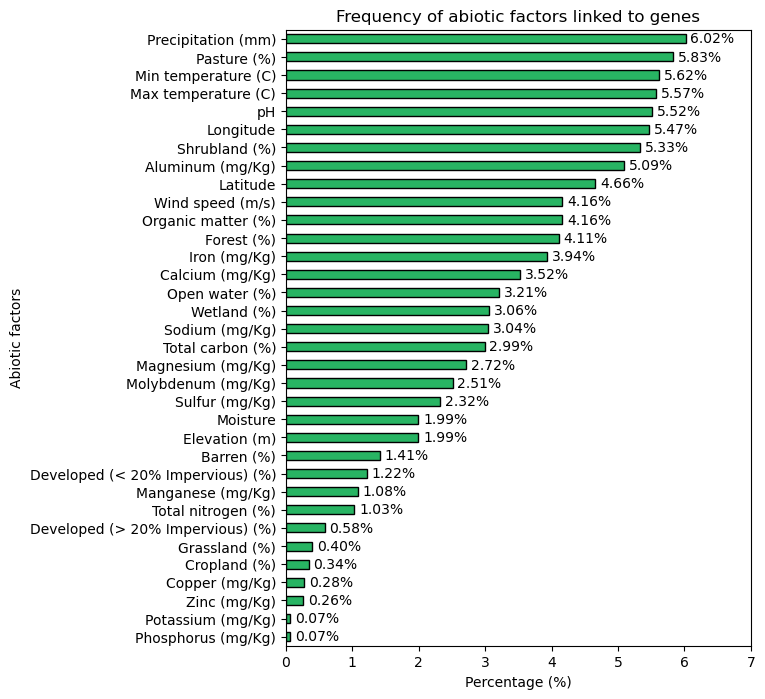

In [39]:
# Prevalence of environmental conditions correlated with genes
import pandas as pd
import matplotlib.pyplot as plt

gen_env = pd.read_csv(out_path_supp + 'tab_s1_all_env_all_gene.csv', index_col=0)
env_counts = gen_env['Env_var'].value_counts()
env_prop = (env_counts / 5818) * 100

# Sorting the proportions in descending order
env_prop_sorted = env_prop.sort_values(ascending=True)

# Plotting the horizontal bar chart
plt.figure(figsize=(6, 8))
bars = env_prop_sorted.plot(kind='barh', color='#28B463', edgecolor='#000000')
plt.xlabel('Percentage (%)')
plt.ylabel('Abiotic factors')
plt.title('Frequency of abiotic factors linked to genes')

# Setting x-axis limits
plt.xlim(0, 7)

# Adding percentage values at the end of the bars
for index, value in enumerate(env_prop_sorted):
    plt.text(value + 0.07, index, f'{value:.2f}%', va='center', ha='left', color='black')  # Adjust value - 2 as needed to move text

# Save the figure
plt.savefig(out_path_2 + 'fig_xxx_env_prop.pdf', bbox_inches='tight', dpi=600)
plt.show()

In [40]:
env_prop_mean = env_prop.mean()
env_prop = (env_counts / 5818) * 100

In [41]:
# Function to split rows

def split_rows(df, column):
    # Split the 'COG Functional Category' column and create a new DataFrame with exploded rows
    df_expanded = df[column].apply(lambda x: pd.Series(list(x))).stack().reset_index(level=1, drop=True).to_frame(column)
    
    # Merge the expanded 'COG Functional Category' with the rest of the DataFrame
    df_expanded = df_expanded.join(df.drop(columns=[column]), how='left')
    
    return df_expanded

### Fig. 1g Enrichment of COGs among abiotic-linked genes.

In [42]:
# Loading and preprocessing COG annotation file
gen_annot = pd.read_csv(data_path + "gene_func_annot.csv")
gen_annot.rename(columns={" COG Functional Category": "COG Functional Category"}, inplace=True)
gen_annot.rename(columns={" query_name": "query_name"}, inplace=True)
gen_annot = gen_annot[['query_name', 'COG Functional Category']]

# In gen_annot Replace '0' and Nan with 'S' - All 0, Nan and S are indicating 'Function unknown' 
gen_annot['COG Functional Category'] = gen_annot['COG Functional Category'].replace('0', 'S')
gen_annot['COG Functional Category'] = gen_annot['COG Functional Category'].fillna('S')

# Get the unique gene of the abiotic-linked genes from the 'Gene' column
unique_genes = fdr_adjusted_env_pval['Gene'].unique()

# Convert the unique values into a DataFrame with 'query_name' as the column name
gen_env_df = pd.DataFrame(unique_genes, columns=['query_name'])

# Set 'query_name' as the index of the DataFrame
gen_env_df.set_index('query_name', inplace=True)

# Merge gen_env_df with gen_annot using the 'query_name' index from gen_env_df
gen_env_annotated = gen_env_df.merge(gen_annot, left_index=True, right_on='query_name', how='left')

# Apply the function to split the rows - spliting genes (rows) that have >1 COG
gen_env_cog_split = split_rows(gen_env_annotated, 'COG Functional Category')

In [43]:
# Convert 'COG Functional Category' column to lists of individual characters
gen_env_annotated['COG Functional Category'] = gen_env_annotated['COG Functional Category'].apply(
    lambda x: [char.upper() for char in x if char.isalpha()])

# Create a long list of individual characters
cog_env_list = [char for sublist in gen_env_annotated['COG Functional Category'] for char in sublist]

# Count the occurrences of each character
cog_env_series = pd.Series(cog_env_list)
print(len(cog_env_series))

824


In [44]:
# Count occurrences of each unique COG from the overall dataframe (N)
gen_annot = gen_annot.set_index('query_name')
gen_pre_abs_env = pd.read_csv(data_path_lm + "gen_pre_abs_env.csv", index_col=0)
gen_pre_abs_env = gen_pre_abs_env.transpose()
cog = gen_pre_abs_env.merge(gen_annot, left_index=True, right_index=True, how='left')

# Apply the function to split the rows - spliting genes (rows) that have >1 COG
cog_split = split_rows(cog, 'COG Functional Category')

# calculate the expected proportion for each COG
prop_exp = cog_split['COG Functional Category'].value_counts(normalize=True).to_frame(name='Proportion')

# calculate the observed proportion for each significant COG
count_sig_env_cog = cog_env_series.value_counts(normalize=False).to_frame(name='Count')

In [45]:
# Function to perform enrichment analysis based on binomial distribution
def enrichment_analysis(obs_ct_df, exp_prop_df):
    i_dict = {}
    for index, row in obs_ct_df.iterrows():
        n = row['Count']
        p = exp_prop_df._get_value(index, 'Proportion')
        N = obs_ct_df['Count'].sum()
        i = (n - p * N)/np.sqrt(p * (1 - p) * N)
        i_dict[index] = i

    i_df = pd.DataFrame.from_dict(i_dict, orient='index',columns=['Enrichment index'])

    return i_df

In [46]:
# Perform the enrichment analysis
sig_env_cog_enrich = enrichment_analysis(count_sig_env_cog, prop_exp)

In [47]:
# Prepare the dataframe for bubble plot visualization
sig_env_cog_enrich_count = pd.merge(sig_env_cog_enrich, count_sig_env_cog, left_index = True, right_index = True)
sig_env_cog_enrich_count = sig_env_cog_enrich_count.reset_index(names=['COG functional category']).sort_values(by="Enrichment index", ascending=False)
sig_env_cog_enrich_count = sig_env_cog_enrich_count[sig_env_cog_enrich_count['COG functional category'] != 'S']

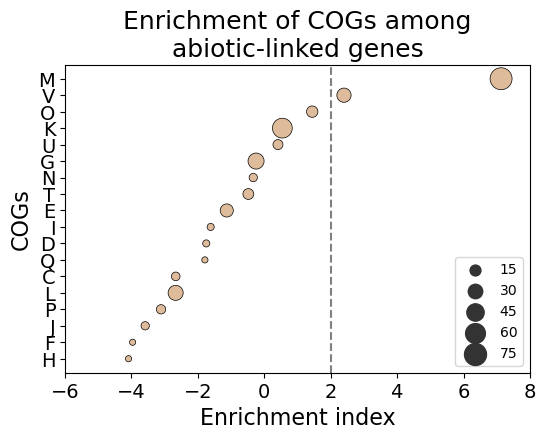

In [48]:
# Make a bubble plot
plt.rcParams["figure.figsize"] = (6, 4)

# Use a scatter plot with varying sizes and colors
bubble_plot = sns.scatterplot(
    data=sig_env_cog_enrich_count,
    x='Enrichment index',
    y='COG functional category',
    size='Count',
    color='#DEBB9B',
    sizes=(20, 250),  # Adjust the range of bubble sizes
    alpha=1,
    edgecolor='black',
    linewidth=0.5,
)

#plt.axvline(x=-2, color='grey', linestyle='--')
plt.axvline(x=2, color='grey', linestyle='--')
plt.title('Enrichment of COGs among\nabiotic-linked genes', size = 18)
plt.xlabel('Enrichment index', size = 16)
plt.ylabel('COGs', size = 16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(loc="lower right", bbox_to_anchor=(1, 0))
plt.xlim(-6,8)

plt.savefig(out_path_1 + 'fig_1f_enrich.pdf', bbox_inches='tight', dpi=600)
plt.show()

In [49]:
# Loop through based on environmental variables and do functional enrichment analysis
# Load input, renaming abiotic varaibles and annotating COG of the input
import re

fdr_adjusted_env_pval_sorted = pd.read_csv(out_path_supp + "tab_s1_all_env_all_gene.csv", index_col=0)
cog_abiotic = fdr_adjusted_env_pval_sorted.merge(gen_annot, left_on='Gene', right_index=True, how='left')

def rename_env_var(item):
    if item in ['Developed (< 20% Impervious) (%)', 'Developed (> 20% Impervious) (%)']:
        return item
    return re.sub(r"\s*\(.*?\)", "", item)

cog_abiotic['Env_var'] = cog_abiotic['Env_var'].apply(rename_env_var)

rename = {
    'Developed (< 20% Impervious) (%)': 'Dev (<20% PIMP)',
    'Developed (> 20% Impervious) (%)': 'Dev (>20% PIMP)',
}

# Apply the renaming
cog_abiotic['Env_var'] = cog_abiotic['Env_var'].replace(rename)

## Fig 2 | Pangenome plasticity of _Lm_ is associated with bacterial community composition

### Fig. 2a VPA showing the variation of gene richness explained by abiotic and biotic factors

In [50]:
%R -i env_phyla_cog_rich

png 
  2 


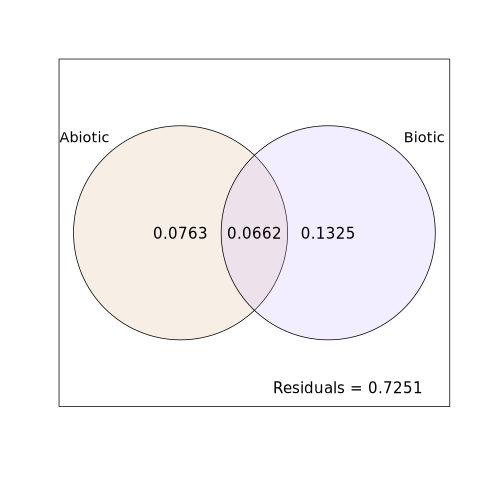

In [51]:
%%R

library(vegan)
library(tidyverse)

# Define the environmental variable list
env_list_all <- list(
  Abiotic = env_phyla_cog_rich[, c(3:36)],
  Biotic = env_phyla_cog_rich[, c(37:63)]
)

# Define the richness variable
richness_all <- list(
  Richness = env_phyla_cog_rich[, c(64)]
)

# Function to perform variation partitioning
VarPart <- function(richness_all, env_list_all, out_path) {
  title <- file.path(out_path, 'fig_2a_env_richness_vpa.pdf')
  pdf(title, width = 4, height = 4, pointsize = 8)

  # Perform the analysis on the specified variables
  plot(
    varpart(
      richness_all$Richness,
      env_list_all$Abiotic,
      env_list_all$Biotic
    ),
    digits = 3,
    Xnames = c('Abiotic', 'Biotic'),
    bg = c('#DEBB9B', '#D0BBFF'),
    cex = 1.25 # Adjust font size
  )
    
  title(main = 'VPA for gene richness')
  dev.off()
}

  plot(
    varpart(
      richness_all$Richness,
      env_list_all$Abiotic,
      env_list_all$Biotic
    ),
    digits = 3,
    Xnames = c('Abiotic', 'Biotic'),
    bg = c('#DEBB9B', '#D0BBFF'),
    cex = 1.25 # Adjust font size
  )

# Call the function for partitioning
out_path_2 <- "/projects/leaph/yingxian/lm_lineage_4va/out_2/fig_2/"
VarPart(richness_all, env_list_all, out_path_2)

#### Permutation test

In [52]:
df_env_sub = pd.read_csv(data_path_lm + "fig_2_vpa/2a_env_phyla_vpa.csv", index_col=0)
df_shannon = pd.read_csv(data_path_lm + "fig_2_vpa/2a_richness_vpa.csv", index_col=0)

In [53]:
%R -i df_env_sub
%R -i df_shannon

In [54]:
%%R

library(vegan)
library(tidyverse)

# Define the environmental variable list
env_list_all <- list(
  Abiotic = df_env_sub[, c(1:34)],
  Biotic = df_env_sub[, c(35:61)]
)

# Define the richness variable
richness_all <- list(
  Richness = df_shannon[, c(1)]
)

# Function to perform variation partitioning and extract residual R^2
VarPart <- function(richness_all, env_list_all) {
  # Perform variation partitioning (VPA)
  response <- varpart(
    richness_all$Richness,
    env_list_all$Abiotic,
    env_list_all$Biotic
  )
  
  # Extract the residual R^2 (adjusted R^2)
  residual_r2 <- response$part$indfract$Adj.R.square[[length(response$part$indfract$Adj.R.square)]]
  
  # Calculate explained variance
  explained_variance <- 1 - residual_r2
  
  # Return residual R^2 and explained variance
  return(c(residual_r2 = residual_r2, explained_variance = explained_variance))
}

# Observed results
observed_results <- VarPart(richness_all, env_list_all)

# Function to shuffle rows in df_shannon and compute VPA residual R^2
compute_shuffled_r2 <- function(df_env_sub, df_shannon) {
  # Shuffle the rows of df_shannon
  shuffled_shannon <- df_shannon
  shuffled_shannon[] <- lapply(shuffled_shannon, sample)  # Shuffle each column independently
  
  # Recompute the richness list
  shuffled_richness_all <- list(
    Richness = shuffled_shannon[, c(1)]
  )
  
  # Compute residual R^2 for shuffled data
  response <- varpart(
    shuffled_richness_all$Richness,
    env_list_all$Abiotic,
    env_list_all$Biotic
  )
  
  residual_r2 <- response$part$indfract$Adj.R.square[[length(response$part$indfract$Adj.R.square)]]
  explained_variance <- 1 - residual_r2
  
  return(c(residual_r2 = residual_r2, explained_variance = explained_variance))
}

# Function to perform 100 simulations and conduct one-tailed tests
run_simulations <- function(df_env_sub, df_shannon, observed_results, n_simulations = 100) {
  simulation_results <- data.frame(
    simulation = 1:n_simulations,
    residual_r2 = numeric(n_simulations),
    explained_variance = numeric(n_simulations),
    stringsAsFactors = FALSE
  )
  
  # Simulations
  for (i in 1:n_simulations) {
    result <- compute_shuffled_r2(df_env_sub, df_shannon)
    simulation_results$residual_r2[i] <- result["residual_r2"]
    simulation_results$explained_variance[i] <- result["explained_variance"]
  }
  
  # Observed explained variance
  observed_explained_variance <- observed_results["explained_variance"]
  
  # One-tailed p-value calculation
  p_value_higher <- mean(simulation_results$explained_variance >= observed_explained_variance)
  p_value_lower <- mean(simulation_results$explained_variance <= observed_explained_variance)
  
  # Save results
  simulation_results_metadata <- data.frame(
    observed_explained_variance = observed_explained_variance,
    P_val_higher = p_value_higher,
    P_val_lower = p_value_lower
  )
  
  # Define the output path
  out_path_vpa <- "/projects/leaph/yingxian/lm_lineage_4va/out_2/fig_2/vpa_permute/"
  
  # Save results
  write.csv(simulation_results, file = paste0(out_path_vpa, "2a_simulation_results.csv"), row.names = FALSE)
  write.csv(simulation_results_metadata, file = paste0(out_path_vpa, "2a_simulation_metadata.csv"), row.names = FALSE)
  
  return(list(simulation_results = simulation_results, metadata = simulation_results_metadata))
}

# Run simulations
results <- run_simulations(df_env_sub, df_shannon, observed_results, n_simulations = 100)

### Fig. 2b Variation of gene richness for COGs explained by abiotic and biotic factors in VPA.

In [55]:
df_env_sub = pd.read_csv(data_path_lm + "fig_2_vpa/2b_env_phyla_vpa.csv", index_col=0)
df_shannon = pd.read_csv(data_path_lm + "fig_2_vpa/2b_shannon_VPA.csv", index_col=0)

In [56]:
%R -i df_env_sub
%R -i df_shannon

In [57]:
%%R

library(vegan)
library(tidyverse)

# Define output path
out_path_vpa <- "/projects/leaph/yingxian/lm_lineage_4va/out_2/fig_2/vpa_permute/"

# Function to compute adjusted R²
VarPart_val <- function(env_ls, shannon_ls){
  adjr2_ls <- list()
  for (shannon in names(shannon_ls)){
    response <- varpart(shannon_ls[[shannon]], env_ls$Abiotic, env_ls$Biotic)
    adjr2 <- response$part$indfract$Adj.R.square[[length(response$part$indfract$Adj.R.square)]]
    adjr2_ls[[shannon]] <- adjr2
  }
  df <- as.data.frame(adjr2_ls)
  return(df)  # Explicit return is good practice
}

# Function to generate VPA plot
VarPart_plot <- function(env_ls, shannon_ls, out_path_vpa, shannon_colors = NULL){
  for (shannon in names(shannon_ls)){
    response <- varpart(shannon_ls[[shannon]], env_ls$Abiotic, env_ls$Biotic)
    
    # Define file path using paste0()
    file_path <- paste0(out_path_vpa, shannon, "_cog_env_vpa.pdf")
    pdf(file = file_path, width = 5, height = 5)
    
    plot(response, digits = 3, Xnames = c('Abiotic', 'Biotic'), bg = c('#DEBB9B', '#D0BBFF'))
    title(main = shannon)
    
    dev.off()  # Close the PDF device properly
  }
}

# Function to repeat the VPA simulation
repeat_varpart <- function(r, k, df_env_sub, df_shannon, output_csv) {
  # Repeat the random selection `r` times
  dfs <- replicate(r, {
    # Randomly select k indices
    random_indices <- sample(nrow(df_env_sub), k)
    
    env_ls <- list(
      Abiotic = df_env_sub[random_indices, c(1:34)],
      Biotic = df_env_sub[random_indices, c(35:61)]
    )
    
    shannon_ls <- as.list(df_shannon[random_indices, ])
    df <- VarPart_val(env_ls, shannon_ls)
    
    return(list(env_ls = env_ls, shannon_ls = shannon_ls, df = df))
  }, simplify = FALSE)
  
  # Extract results from the last iteration
  last_iteration <- dfs[[r]]
  observed_df <- last_iteration$df
  
  # Ensure that the COG column names are the same as those in df_shannon
  cog_names <- colnames(df_shannon)
  
  # Reshape the data to include 'COG', 'Observed_R2', and 'Explained_variance'
  observed_r2 <- data.frame(
    COG = cog_names,
    Observed_R2 = as.numeric(unlist(observed_df)),
    Explained_var = 1 - as.numeric(unlist(observed_df))
  )
  
  # Write the simplified CSV file to the specified path
  write.csv(observed_r2, file = output_csv, row.names = FALSE)
  
  # Return the last iteration's env_ls and shannon_ls for plotting
  return(last_iteration)
}

# Run the analysis
results <- repeat_varpart(
  r = 1, 
  k = 167, 
  df_env_sub = df_env_sub, 
  df_shannon = df_shannon, 
  output_csv = file.path(out_path_vpa, "2b_cog_abio_bio_residuals.csv")
)

# Extract env_ls and shannon_ls from the last iteration's results for plotting
env_ls <- results$env_ls
shannon_ls <- results$shannon_ls

# Generate plots based on the last iteration's results
VarPart_plot(env_ls, shannon_ls, out_path_vpa)

#### Shuffle the data for each COG independently and repeat for VPA, correct the _P_-value using BH-FDR method

In [58]:
%%R

library(vegan)
library(tidyverse)

# Define the output path
output_path <- "/projects/leaph/yingxian/lm_lineage_4va/out_2/fig_2/vpa_permute/"

# Part 1: Simulate the results and store them in 2b_simulation_results.csv
simulate_varpart <- function(df_env_sub, df_shannon, n_shuffles = 100) {
  all_simulation_results <- list()
  
  # Loop over each COG
  for (cog in colnames(df_shannon)) {
    residual_r2_values <- numeric(n_shuffles)
    
    for (i in 1:n_shuffles) {
      # Shuffle the COG data correctly
      shuffled_shannon <- df_shannon
      shuffled_shannon[[cog]] <- sample(shuffled_shannon[[cog]])

      # Define environmental variables and Shannon values as lists
      env_ls <- list(
        Abiotic = df_env_sub[, c(1:34)],
        Biotic = df_env_sub[, c(35:61)]
      )
      shannon_ls <- as.list(shuffled_shannon)

      # Get the adjusted R² value
      adj_r2_df <- VarPart_val(env_ls, shannon_ls)
      residual_r2_values[i] <- adj_r2_df[[1, cog]] # Access the correct element
    }

    # Store simulation results for the current COG
    simulation_results <- data.frame(
      COG = cog,
      simulation = 1:n_shuffles,
      residual_r2 = residual_r2_values,
      explained_variance = 1 - residual_r2_values
    )
    all_simulation_results[[cog]] <- simulation_results
  }
  
  # Combine all simulation results into one data frame
  combined_simulation_results <- bind_rows(all_simulation_results)

  # Write results to CSV using file.path for better compatibility
  write.csv(combined_simulation_results, file = file.path(output_path, "2b_simulation_results.csv"), row.names = FALSE)
  
  return(combined_simulation_results)
}

# Run simulation and get results
simulation_results <- simulate_varpart(df_env_sub, df_shannon, n_shuffles = 100)

# Part 2: Calculate the one-tailed p-values and apply FDR correction
calculate_p_values <- function(df_env_sub, df_shannon, simulation_results) {
  metadata_accum <- data.frame(
    COG = character(),
    Observed_R2 = numeric(),
    Explained_Variance = numeric(),
    P_r2_higher = numeric(),
    P_r2_lower = numeric(),
    P_var_exp_higher = numeric(),
    P_var_exp_lower = numeric(),
    stringsAsFactors = FALSE
  )

  for (cog in colnames(df_shannon)) {
    # Define environmental variables and Shannon values as lists
    env_ls <- list(
      Abiotic = df_env_sub[, c(1:34)],
      Biotic = df_env_sub[, c(35:61)]
    )
    shannon_ls <- as.list(df_shannon)

    # Get adjusted R² values
    adj_r2_df <- VarPart_val(env_ls, shannon_ls)
    observed_r2 <- adj_r2_df[[1, cog]]
    observed_explained_variance <- 1 - observed_r2

    # Extract simulation results for current COG
    residual_r2_values <- simulation_results %>%
      filter(COG == cog) %>%
      pull(residual_r2)
    explained_variance_values <- 1 - residual_r2_values

    # Calculate p-values (one-tailed)
    p_r2_higher <- mean(residual_r2_values >= observed_r2, na.rm = TRUE)
    p_r2_lower <- mean(residual_r2_values <= observed_r2, na.rm = TRUE)
    p_var_exp_higher <- mean(explained_variance_values >= observed_explained_variance, na.rm = TRUE)
    p_var_exp_lower <- mean(explained_variance_values <= observed_explained_variance, na.rm = TRUE)

    # Add to metadata
    metadata_accum <- bind_rows(metadata_accum, data.frame(
      COG = cog,
      Observed_R2 = observed_r2,
      Explained_Variance = observed_explained_variance,
      P_r2_higher = p_r2_higher,
      P_r2_lower = p_r2_lower,
      P_var_exp_higher = p_var_exp_higher,
      P_var_exp_lower = p_var_exp_lower
    ))
  }

  # Apply FDR correction
  metadata_accum <- metadata_accum %>%
    mutate(
      P_r2_higher_FDR = p.adjust(P_r2_higher, method = "BH"),
      P_r2_lower_FDR = p.adjust(P_r2_lower, method = "BH"),
      P_var_exp_higher_FDR = p.adjust(P_var_exp_higher, method = "BH"),
      P_var_exp_lower_FDR = p.adjust(P_var_exp_lower, method = "BH")
    )

  # Write to CSV using file.path
  write.csv(metadata_accum, file = file.path(output_path, "2b_metadata_cog_results_with_fdr.csv"), row.names = FALSE)

  return(metadata_accum)
}

# Run p-value calculation
metadata_df <- calculate_p_values(df_env_sub, df_shannon, simulation_results)

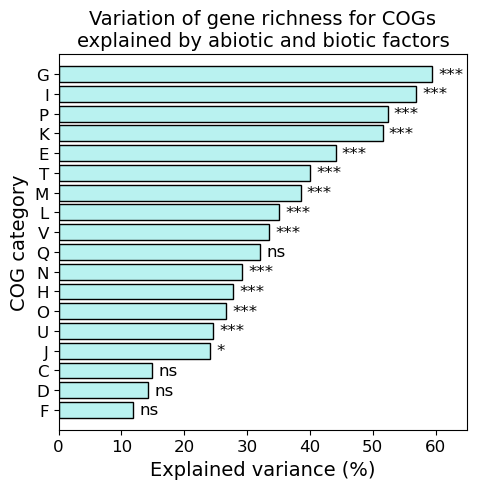

In [59]:
# Barplot for variance explained and their P-vals
abiot_bio_cog_permute = pd.read_csv(data_path_lm + "metadata_abio_bio_cog_results_with_fdr.csv", index_col=False)
abiot_bio_cog_permute = abiot_bio_cog_permute[['COG', 'Explained_Variance', 'P_var_exp_higher_FDR', 'P_var_exp_lower_FDR']]

# Create a new column 'P-val' with the relevant values or 'NS' if none are < 0.05
abiot_bio_cog_permute['FDR-P-val'] = np.where(
    abiot_bio_cog_permute['P_var_exp_higher_FDR'] < 0.05,
    abiot_bio_cog_permute['P_var_exp_higher_FDR'],
    np.where(abiot_bio_cog_permute['P_var_exp_lower_FDR'] < 0.05, abiot_bio_cog_permute['P_var_exp_lower_FDR'], 'NS')
)

# Create a new column 'than_null' with 'higher', 'lower', or 'NS'
abiot_bio_cog_permute['than_null'] = np.where(
    abiot_bio_cog_permute['P_var_exp_higher_FDR'] < 0.05,
    'higher',
    np.where(abiot_bio_cog_permute['P_var_exp_lower_FDR'] < 0.05, 'lower', 'NS')
)

abiot_bio_cog_permute = abiot_bio_cog_permute[['COG', 'Explained_Variance', 'FDR-P-val', 'than_null']]

# Sorting the proportions in descending order
abiot_bio_cog_permute_sorted = abiot_bio_cog_permute.sort_values(by='Explained_Variance', ascending=True)
abiot_bio_cog_permute_sorted = abiot_bio_cog_permute_sorted[~abiot_bio_cog_permute_sorted['COG'].isin(['S', 'W'])]

# Convert Explained_Variance to percentages
abiot_bio_cog_permute_sorted['Explained_Variance'] *= 100

# Create asterisks based on FDR-P-val
abiot_bio_cog_permute_sorted['FDR-P-val'] = pd.to_numeric(abiot_bio_cog_permute_sorted['FDR-P-val'], errors='coerce')
abiot_bio_cog_permute_sorted['FDR-P-val'] = abiot_bio_cog_permute_sorted['FDR-P-val'].fillna('NS')

def get_asterisks(p_val):
    if p_val == 'NS':
        return 'ns'
    elif p_val < 0.001:
        return '***'
    elif p_val < 0.01:
        return '**'
    elif p_val < 0.05:
        return '*'
    else:
        return '' 

abiot_bio_cog_permute_sorted['Asterisks'] = abiot_bio_cog_permute_sorted['FDR-P-val'].apply(get_asterisks)

# Define a color mapping based on 'than_null' column and specific COGs
color_mapping = {
    'higher': '#B9F2F0', 
    'lower': '#f39c12', 
    'NS': '#B9F2F0'
}

# Update color for specific COGs
special_cogs = ['L', 'V', 'J']
abiot_bio_cog_permute_sorted['Bar_Color'] = abiot_bio_cog_permute_sorted['COG'].apply(
    lambda x: '#B9F2F0' if x in special_cogs else color_mapping[abiot_bio_cog_permute_sorted.loc[abiot_bio_cog_permute_sorted['COG'] == x, 'than_null'].values[0]]
)

# Plotting the horizontal bar chart
plt.figure(figsize=(5, 5))
bars = plt.barh(
    abiot_bio_cog_permute_sorted['COG'], 
    abiot_bio_cog_permute_sorted['Explained_Variance'], 
    color=abiot_bio_cog_permute_sorted['Bar_Color'], 
    edgecolor='#000000'
)

# Adding the asterisks at the end of the respective bars
for bar, label in zip(bars, abiot_bio_cog_permute_sorted['Asterisks']):
    if label:  # Only annotate if there is an asterisk
        plt.text(
            bar.get_width() + 1,  # Position slightly to the right of the bar
            bar.get_y() + bar.get_height() / 2,  # Centered vertically
            label, 
            va='center', 
            ha='left', 
            fontsize=12, 
            color='black'
        )

# Customize labels and title
plt.xlabel('Explained variance (%)', fontsize=14)
plt.ylabel('COG category', fontsize=14)
plt.title('Variation of gene richness for COGs\nexplained by abiotic and biotic factors', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.xlim(0, 65)
plt.ylim(-1, 18)

plt.savefig(out_path_2 + 'fig_2b_cog_abio_bio_var_exp.pdf', bbox_inches='tight', dpi=600)
plt.show()

### Fig. 2c Spearman’s correlation between the relative abundance of bacterial phyla and gene richness, overall and for significant COGs identified in VPA.

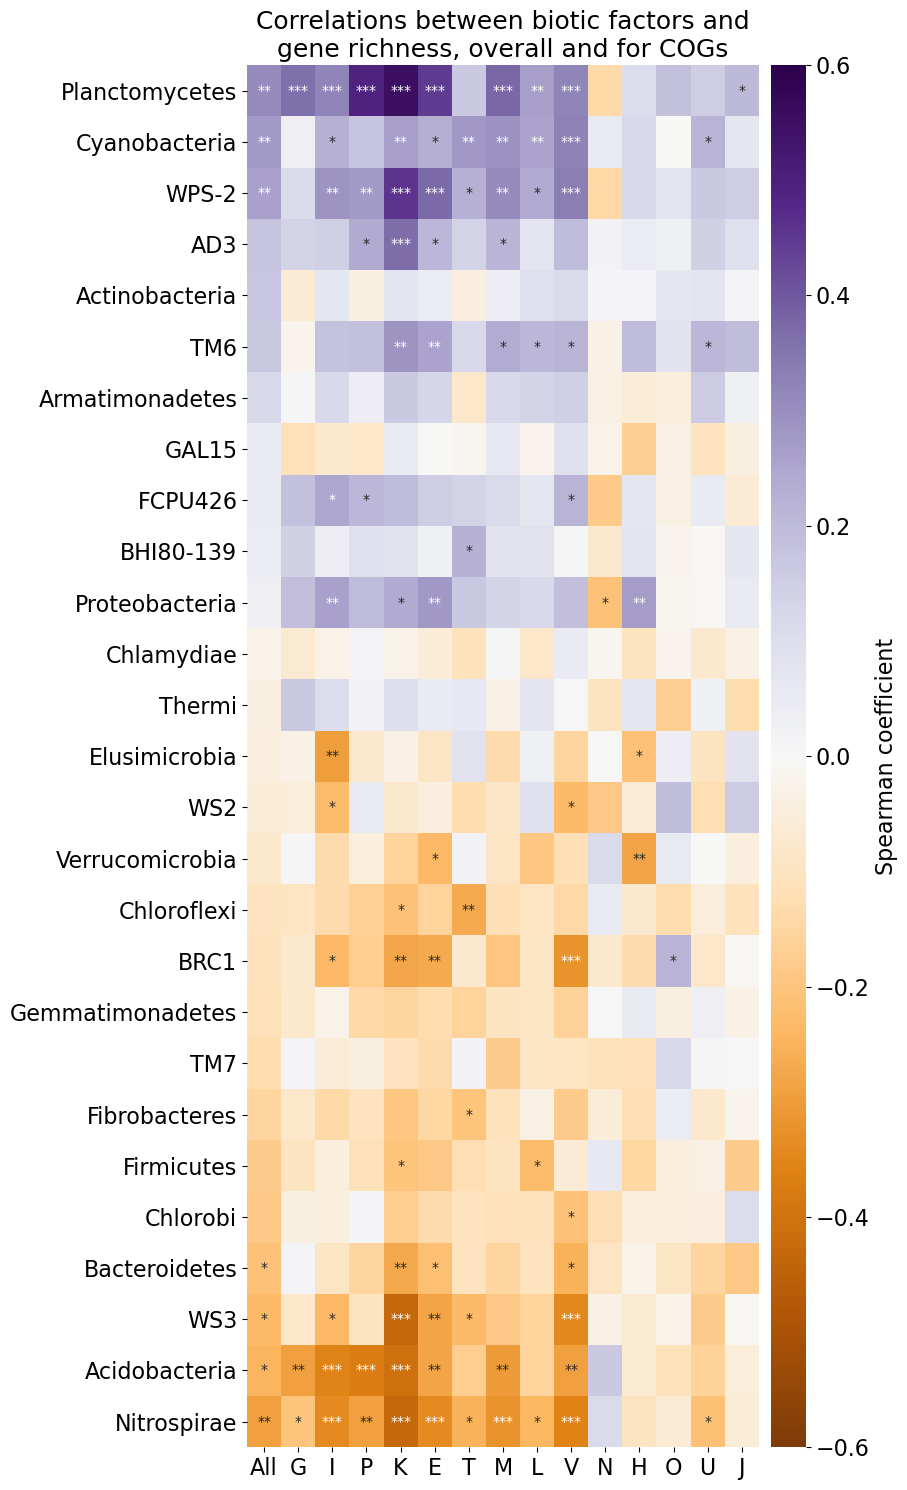

In [60]:
# Compute correlation between abiotic and biotic variables and (COG) gene richness
corr_df = compute_spearman_correlation(env_phyla_cog_rich, env_phyla_cog_rich, phyla_columns, richness_columns)

# Prepare pivot tables
pivot_corr, pivot_asterisks = prepare_pivot_tables(corr_df)

# Order according to the variance explained 
vpa_order = ['Overall', 'G', 'I', 'P', 'K', 'E', 'T', 'M', 'L', 'V', 'Q', 'N', 'H', 'O', 'U', 'J', 'C', 'D', 'F']
pivot_corr = pivot_corr[vpa_order]
pivot_asterisks = pivot_asterisks[vpa_order]
pivot_corr = pivot_corr.rename(columns={'Overall': 'All'})
pivot_asterisks = pivot_asterisks.rename(columns={'Overall': 'All'})
pivot_corr = pivot_corr.rename(index={'[Thermi]': 'Thermi'})
pivot_asterisks = pivot_asterisks.rename(index={'[Thermi]': 'Thermi'})

# Drop columns NS in VPA permutation analysis
columns_to_drop = ['Q', 'C', 'D', 'F'] 
pivot_corr_sel = pivot_corr.drop(columns=columns_to_drop)
pivot_asterisks_sel = pivot_asterisks.drop(columns=columns_to_drop)

# Define the desired order of phyla
phyla_order = ["Nitrospirae", "Planctomycetes", "Cyanobacteria", "WPS-2", "Acidobacteria", "TM6", "WS3", "BRC1", 
               "Proteobacteria", "Bacteroidetes", "AD3", "FCPU426", "Verrucomicrobia", "Chloroflexi", "WS2", 
               "Elusimicrobia", "Firmicutes", "Fibrobacteres", "Chlorobi", "BHI80-139", "Gemmatimonadetes", "GAL15", 
               "TM7", "Chlamydiae", "Armatimonadetes", "Actinobacteria", "Thermi"]


# Reindex the pivot tables to match the desired phyla order
pivot_corr = pivot_corr.reindex(phyla_order)
pivot_asterisks = pivot_asterisks.reindex(phyla_order)
pivot_corr_sel = pivot_corr_sel.reindex(phyla_order)
pivot_asterisks_sel = pivot_asterisks_sel.reindex(phyla_order)

# Sort abiotic factors based on 'All' column
sorted_index = pivot_corr_sel['All'].sort_values(ascending=False).index

# Reindex both correlation and asterisk tables
pivot_corr_sel = pivot_corr_sel.reindex(sorted_index)
pivot_asterisks_sel = pivot_asterisks_sel.reindex(sorted_index)

plot_heatmap(
    pivot_corr_sel, pivot_asterisks_sel,
    title="Correlations between biotic factors and\ngene richness, overall and for COGs",
    output_path=out_path_2 + "fig_2c_spearmancorr_phyla_overall.pdf",
    cmap="PuOr", vmin=-0.60, vmax=0.60, figsize=(9, 15)
)

### Fig. S4 Frequency of biotic factors significantly correlated with gene richness for COGs, sorted in descending order.

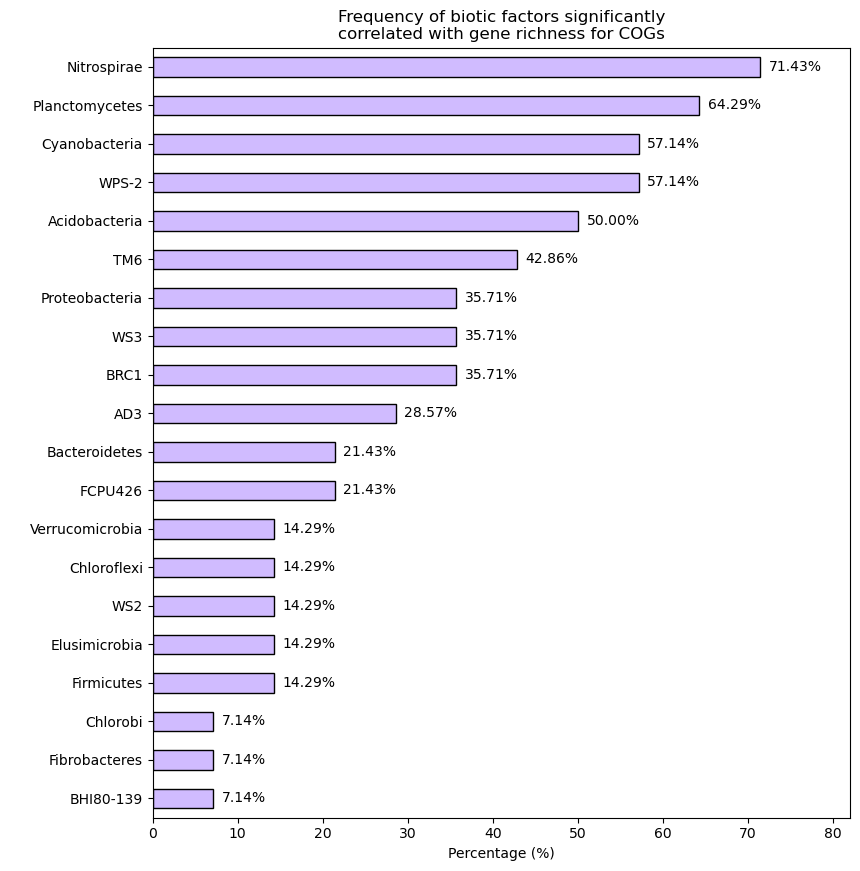

In [61]:
columns_to_drop = ['Q', 'C', 'D', 'F'] 
pivot_corr_2 = pivot_corr.drop(columns=columns_to_drop)
pivot_asterisks_2 = pivot_asterisks.drop(columns=columns_to_drop)

columns_to_drop = ['All'] 
pivot_corr_4 = pivot_corr_2.drop(columns=columns_to_drop)
pivot_asterisks_4 = pivot_asterisks_2.drop(columns=columns_to_drop)

# Count asterisks for each row
asterisk_counts_rows = count_asterisks(pivot_asterisks_4, axis=1)

total_columns = pivot_asterisks_4.shape[1]
asterisk_counts_rows = pivot_asterisks_4.astype(str).apply(lambda x: x.str.contains(r'\*', regex=True)).sum(axis=1)
asterisk_percentage_rows = (asterisk_counts_rows / total_columns) * 100
asterisk_percentage_rows_sorted = asterisk_percentage_rows.sort_values(ascending=True)

# Filter out rows with 0% before sorting
asterisk_percentage_rows_filtered = asterisk_percentage_rows[asterisk_percentage_rows > 0]
asterisk_percentage_rows_sorted = asterisk_percentage_rows_filtered.sort_values(ascending=True)

# Plotting the horizontal bar chart
plt.figure(figsize=(9, 10))
bars = asterisk_percentage_rows_sorted.plot(kind='barh', color='#D0BBFF', edgecolor='#000000')
plt.xlabel('Percentage (%)')
plt.ylabel(' ')
plt.title('Frequency of biotic factors significantly\ncorrelated with gene richness for COGs')

# Setting x-axis limits
plt.xlim(0, 82)  # Since it's a percentage, the max limit is 100

# Adding percentage values at the end of the bars
for index, value in enumerate(asterisk_percentage_rows_sorted):
    plt.text(value + 1, index, f'{value:.2f}%', va='center', ha='left', color='black')

# Save the figure
plt.savefig(out_path_supp + 'fig_s4_phyla_sig_spearman_prop.pdf', bbox_inches='tight', dpi=600)
plt.show()

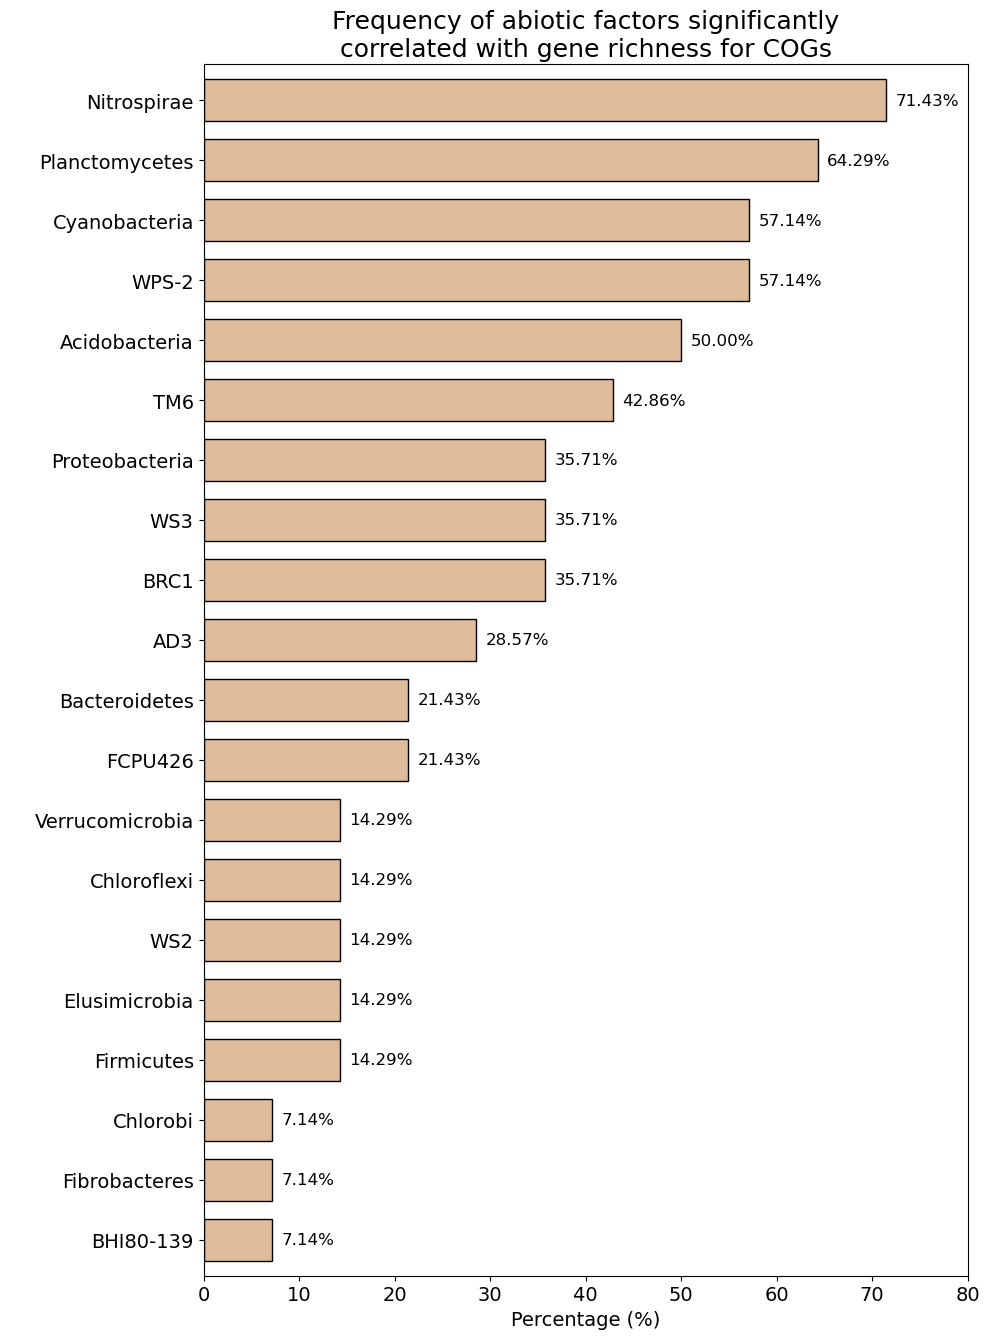

In [62]:
plt.figure(figsize=(10, 13.5))

# Manually control font sizes
plt.rcParams.update({
    'font.size': 10,
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14
})

bars = asterisk_percentage_rows_sorted.plot(
    kind='barh',
    color='#DEBB9B',
    edgecolor='#000000',
    width=0.7  # controls bar thickness
)

plt.xlabel('Percentage (%)')
plt.ylabel(' ')
plt.title('Frequency of abiotic factors significantly\ncorrelated with gene richness for COGs')

# Axis limits
plt.xlim(0, 80)

# Add labels
for index, value in enumerate(asterisk_percentage_rows_sorted):
    plt.text(value + 1, index, f'{value:.2f}%', va='center', ha='left', color='black', fontsize=12)

plt.tight_layout()
plt.savefig(out_path_supp + 'fig_s2_env_sig_spearman_prop.pdf', bbox_inches='tight', dpi=600)
plt.show()


In [63]:
# Count asterisks for each column
asterisk_counts_columns = count_asterisks(pivot_asterisks, axis=0)

# Count asterisks for each row
asterisk_counts_rows = count_asterisks(pivot_asterisks, axis=1)

#print("Asterisks in each column:")
#print(asterisk_counts_columns)

#print("\nAsterisks in each row:")
#print(asterisk_counts_rows)

### Fig. 2d RDA biplot illustrating the relationships between the _Lm_ accessory genome and 17 phyla selected by Lasso regularization.

In [64]:
# Load input data - pre/abs matrix
gen_pre_abs = pd.read_csv(data_path + "gene_pre_abs_lm.csv", index_col=0)
gen_pre_abs = gen_pre_abs.transpose()
gen_pre_abs = gen_pre_abs.rename_axis('Isolate ID')

# Load phyla data
phyla = env_phyla_cog_rich[['Isolate_ID', 'AD3', 'Acidobacteria', 'Actinobacteria', 'Armatimonadetes', 'BHI80-139', 'BRC1', 'Bacteroidetes',
    'Chlamydiae', 'Chlorobi', 'Chloroflexi', 'Cyanobacteria', 'Elusimicrobia', 'FCPU426', 'Fibrobacteres',
    'Firmicutes', 'GAL15', 'Gemmatimonadetes', 'Nitrospirae', 'Planctomycetes', 'Proteobacteria', 'TM6',
    'TM7', 'Verrucomicrobia', 'WPS-2', 'WS2', 'WS3', '[Thermi]']]
phyla = phyla.set_index('Isolate_ID')

# Drop rows not present in either gen_pre_abs or phyla
common_index = gen_pre_abs.index.intersection(phyla.index)
gen_pre_abs_phyla = gen_pre_abs.loc[common_index]
phyla = phyla.loc[common_index]

# Remove title for index
phyla.index.name = None
phyla.columns.name = None
gen_pre_abs_phyla.index.name = None
gen_pre_abs_phyla.columns.name = None

# Drop columns that consist only zeros in 'gen_pre_abs' df
column_totals = gen_pre_abs_phyla.sum(axis=0)

## Identify columns with a total of 0
columns_with_zero_total = column_totals[column_totals == 0].index

# Drop the columns that consist only of zeros
gen_pre_abs_phyla = gen_pre_abs_phyla.drop(columns=columns_with_zero_total)

# Export DataFrame to CSV
gen_pre_abs_phyla.to_csv(data_path_lm + 'gen_pre_abs_abio_bio.csv', index=True)
phyla.to_csv(data_path_lm + 'phyla.csv', index=True)

# Merge the two dataframes based on the index of gen_pre_abs
merged_df = gen_pre_abs_phyla.merge(phyla, left_index=True, right_index=True)

print(gen_pre_abs.shape)
print(len(columns_with_zero_total))
print(gen_pre_abs_phyla.shape)

print(phyla.shape)
print(merged_df.shape)

(177, 5873)
61
(167, 5812)
(167, 27)
(167, 5839)


In [65]:
# Feature selection for phyla to be included in RDA using L1 regularization (Lasso)
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.preprocessing import StandardScaler, RobustScaler

# Scale data using RobustScaler - account for outliers, more robust
scaler = RobustScaler()
X = scaler.fit_transform(phyla)

# Perform L1 regularization (Lasso)
lasso = Lasso(alpha=0.1, max_iter=10000, tol=1e-3)
lasso_selector = lasso.fit(X, gen_pre_abs_phyla.sum(axis=1)) # Using gene richness as a proxy target
lasso_support = lasso_selector.coef_ != 0
lasso_features = phyla.columns[lasso_support]
#print("Lasso selected features:", lasso_features)

# Create a new dataframe with selected features
selected_phyla = phyla[list(lasso_features)]
selected_phyla = phyla.loc[:, lasso_features].copy()

print(len(phyla.columns))
print(len(selected_phyla.columns))

27
17


In [66]:
# Performing RDA between biotic variables and pangenome
import pandas as pd
from skbio.stats.ordination import rda

# Perform RDA between selected environmental variables and pangenome
rda_result = rda(gen_pre_abs_phyla, selected_phyla, scale_Y=False, scaling=1)
RDA1 = rda_result.proportion_explained[0]
RDA2 = rda_result.proportion_explained[1]
total_explained = RDA1 + RDA2
print(f"Total Explained: {total_explained:.2%}")

Total Explained: 4.18%


In [67]:
# Extracting RDA axes 1 and 2 for machine learning
sample_scores = rda_result.samples

# Extract RDA1 and RDA2 scores
RDA1_scores = sample_scores.iloc[:, 0]  # First column for RDA1
RDA2_scores = sample_scores.iloc[:, 1]  # Second column for RDA2

# Combine RDA1 and RDA2 scores into a DataFrame if needed
rda_scores_df = sample_scores.loc[:, ['RDA1', 'RDA2']] = sample_scores.iloc[:, [0, 1]]

# Combine the data and export for ML 
phyla_isolate_rda = pd.merge(selected_phyla, rda_scores_df, left_index=True, right_index=True)
phyla_isolate_rda = phyla_isolate_rda.reset_index(drop=False)
phyla_isolate_rda = phyla_isolate_rda.rename(columns={'index': 'isolate_id'})
phyla_isolate_rda.to_csv(out_path_oth + "tab_1_phyla_isolate_rda_pangenome.csv", index=False)

In [68]:
import pandas as pd

# Load the data
gen_pre_abs_phyla = pd.read_csv(data_path_lm + "gen_pre_abs_abio_bio.csv", index_col=0)

# Rename L1, L2, L3 to LM lineage III, LM lineage II, LM lineage I respectively
rename_mapping = {
    'L1': 'III',
    'L2': 'II',
    'L3': 'I',
}
isolate['Phylogroup'] = isolate['Phylogroup'].apply(lambda x: rename_mapping.get(x, x))

# Filter for monocytogenes
monocytogenes_isolate = isolate[isolate['Species'] == 'L. monocytogenes']
monocytogenes_isolate = monocytogenes_isolate.reset_index()
monocytogenes_isolate = monocytogenes_isolate.set_index('Isolate ID')
monocytogenes_isolate = monocytogenes_isolate[monocytogenes_isolate['Phylogroup'].isin(['III', 'II', 'I'])]

# Merge with sample data
sample = gen_pre_abs_phyla.copy()
merged_df_2= pd.merge(sample, monocytogenes_isolate, left_index=True, right_index=True)

# Create lm_lineage and ensure it is a copy
lm_lineage = merged_df_2[['Phylogroup']].copy()
lm_lineage.rename(columns={'Phylogroup': 'Lineage'}, inplace=True)

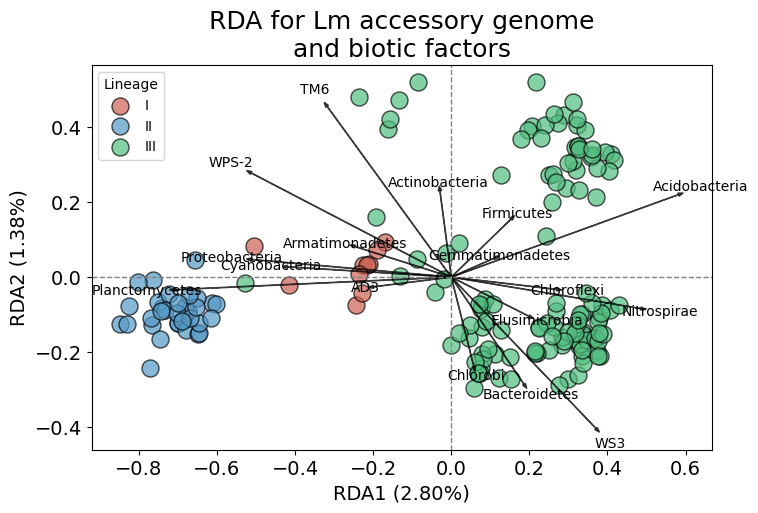

In [69]:
# Plot the RDA biplot

import matplotlib.pyplot as plt
import seaborn as sns

# Define colors for each lm_lineage
color_dict = {'I': '#CD6155', 'II': '#5499C7', 'III': '#52BE80'}
#color_dict = {'I': '#76448a', 'II': '#76448a', 'III': '#76448a'}

# Set up the plot
plt.figure(figsize=(8, 5))

# Plot the isolates
for group in color_dict.keys():
    sns.scatterplot(
        x=rda_result.samples.loc[lm_lineage['Lineage'] == group, 'RDA1'], 
        y=rda_result.samples.loc[lm_lineage['Lineage'] == group, 'RDA2'], 
        s=150, edgecolor='black', alpha=0.7, color=color_dict[group], label=f'{group}'
    )

# Plot arrows for environmental variables
for i in range(rda_result.biplot_scores.shape[0]):
    plt.arrow(0, 0, rda_result.biplot_scores['RDA1'][i], rda_result.biplot_scores['RDA2'][i], 
              color='black', alpha=0.7, head_width=0.009)
    plt.text(rda_result.biplot_scores['RDA1'][i]*1.1, rda_result.biplot_scores['RDA2'][i]*1.1, 
             rda_result.biplot_scores.index[i], color='black', ha='center', va='center')
    
# Add labels and title
plt.xlabel(f"RDA1 ({rda_result.proportion_explained[0]:.2%})")
plt.ylabel(f"RDA2 ({rda_result.proportion_explained[1]:.2%})")
plt.title("RDA for Lm accessory genome\nand biotic factors")
plt.axhline(0, color='grey', lw=1, linestyle='--')
plt.axvline(0, color='grey', lw=1, linestyle='--')

# Add legend
plt.legend(title='Lineage', loc='upper left')

# Show plot
plt.grid(False)
plt.savefig(out_path_2 + 'fig_2d_rda_phyla_pan.pdf', bbox_inches='tight', dpi=600)
plt.show()

In [70]:
# Assigning COG to respective genes and carry out VPA based on COG and environmental variables 
gen_annot = pd.read_csv(data_path + "gene_func_annot.csv")
gen_annot.rename(columns={" COG Functional Category": "COG Functional Category"}, inplace=True)
gen_annot.rename(columns={" query_name": "query_name"}, inplace=True)
gen_annot = gen_annot[['query_name', 'COG Functional Category']]

gen_annot['COG Functional Category'] = gen_annot['COG Functional Category'].replace('0', 'S')
gen_annot['COG Functional Category'] = gen_annot['COG Functional Category'].fillna('S')

gen_pre_abs = pd.read_csv(data_path + "gene_pre_abs_lm.csv", index_col=0)
gen_pre_abs = gen_pre_abs.transpose()

In [71]:
# Step 1: Group gen_annot by 'query_name' and combine all matching categories into a single string
gen_annot_grouped = (
    gen_annot.groupby('query_name')['COG Functional Category']
    .apply(lambda x: ','.join(x.unique()))
    .to_dict()
)

# Step 2: Replace 1s in gen_pre_abs with the concatenated values from gen_annot
def replace_func(cell, column):
    if cell == 1 and column in gen_annot_grouped:
        return gen_annot_grouped[column]
    return cell

# Step 3: Apply the replacement function across the DataFrame
gen_pre_abs_updated = gen_pre_abs.copy()
for column in gen_pre_abs.columns:
    gen_pre_abs_updated[column] = gen_pre_abs[column].apply(lambda cell: replace_func(cell, column))

# Drop the last column for counting
columns_to_count = gen_pre_abs_updated.iloc[:, :-1]

# Function to count occurrences of individual COG letters in each row (excluding 0s and non-alphabet characters)
def count_letters_by_row(row):
    # Convert all elements to strings, then filter out 0s and non-alphabet characters
    filtered_row = ''.join(map(str, row))
    letters = ''.join([char for char in filtered_row if char.isalpha()])  # Only keep alphabetic characters
    return pd.Series(list(letters)).value_counts()  # Count occurrences of each letter

# Apply the function row-wise
gen_pre_cog_counts = columns_to_count.apply(count_letters_by_row, axis=1).fillna(0).astype(int)

### Fig. S6a Enrichment of COGs among biotic-linked genes

In [72]:
def data_cleaner(count_data, sep):
  def extract_new_name(col_name, sep, unknown_counter=None):
    # Splitting the string at 'p__'
    if col_name == "index":
        return col_name
    parts = col_name.split(sep)
    if len(parts) > 1:
        # Further splitting at ';' and taking the first part
        new_name = parts[1].split(';')[0]
        if len(new_name) <= 1:
            new_name = 'Unknown'
    else:
        new_name = 'Unknown'
    # Ensuring uniqueness for 'Unknown' columns
    if new_name == 'Unknown' and unknown_counter is not None:
        new_name += f"_{unknown_counter[0]}"
        unknown_counter[0] += 1
    return new_name

  # Initialize a counter for 'Unknown' names
  unknown_counter = [1]

  # Renaming the columns with a unique identifier for 'Unknown'
  new_column_names = {col: extract_new_name(col, sep, unknown_counter=unknown_counter) for col in count_data.columns}

  count_data_cleaned = count_data.rename(columns=new_column_names)


  # Identify all 'Unknown' columns
  unknown_columns = [col for col in count_data_cleaned.columns if 'Unknown' in col]


  # sum unknown columns into a new column
  if unknown_columns:
      count_data_cleaned['Unknown'] = count_data_cleaned[unknown_columns].sum(axis=1)

  count_data_cleaned = count_data_cleaned.drop(columns=unknown_columns)

  # Calculate the sum of each column
  row_sums = count_data_cleaned.iloc[:, 1:].sum(axis=1)

  # Divide each entry of each column by the respective row sum
  count_data_cleaned.iloc[:, 1:] = count_data_cleaned.iloc[:, 1:].div(row_sums, axis=0)

  count_data_cleaned.drop('Unknown', axis=1, inplace=True, errors='ignore')

  return count_data_cleaned

In [73]:
# Load input data - isolate metadata
isolate = pd.read_csv(data_path + "Listeria_genomes.csv", index_col=0)

# renaming L1, L2, L3 to LM lineage III, LM lineage II, LM lineage I respectively
rename_mapping = {
    "L1": "III",
    "L2": "II",
    "L3": "I",
}
isolate["Phylogroup"] = isolate["Phylogroup"].apply(lambda x: rename_mapping.get(x, x))

# Filtering for L. monocytogenes
lm_isolate = isolate[isolate["Species"] == "L. monocytogenes"]
lm_isolate = lm_isolate.set_index('Isolate ID')

lm_1 = list(lm_isolate[lm_isolate["Phylogroup"] == "I"].index)
lm_2 = list(lm_isolate[lm_isolate["Phylogroup"] == "II"].index)
lm_3 = list(lm_isolate[lm_isolate["Phylogroup"] == "III"].index)
lm_all = lm_isolate.index.tolist()

# Load input data - pre/abs matrix
gen_pre_abs = pd.read_csv(data_path + "gene_pre_abs_lm.csv", index_col=0)
gen_pre_abs = gen_pre_abs.transpose()
gen_pre_abs = gen_pre_abs.rename_axis('Isolate ID')

# Reset index and select relevant columns from lm_isolate
lm_sample = lm_isolate.reset_index()
lm_sample = lm_sample[['Isolate ID', 'Sample ID']]

# Load phyla data
phylum_count_data = pd.read_csv(data_path + "phylum_count.csv")
phylum_count_data_cleaned = data_cleaner(phylum_count_data, sep = "p__")
phylum_count_data_cleaned.set_index('index', inplace=True)
phylum_count_data_cleaned = phylum_count_data_cleaned.dropna()

# Merge with lm_sample
phyla_isolate = lm_sample.merge(phylum_count_data_cleaned, left_on='Sample ID', right_index=True, how='left', suffixes=('', '_env'))

# Set 'Isolate ID' as the index and drop 'Sample ID' column
phyla_isolate.set_index('Isolate ID', inplace=True)
phyla_isolate.drop(columns=['Sample ID'], inplace=True)

# Drop rows with NaN values
phyla_isolate = phyla_isolate.dropna()

# Drop rows not present in either gen_pre_abs or env_isolate
common_index = gen_pre_abs.index.intersection(phyla_isolate.index)
gen_pre_abs_phyla = gen_pre_abs.loc[common_index]
phyla_isolate = phyla_isolate.loc[common_index]

# Remove title for index
phyla_isolate.index.name = None
phyla_isolate.columns.name = None
gen_pre_abs_phyla.index.name = None
gen_pre_abs_phyla.columns.name = None

# Drop columns that consist only zeros in 'gen_pre_abs' df
column_totals = gen_pre_abs_phyla.sum(axis=0)

## Identify columns with a total of 0
columns_with_zero_total = column_totals[column_totals == 0].index

# Drop the columns that consist only of zeros
gen_pre_abs_phyla = gen_pre_abs_phyla.drop(columns=columns_with_zero_total)

# Export DataFrame to CSV
gen_pre_abs_phyla.to_csv(data_path_lm + 'gen_pre_abs_phyla.csv', index=True)
phyla_isolate.to_csv(data_path_lm + 'phyla_isolate.csv', index=True)

# Merge the two dataframes based on the index of gen_pre_abs
merged_df = gen_pre_abs_phyla.merge(phyla_isolate, left_index=True, right_index=True)

print(phyla_isolate.shape)
print(gen_pre_abs_phyla.shape)

(175, 28)
(175, 5867)


In [74]:
# Identifying phyla-linked genes
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Load input data
gen_pre_abs_phyla = pd.read_csv(data_path_lm + "gen_pre_abs_phyla.csv", index_col=0)
phyla_isolate = pd.read_csv(data_path_lm + 'phyla_isolate.csv', index_col=0)

# Initialize an empty DataFrame to store the raw p-values
raw_pval = pd.DataFrame()

# Initialize an empty DataFrame to store significant results after FDR correction
fdr_corrected_results = pd.DataFrame()

# Iterate through each gene in sig_gen_pre_abs
for gene in gen_pre_abs_phyla.columns:
    present_rows = gen_pre_abs_phyla[gen_pre_abs_phyla[gene] == 1].index
    absent_rows = gen_pre_abs_phyla[gen_pre_abs_phyla[gene] == 0].index
    
    if len(present_rows) == 0 or len(absent_rows) == 0:
        # Skip this gene since one of the groups is empty (no variation)
        continue
    
    # Initialize lists to store Mann-Whitney test results
    u_values = []
    p_values = []
    
    # Iterate through each phyla in phyla_isolate
    for phyla in phyla_isolate.columns:
        # Get the phyla values for the present and absent groups
        present_phyla = phyla_isolate.loc[present_rows, phyla]
        absent_phyla = phyla_isolate.loc[absent_rows, phyla]
        
        # Perform Mann-Whitney U test
        u_statistic, p_value = mannwhitneyu(present_phyla, absent_phyla)
        
        # Append the results to the lists
        u_values.append(u_statistic)
        p_values.append(p_value)
    
    # Create a DataFrame to store the Mann-Whitney test results for each phyla_var
    mw_results = pd.DataFrame({
        'Gene': gene,
        'Env_var': phyla_isolate.columns,
        'U_Value': u_values,
        'P_Value': p_values
    })
    
    # Concatenate the raw p-values results
    raw_pval = pd.concat([raw_pval, mw_results])

# Perform False Discovery Rate (FDR) correction on the combined p-values
rejected, p_corrected, _, _ = multipletests(raw_pval['P_Value'], alpha=0.05, method='fdr_bh')

# Add the FDR-corrected p-values to the raw_pval DataFrame
raw_pval['FDR_Corrected_P_Value'] = p_corrected
raw_pval['Rejected'] = rejected

# Filter for significant results after FDR correction
fdr_adjusted_pval = raw_pval[raw_pval['Rejected']]

# Select columns for the FDR corrected results
fdr_adjusted_phyla_pval = fdr_adjusted_pval[['Gene', 'Env_var', 'U_Value', 'P_Value', 'FDR_Corrected_P_Value']]

# Reorder the raw_pval_results columns as per your requirement
raw_phyla_pval = raw_pval[['Gene', 'Env_var', 'U_Value', 'P_Value', 'FDR_Corrected_P_Value']]

# Sort significant_results based on 'FDR_Corrected_P_Value' column
fdr_adjusted_phyla_pval_sorted = fdr_adjusted_phyla_pval.sort_values(by='FDR_Corrected_P_Value')
fdr_adjusted_phyla_pval_sorted.to_csv(out_path_supp + 'tab_s1_all_phyla_all_gene.csv')

In [75]:
print(len(raw_phyla_pval))
print(len(fdr_adjusted_phyla_pval)) # number of significant association between phyla and gene
print(len(fdr_adjusted_phyla_pval['Gene'].unique())) # number of unique genes involved

99204
2436
807


In [76]:
# Functional enrichment analysis of phyla-linked genes

# Loading and preprocessing COG annotation file
gen_annot = pd.read_csv(data_path + "gene_func_annot.csv")
gen_annot.rename(columns={" COG Functional Category": "COG Functional Category"}, inplace=True)
gen_annot.rename(columns={" query_name": "query_name"}, inplace=True)
gen_annot = gen_annot[['query_name', 'COG Functional Category']]

# In gen_annot Replace '0' and Nan with 'S' - All 0, Nan and S are indicating 'Function unknown' 
gen_annot['COG Functional Category'] = gen_annot['COG Functional Category'].replace('0', 'S')
gen_annot['COG Functional Category'] = gen_annot['COG Functional Category'].fillna('S')

# Get the unique gene of the abiotic-linked genes from the 'Gene' column
unique_genes = fdr_adjusted_phyla_pval['Gene'].unique()

# Convert the unique values into a DataFrame with 'query_name' as the column name
gen_phyla_df = pd.DataFrame(unique_genes, columns=['query_name'])

# Set 'query_name' as the index of the DataFrame
gen_phyla_df.set_index('query_name', inplace=True)

# Merge gen_phyla_df with gen_annot using the 'query_name' index from gen_phyla_df
gen_phyla_annotated = gen_phyla_df.merge(gen_annot, left_index=True, right_on='query_name', how='left')

# Apply the function to split the rows - spliting genes (rows) that have >1 COG
gen_phyla_cog_split = split_rows(gen_phyla_annotated, 'COG Functional Category')

In [77]:
# Convert 'COG Functional Category' column to lists of individual characters
gen_phyla_annotated['COG Functional Category'] = gen_phyla_annotated['COG Functional Category'].apply(
    lambda x: [char.upper() for char in x if char.isalpha()])

# Create a long list of individual characters
cog_phyla_list = [char for sublist in gen_phyla_annotated['COG Functional Category'] for char in sublist]

# Count the occurrences of each character
cog_phyla_series = pd.Series(cog_phyla_list)
print(len(cog_phyla_series))

832


In [78]:
# Count occurrences of each unique COG from the overall dataframe (N)
gen_annot = gen_annot.set_index('query_name')
gen_pre_abs_env = pd.read_csv(data_path_lm + "gen_pre_abs_env.csv", index_col=0)
gen_pre_abs_env = gen_pre_abs_env.transpose()
cog = gen_pre_abs_env.merge(gen_annot, left_index=True, right_index=True, how='left')

# Apply the function to split the rows - spliting genes (rows) that have >1 COG
cog_split = split_rows(cog, 'COG Functional Category')

# calculate the expected proportion for each COG
prop_exp = cog_split['COG Functional Category'].value_counts(normalize=True).to_frame(name='Proportion')

# calculate the observed proportion for each significant COG
count_sig_phyla_cog = cog_phyla_series.value_counts(normalize=False).to_frame(name='Count')

In [79]:
# Perform the enrichment analysis
sig_phyla_cog_enrich = enrichment_analysis(count_sig_phyla_cog, prop_exp)

In [80]:
# Prepare the dataframe for bubble plot visualization
sig_phyla_cog_enrich_count = pd.merge(sig_phyla_cog_enrich, count_sig_phyla_cog, left_index = True, right_index = True)
sig_phyla_cog_enrich_count = sig_phyla_cog_enrich_count.reset_index(names=['COG functional category']).sort_values(by="Enrichment index", ascending=False)
sig_phyla_cog_enrich_count = sig_phyla_cog_enrich_count[sig_phyla_cog_enrich_count['COG functional category'] != 'S']

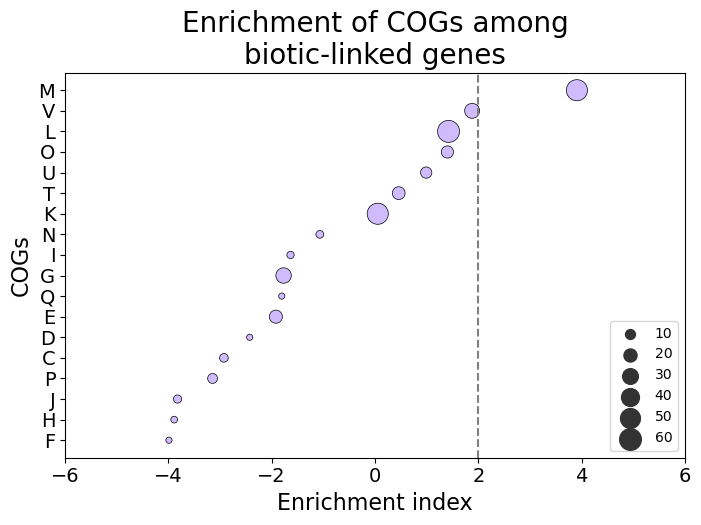

In [81]:
# Make a bubble plot
plt.rcParams["figure.figsize"] = (8, 5)

# Use a scatter plot with varying sizes and colors
bubble_plot = sns.scatterplot(
    data=sig_phyla_cog_enrich_count,
    x='Enrichment index',
    y='COG functional category',
    size='Count',
    color='#D0BBFF',
    sizes=(20, 250),  # Adjust the range of bubble sizes
    alpha=1,
    edgecolor='black',
    linewidth=0.5,
)

#plt.axvline(x=-2, color='grey', linestyle='--')
plt.axvline(x=2, color='grey', linestyle='--')
plt.title('Enrichment of COGs among\nbiotic-linked genes', size=20)
plt.xlabel('Enrichment index', size=16)
plt.ylabel('COGs', size=16)

# Adjust font size for tick labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="lower right", bbox_to_anchor=(1, 0))
plt.xlim(-6, 6)

plt.savefig(out_path_supp + 'fig_s6a_enrich.pdf', bbox_inches='tight', dpi=600)
plt.show()


### Fig. S6b Venn diagram showing the overlap between abiotic- and biotic-linked genes

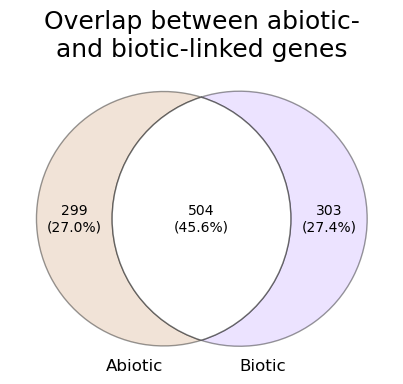

In [82]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

gen_env = pd.read_csv(out_path_supp + 'tab_s1_all_env_all_gene.csv', index_col=1)
gen_phyla = pd.read_csv(out_path_supp + 'tab_s1_all_phyla_all_gene.csv', index_col=1)

gen_env_ids = set(gen_env.index)
gen_otu_ids = set(gen_phyla.index)

# Calculate the counts and percentages
only_gen_env = len(gen_env_ids - gen_otu_ids)
only_gen_otu = len(gen_otu_ids - gen_env_ids)
both = len(gen_env_ids & gen_otu_ids)
total = len(gen_env_ids | gen_otu_ids)

only_gen_env_pct = only_gen_env / total * 100
only_gen_otu_pct = only_gen_otu / total * 100
both_pct = both / total * 100

# Create a figure with a specific size
plt.figure(figsize=(5, 4))

# Create the Venn diagram
venn_diagram = venn2(
    [gen_env_ids, gen_otu_ids],
    ('Abiotic', 'Biotic'),
    set_colors=('#DEBB9B', '#D0BBFF')
)

# Customize the edge colors
for patch in venn_diagram.patches:
    if patch:
        patch.set_edgecolor('#000000')

# Customize the labels to show the counts and percentages
venn_diagram.get_label_by_id('10').set_text(f'{only_gen_env}\n({only_gen_env_pct:.1f}%)')
venn_diagram.get_label_by_id('01').set_text(f'{only_gen_otu}\n({only_gen_otu_pct:.1f}%)')
venn_diagram.get_label_by_id('11').set_text(f'{both}\n({both_pct:.1f}%)')

# Display the Venn diagram
plt.title('Overlap between abiotic-\nand biotic-linked genes')
plt.savefig(out_path_supp + 'fig_s6b_gen_env_phyla.pdf', bbox_inches='tight', dpi=600)
plt.show()

In [83]:
gen_env_ids = set(gen_env.index)
gen_otu_ids = set(gen_phyla.index)

# Calculate the IDs in each category
only_gen_env = gen_env_ids - gen_otu_ids
only_gen_otu = gen_otu_ids - gen_env_ids
both = gen_env_ids & gen_otu_ids

# Create lists of tuples for each category
only_gen_env_list = [(id, 'Abiotic') for id in only_gen_env]
only_gen_otu_list = [(id, 'Biotic') for id in only_gen_otu]
both_list = [(id, 'Both') for id in both]

# Combine all lists
combined_list = only_gen_env_list + only_gen_otu_list + both_list

# Create a DataFrame
df_gen_env_otu = pd.DataFrame(combined_list, columns=['Gene', 'Associate with'])

# Save the DataFrame to a CSV file
df_gen_env_otu.to_csv(out_path_supp + 'gen_link_env_otu.csv', index=False)

In [84]:
# Merging to COG annotation file to see if they have any difference
gen_env_otu = df_gen_env_otu.rename(columns={'Gene': 'query_name'})
gen_env_otu = gen_env_otu.set_index('query_name')

# Loading and preprocessing COG annotation file
gen_annot = pd.read_csv(data_path + "gene_func_annot.csv")
gen_annot.rename(columns={" COG Functional Category": "COG Functional Category"}, inplace=True)
gen_annot.rename(columns={" query_name": "query_name"}, inplace=True)
gen_annot.rename(columns={" eggNOG free text description": "eggNOG_description"}, inplace=True)
gen_annot = gen_annot[['query_name', 'COG Functional Category', 'eggNOG_description']]

# In gen_annot Replace '0' and Nan with 'S' - All 0, Nan and S are indicating 'Function unknown' 
gen_annot['COG Functional Category'] = gen_annot['COG Functional Category'].replace('0', 'S')
gen_annot['COG Functional Category'] = gen_annot['COG Functional Category'].fillna('S')

# Merge gen_env_df with gen_annot using the 'query_name' index from gen_env_df
gen_env_otu_annotated = gen_env_otu.merge(gen_annot, left_index=True, right_on='query_name', how='left')

# Apply the function to split the rows - spliting genes (rows) that have >1 COG
gen_env_otu_cog_split = split_rows(gen_env_otu_annotated, 'COG Functional Category')

In [85]:
cog_unique_bio = gen_env_otu_cog_split[gen_env_otu_cog_split['Associate with'] == 'Biotic']
cog_unique_abio = gen_env_otu_cog_split[gen_env_otu_cog_split['Associate with'] == 'Abiotic']

In [86]:
gen_pre_abs = pd.read_csv(data_path + "gene_pre_abs_lm.csv", index_col=0)

gen_annot = pd.read_csv(data_path + "gene_func_annot.csv")
gen_annot.rename(columns={" COG Functional Category": "COG Functional Category"}, inplace=True)
gen_annot.rename(columns={" query_name": "query_name"}, inplace=True)
gen_annot.rename(columns={' Predicted protein name': 'Predicted protein name'}, inplace=True)
gen_annot.rename(columns={' eggNOG free text description': 'eggNOG description'}, inplace=True)
gen_annot = gen_annot[['query_name', 'Predicted protein name', 'COG Functional Category', 'eggNOG description']]

# In gen_annot Replace '0' and Nan with 'S' - All 0, Nan and S are indicating 'Function unknown' 
gen_annot['COG Functional Category'] = gen_annot['COG Functional Category'].replace('0', 'S')
gen_annot['COG Functional Category'] = gen_annot['COG Functional Category'].fillna('S')

cog_unique_bio = cog_unique_bio.copy()
cog_unique_abio = cog_unique_abio.copy()

# Convert 'COG Functional Category' column to lists of individual characters
cog_unique_bio['COG Functional Category'] = cog_unique_bio['COG Functional Category'].apply(
    lambda x: [char.upper() for char in x if char.isalpha()])
cog_unique_abio['COG Functional Category'] = cog_unique_abio['COG Functional Category'].apply(
    lambda x: [char.upper() for char in x if char.isalpha()])

# Create a long list of individual characters
cog_unique_bio_list = [char for sublist in cog_unique_bio['COG Functional Category'] for char in sublist]
cog_unique_abio_list = [char for sublist in cog_unique_abio['COG Functional Category'] for char in sublist]

# Count the occurrences of each character
cog_unique_bio_series = pd.Series(cog_unique_bio_list)
cog_unique_abio_series = pd.Series(cog_unique_abio_list)

# Count occurrences of each unique COG from the overall dataframe (N)
gen_annot = gen_annot.set_index('query_name')
cog = gen_pre_abs.merge(gen_annot, left_index=True, right_index=True, how='left')

# Apply the function to split the rows - spliting genes (rows) that have >1 COG
cog_split = split_rows(cog, 'COG Functional Category')

# calculate the expected proportion for each COG
prop_exp = cog_split['COG Functional Category'].value_counts(normalize=True).to_frame(name='Proportion')

# calculate the observed proportion for each significant COG
count_cog_unique_bio = cog_unique_bio_series.value_counts(normalize=False).to_frame(name='Count')
count_cog_unique_abio = cog_unique_abio_series.value_counts(normalize=False).to_frame(name='Count')

In [87]:
# perform the enrichment analysis
cog_unique_bio_enrich = enrichment_analysis(count_cog_unique_bio, prop_exp)
cog_unique_abio_enrich = enrichment_analysis(count_cog_unique_abio, prop_exp)

# prepare the dataframe for bubble plot visualization
cog_unique_bio_enrich_count = pd.merge(cog_unique_bio_enrich, count_cog_unique_bio, left_index = True, right_index = True)
cog_unique_abio_enrich_count = pd.merge(cog_unique_abio_enrich, count_cog_unique_abio, left_index = True, right_index = True)

cog_unique_bio_enrich_count = cog_unique_bio_enrich_count.reset_index(names=['COG functional category']).sort_values(by="Enrichment index", ascending=False)
cog_unique_abio_enrich_count = cog_unique_abio_enrich_count.reset_index(names=['COG functional category']).sort_values(by="Enrichment index", ascending=False)

cog_unique_bio_enrich_count = cog_unique_bio_enrich_count[cog_unique_bio_enrich_count['COG functional category'] != 'S']
cog_unique_abio_enrich_count = cog_unique_abio_enrich_count[cog_unique_abio_enrich_count['COG functional category'] != 'S']

### Fig. S6c Enrichment of COGs among exclusive abiotic-linked genes

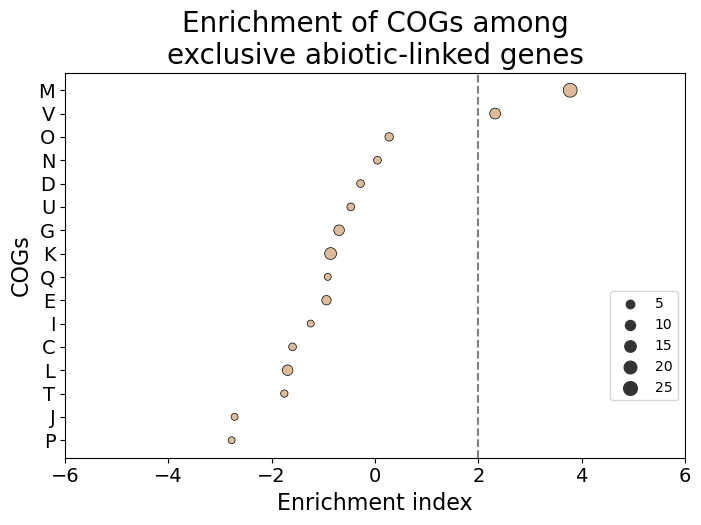

In [88]:
# make a bubble plot

plt.rcParams["figure.figsize"] = (8, 5)

# Use a scatter plot with varying sizes and colors
bubble_plot = sns.scatterplot(
    data=cog_unique_abio_enrich_count,
    x='Enrichment index',
    y='COG functional category',
    size='Count',
    color='#DEBB9B',
    sizes=(25, 100),  # Adjust the range of bubble sizes
    alpha=1,
    edgecolor='black',
    linewidth=0.5,
)

#plt.axvline(x=-2, color='grey', linestyle='--')
plt.axvline(x=2, color='grey', linestyle='--')
plt.title('Enrichment of COGs among\nexclusive abiotic-linked genes', size = 20)
plt.xlabel('Enrichment index', size=16)
plt.ylabel('COGs', size=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(bbox_to_anchor=(1, 0.45))
plt.xlim(-6,6)
#plt.ylim(10, -0.7)

plt.savefig(out_path_supp + 'fig_s6c_enrich_abiotic_unique.pdf', bbox_inches='tight', dpi=600)
plt.show()

### Fig. 2g Enrichment of COGs among exclusive biotic-linked genes

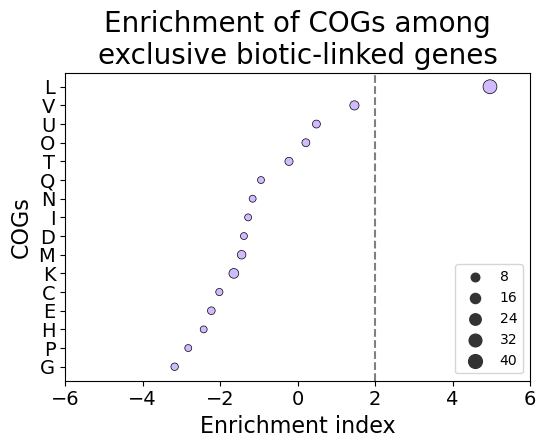

In [89]:
# make a bubble plot

plt.rcParams["figure.figsize"] = (6, 4)

# Use a scatter plot with varying sizes and colors
bubble_plot = sns.scatterplot(
    data=cog_unique_bio_enrich_count,
    x='Enrichment index',
    y='COG functional category',
    size='Count',
    color='#D0BBFF',
    sizes=(25, 100),  # Adjust the range of bubble sizes
    alpha=1,
    edgecolor='black',
    linewidth=0.5,
)

#plt.axvline(x=-2, color='grey', linestyle='--')
plt.axvline(x=2, color='grey', linestyle='--')
plt.title('Enrichment of COGs among\nexclusive biotic-linked genes', size = 20)
plt.xlabel('Enrichment index', size=16)
plt.ylabel('COGs', size=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(bbox_to_anchor=(1, 0.4))
plt.xlim(-6,6)
#plt.ylim(6.5, -0.7)

plt.savefig(out_path_2 + 'fig_2g_enrich_biotic_unique.pdf', bbox_inches='tight', dpi=600)
plt.show()

## Fig 3 | Pangenome variation is substantial among _Lm_ lineages.

### Fig 3a Map showing the distribution of _Lm_ lineages in soils across the US.

In [90]:
# Load input data
env = pd.read_csv(data_path + "environ_all.csv", index_col=0)
env = env.reset_index()
env = env.rename(columns={'Sample ID ': 'Sample ID'})

isolate = pd.read_csv(data_path + "Listeria_genomes.csv", index_col=0)

In [91]:
# Assign groups for samples positive and negative for Lm
lm = isolate[(isolate["Phylogroup"] == "L1") | (isolate["Phylogroup"] == "L2") | (isolate["Phylogroup"] == "L3")]

sample = env.copy()
sample["group"] = np.where(sample.index.isin(lm["Sample ID"]), "pos", "neg")

group = sample[["group"]]

lm_pos = group[group["group"] == "pos"]
lm_neg = group[group["group"] == "neg"]

In [92]:
## Select only Lm and see their phylogroup for crosschecking
isolate_lm = isolate[isolate["Species"] == "L. monocytogenes"]
selected_columns = ["Phylogroup"]

# Create an empty dictionary to store frequency counts for each column
frequency_counts = {}

# Iterate through selected columns and calculate value counts
for column in selected_columns:
    counts = isolate_lm[column].value_counts()
    frequency_counts[column] = counts

# Print the frequency counts
for column, counts in frequency_counts.items():
    print(f"Column: {column}")
    print(counts)
    print("\n")

# Merge with environmental data, keeping ALL samples (including negatives)
df_map = pd.merge(env, isolate_lm, on="Sample ID", how="left")

# Rename columns for clarity
df_map = df_map.rename(columns={
    "Latitude": "Lat",
    "Longitude": "Lon",
    "Phylogroup": "Group",
})

# Convert phylogroup labels
df_map["Group"] = df_map["Group"].replace({
    "L1": "III",
    "L2": "II",
    "L3": "I"
})

# Create color mapping for positives
df_map["Color"] = df_map["Group"].map({
    "I": "#CD6155",
    "II": "#5499C7",
    "III": "#52BE80"
})

# Add a detection status column
df_map["Detected"] = df_map["Species"].apply(lambda x: "Positive" if x == "L. monocytogenes" else "Negative")

# Save for mapping
df_map.to_csv(data_path_lm + "df_map_lm_lineages_with_negatives.csv", index=False)

df_map = (
    df_map.sort_values(by='Group', key=lambda x: x == 'negative')
    .drop_duplicates(subset='Sample ID', keep='last')
)

Column: Phylogroup
Phylogroup
L1    126
L2     39
L3     12
Name: count, dtype: int64




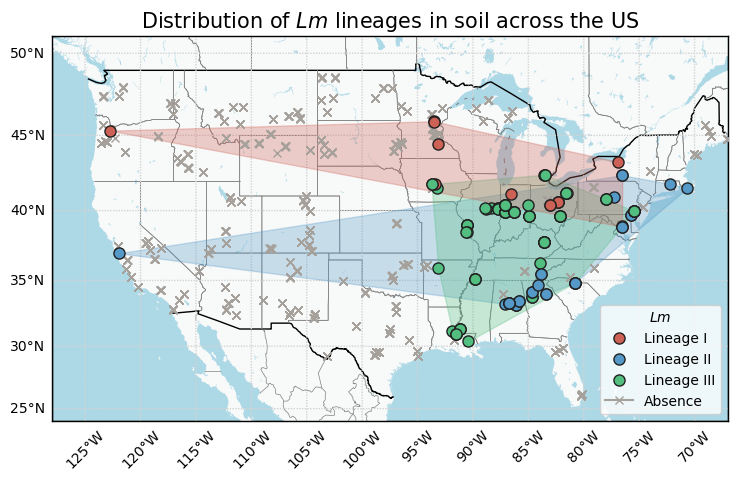

In [93]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import shapefile
from shapely.geometry import MultiPoint
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np

# --- Data setup ---
lats = df_map['Lat'].astype(float).tolist()
lons = df_map['Lon'].astype(float).tolist()
groups = df_map['Group'].astype(str).tolist()
colors = df_map['Color'].astype(str).tolist()
detected = df_map['Detected'].astype(str).tolist()

# --- Map setup ---
bbox = [24, 51, -128, -67]
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

m = Basemap(
    projection='merc',
    llcrnrlat=bbox[0],
    urcrnrlat=bbox[1],
    llcrnrlon=bbox[2],
    urcrnrlon=bbox[3],
    lat_ts=10,
    resolution='i',
    ax=ax
)

# Draw map features
m.drawcountries(linewidth=1, color='black')
m.fillcontinents(color='#F8F9F9', lake_color='lightblue')
m.drawstates(linewidth=0.5, linestyle='solid', color='grey', antialiased=1)
m.drawparallels(np.arange(25, 55, 5), color="lightgray", labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-125, -65, 5), color="lightgray", labels=[0, 0, 0, 1], rotation=45)
m.drawmapboundary(fill_color='lightblue')


# Plot negatives (grey crosses)
for lon, lat, det in zip(lons, lats, detected):
    if det == "Negative":
        x, y = m(lon, lat)
        m.plot(x, y, marker='x', color='#A6A09B', markersize=6, label="Negative", zorder=3)

# Plot positives (colored dots by lineage)
for lon, lat, group, color, det in zip(lons, lats, groups, colors, detected):
    if det == "Positive":
        if group in ["I", "II", "III"]:
            x, y = m(lon, lat)
            m.plot(
                x, y, 'o',
                markersize=8,
                markeredgecolor='#212121',
                color=color,
                label=group,
                zorder=4
            )

# --- Convex hulls for each positive lineage ---
poly = {}
for lon, lat, color, det in zip(lons, lats, colors, detected):
    if det == "Positive":
        pair = (lon, lat)
        poly.setdefault(color, []).append(pair)

for poly_color, coords in poly.items():
    if len(coords) > 2:  # need at least 3 points for a polygon
        polygon = MultiPoint(coords).convex_hull
        x, y = polygon.exterior.xy
        x, y = m(x.tolist(), y.tolist())
        ax.add_collection(
            PatchCollection(
                [Polygon(list(zip(x, y)), closed=True)],
                facecolor=poly_color,
                edgecolor=poly_color,
                linewidths=1.0,
                zorder=2,
                alpha=0.3
            )
        )

# --- Legend ---
handles, labels = plt.gca().get_legend_handles_labels()

by_label = {}
for h, l in zip(handles, labels):
    if l in ["Negative", "I", "II", "III"]:
        by_label[l] = h

# Custom order: Negative → I → II → III
desired_order = ["I", "II", "III", "Negative"]
pretty_labels = {
    "I": r"Lineage I",
    "II": r"Lineage II",
    "III": r"Lineage III",
    "Negative": "Absence"
}

by_label_sorted = {
    pretty_labels[label]: by_label[label]
    for label in desired_order
    if label in by_label
}

# Legend formatting
plt.legend(
    by_label_sorted.values(),
    by_label_sorted.keys(),
    loc='lower right',
    bbox_to_anchor=(1, 0),
    title="$\it{Lm}$"
)

# --- Title and save ---
plt.title('Distribution of $\\it{Lm}$ lineages in soil across the US', size=15)
plt.savefig(out_path_3 + 'fig_3a_lm_lineage_map.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

### Fig. S7 Abiotic factors compared among _Lm_ lineages.

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator

def plot_3_box_with_mw_and_swarm(data, x, y, box_pairs, title="", figsize=(4, 6), 
                                 colors=['#CD6155', '#5499C7', '#52BE80'], 
                                 boxplot_kwargs=None, stat_test='Mann-Whitney', out_path=""):
    """
    Plots a combined box plot with statistical annotations and swarm plot.

    Parameters:
    - data (DataFrame): The data to plot.
    - x (str): The name of the column in 'data' to be used as x-axis groups.
    - y (str): The name of the column in 'data' for the y-axis values.
    - box_pairs (list of tuple): Pairs of groups to compare statistically.
    - title (str): Title of the plot.
    - figsize (tuple): Size of the figure.
    - colors (list): List of colors for the box plots.
    - boxplot_kwargs (dict): Additional keyword arguments for the box plot.
    - stat_test (str): The statistical test to use for annotation.
    - out_path (str): Path to save the output figure.
    """

    # Default boxplot appearance if no additional arguments are given
    if boxplot_kwargs is None:
        boxplot_kwargs = {
            'boxprops': {'edgecolor': 'k', 'linewidth': 2.5, 'facecolor': 'white'},
            'medianprops': {'color': 'k', 'linewidth': 2.5},
            'whiskerprops': {'color': 'k', 'linewidth': 2.5},
            'capprops': {'color': 'k', 'linewidth': 2.5},
            'width': 0.5
        }

    # Define order for plotting
    boxplot_order = ["I", "II", "III"]

    # Remove rows where the y-values are NaN
    data = data.dropna(subset=[y])

    # Ensure there is data left to plot after filtering
    if data.empty:
        print(f"No data to plot for {title} after filtering out NaN rows.")
        return

    # Set figure size
    plt.rcParams["figure.figsize"] = figsize

    # Create figure and axis for plotting
    fig, ax = plt.subplots(figsize=figsize)

    # Plot the boxplot
    sns.boxplot(data=data, x=x, y=y,
                order=boxplot_order,
                palette=dict(zip(boxplot_order, colors)),
                ax=ax,
                **boxplot_kwargs, showfliers=False)

    # Plot the swarmplot
    sns.swarmplot(data=data, x=x, y=y,
                  order=boxplot_order,
                  palette=dict(zip(boxplot_order, colors)),
                  ax=ax)

    # Add statistical annotations using the Annotator from statannotations
    annotator = Annotator(ax, box_pairs, data=data, x=x, y=y, order=boxplot_order)
    annotator.configure(test=stat_test, text_format='full',
                        comparisons_correction='fdr_bh', loc='outside', verbose=2,
                        pvalue_format_string="{:.2g}")

    # Apply the statistical test
    try:
        annotator.apply_and_annotate()
    except ValueError as e:
        print(f"Error in statistical annotation for {title}: {e}")

    # Customize plot appearance
    plt.xticks(rotation=0, size=15)
    plt.ylabel(y, size=15)
    plt.xlabel('Lineage', size=15)
    plt.tight_layout()

    # Replace invalid characters in the title for file naming
    safe_title = title.replace('/', '_').replace('\\', '_') 

    # Save the plot to the specified path
    if out_path:
        plt.savefig(out_path + f'{safe_title}.pdf', format='pdf', dpi=600)

    # Show the plot
    plt.show()

In [95]:
# Function for FDR correction
def fdr_sig(p_value):
    p_v = []
    for c_key in p_value:
        p_v.append(p_value[c_key][0])
    array = np.array(p_v)
    rej, pvalscorr, _, _ = smt.multipletests(array, method = 'fdr_bh')
    p_corr = pvalscorr.tolist()
    n_p = 0
    sig_fdr = {}
    for c_key in p_value:
        if p_corr[n_p] < 0.05:
            sig_fdr[c_key] = p_corr[n_p]
        n_p = n_p + 1
    return sig_fdr

In [96]:
# renaming L1, L2, L3 to LM lineage III, LM lineage II, LM lineage I respectively
rename_mapping = {
    "L1": "III",
    "L2": "II",
    "L3": "I",
}
isolate = pd.read_csv(data_path + "Listeria_genomes.csv", index_col=2)
isolate["Phylogroup"] = isolate["Phylogroup"].apply(lambda x: rename_mapping.get(x, x))

# Filtering for L. monocytogenes
monocytogenes_isolate = isolate[isolate["Species"] == "L. monocytogenes"]

monocytogenes_isolate_L1 = monocytogenes_isolate[
    (monocytogenes_isolate["Phylogroup"] == "III")
]
monocytogenes_isolate_L2 = monocytogenes_isolate[
    (monocytogenes_isolate["Phylogroup"] == "II")
]
monocytogenes_isolate_L3 = monocytogenes_isolate[
    (monocytogenes_isolate["Phylogroup"] == "I")
]

In [97]:
# Load dataframe
env = pd.read_csv(data_path + 'environ_all.csv', index_col=0)
env = env.dropna()

# perform KW tests to identify env_var that are sig difference among lm lineages
from scipy.stats import kruskal
from collections import defaultdict

pval = defaultdict(list)

for columnName, columnData in env.items():
    L1 = columnData[columnData.index.isin(monocytogenes_isolate_L1["Sample ID"])]
    L2 = columnData[columnData.index.isin(monocytogenes_isolate_L2["Sample ID"])]
    L3 = columnData[columnData.index.isin(monocytogenes_isolate_L3["Sample ID"])]
    u, prob = kruskal(L1, L2, L3)
    pval[columnName].append(prob)

sig_env = fdr_sig(pval)
sorted_sig_env = sorted(sig_env.items(), key=lambda x: x[1])
len(sig_env)
sorted_sig_env

[('Precipitation (mm)', 1.1240707573385708e-06),
 ('Forest (%)', 6.781597153860129e-05),
 ('Pasture (%)', 0.00015436229110401972),
 ('Longitude', 0.000157093500993852),
 ('Shrubland (%)', 0.000157093500993852),
 ('Min temperature (C)', 0.00025979434290305267),
 ('Organic matter (%)', 0.0003498189841241714),
 ('Max temperature (C)', 0.0003498189841241714),
 ('Latitude', 0.000484020685480983),
 ('Aluminum (mg/Kg)', 0.00234491985755738),
 ('pH', 0.00380154554207482),
 ('Magnesium (mg/Kg)', 0.00380154554207482),
 ('Open water (%)', 0.00380154554207482),
 ('Sodium (mg/Kg)', 0.004231549442388078),
 ('Calcium (mg/Kg)', 0.009682732139841757),
 ('Total carbon (%)', 0.010135066067556986),
 ('Moisture', 0.014255358336640307),
 ('Wetland (%)', 0.014255358336640307),
 ('Sulfur (mg/Kg)', 0.02522383195625056),
 ('Iron (mg/Kg)', 0.02566879485114306),
 ('Total nitrogen (%)', 0.03050507702476023),
 ('Wind speed (m/s)', 0.04404522788671893)]

In [98]:
# Reset index on the env DataFrame so that we can merge based in Sample ID
env_reset = env.reset_index()
env_reset = env_reset.rename(columns={"Sample ID ": "Sample ID"})

# Filter the isolate DataFrame to keep only rows with 'LM lineage III', 'LM lineage II', 'LM lineage I' in 'Phylogroup'
filtered_isolate = isolate[
    isolate["Phylogroup"].isin(["III", "II", "I"])
]

/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 13.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.492e-04 U_stat=1.374e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.991e-04 U_stat=3.030e+02
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.638e-04 U_stat=1.022e+03


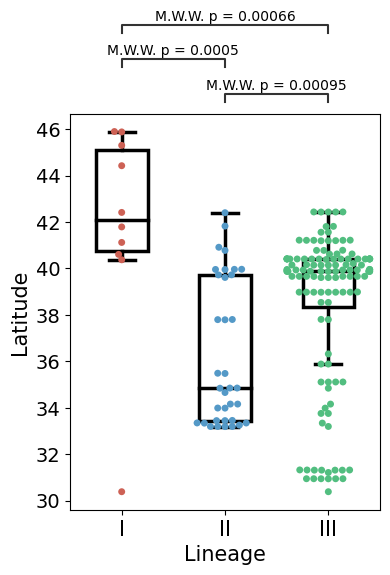

II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.604e-07 U_stat=3.394e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.158e-03 U_stat=7.600e+01
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.095e-01 U_stat=4.305e+02


/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 23.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


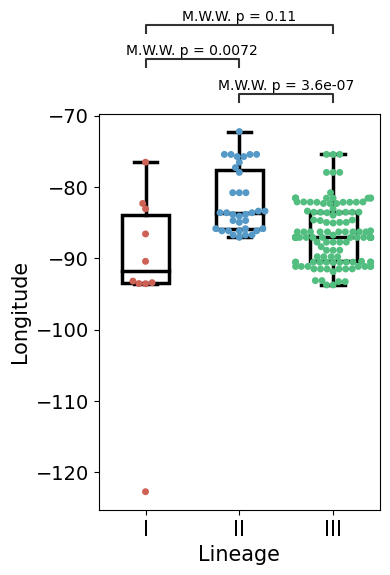

II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.473e-03 U_stat=2.898e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.944e-01 U_stat=1.950e+02
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.663e-03 U_stat=9.305e+02


/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 24.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


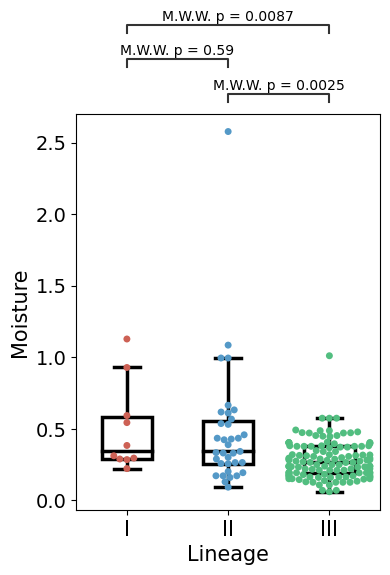

/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 18.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.600e-03 U_stat=2.802e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.604e-01 U_stat=2.090e+02
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.330e-03 U_stat=9.275e+02


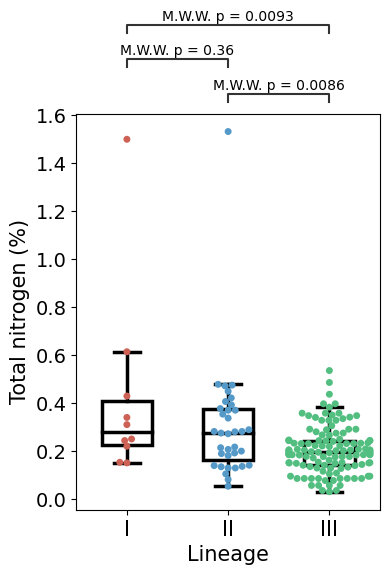

II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.930e-05 U_stat=3.128e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.527e-01 U_stat=1.470e+02
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.795e-01 U_stat=7.790e+02


/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 29.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


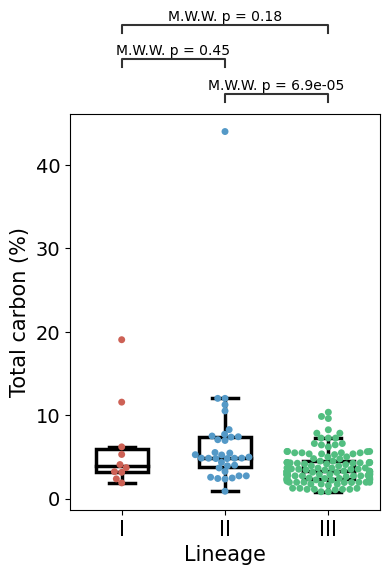

II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.813e-05 U_stat=1.202e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.043e-01 U_stat=2.350e+02
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.117e-01 U_stat=4.720e+02


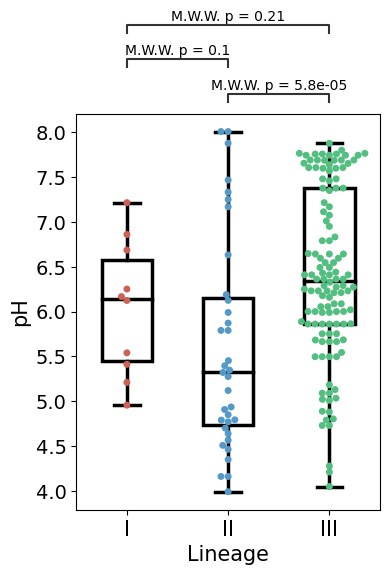

II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.628e-06 U_stat=3.300e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.135e-01 U_stat=1.560e+02
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.474e-02 U_stat=9.085e+02


/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 37.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


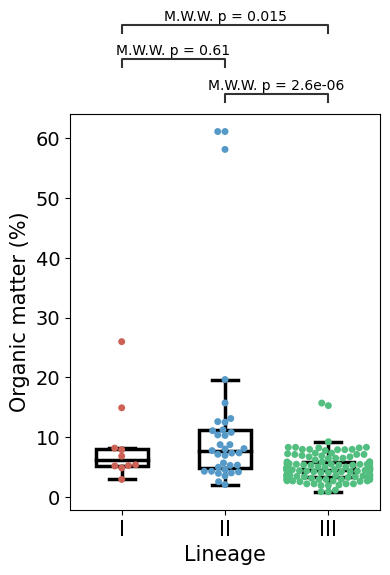

/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.396e-05 U_stat=3.216e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.262e-02 U_stat=9.100e+01
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.095e-01 U_stat=6.645e+02


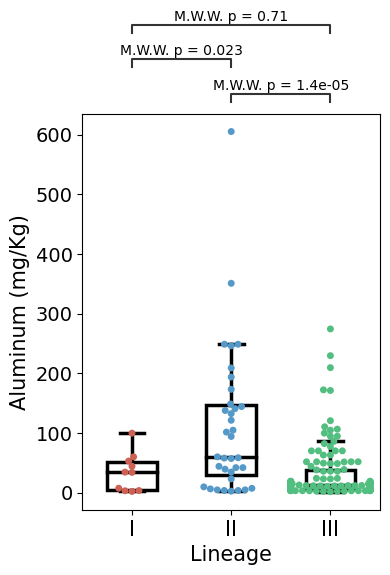

/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 11.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 39.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.470e-03 U_stat=1.466e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.155e-02 U_stat=2.680e+02
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.339e-01 U_stat=7.975e+02


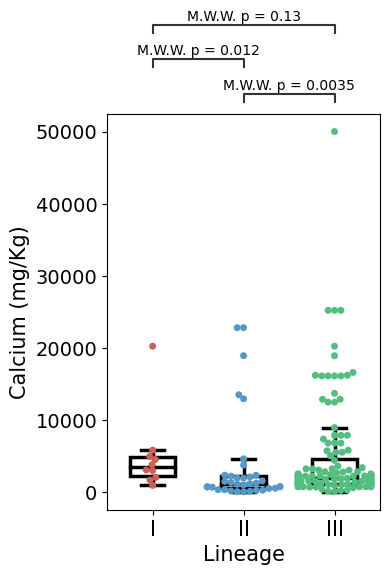

II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.471e-04 U_stat=2.982e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.206e-01 U_stat=1.450e+02
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.296e-01 U_stat=7.995e+02


/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 54.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


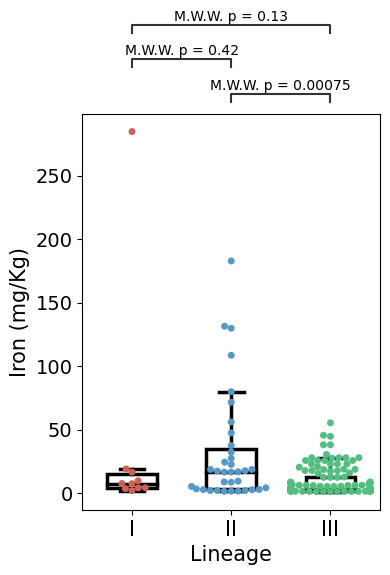

II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.194e-02 U_stat=1.720e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.462e-04 U_stat=2.990e+02
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.254e-03 U_stat=1.002e+03


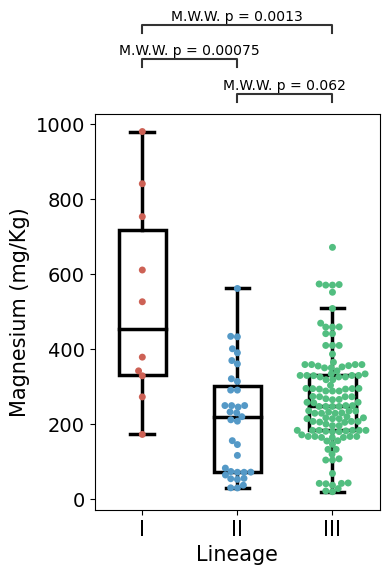

/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 25.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.968e-05 U_stat=3.106e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.527e-01 U_stat=2.030e+02
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.544e-02 U_stat=9.065e+02


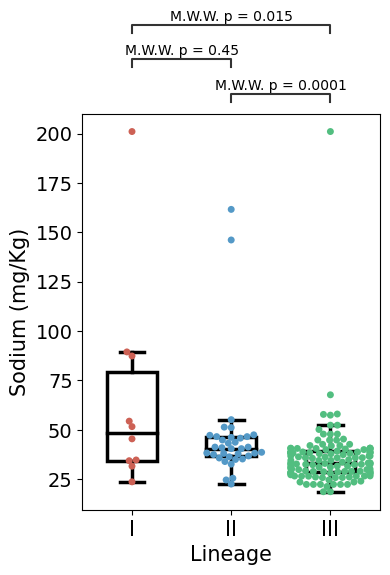

/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 22.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.941e-04 U_stat=3.008e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.591e-01 U_stat=1.680e+02
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.426e-02 (ns) U_stat=8.705e+02


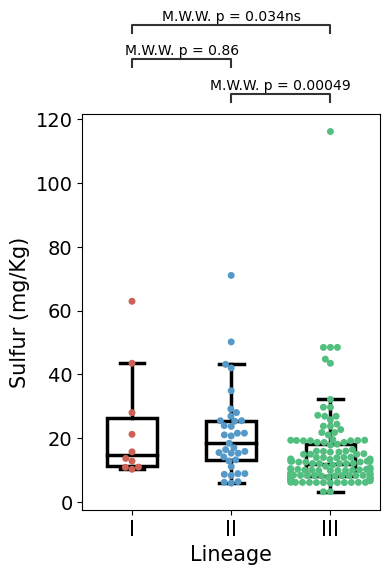

II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.794e-10 U_stat=3.660e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.320e-05 U_stat=3.150e+01
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.459e-01 U_stat=4.480e+02


/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 15.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


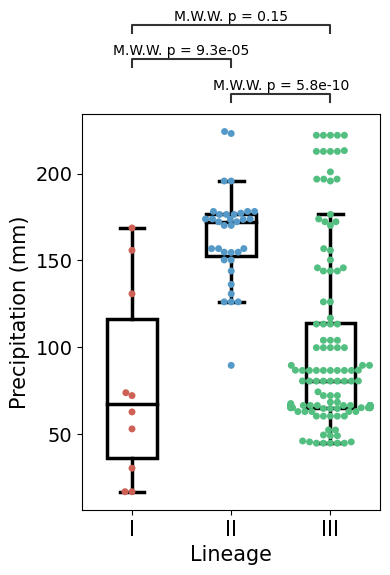

II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.936e-06 U_stat=3.280e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.675e-03 U_stat=5.950e+01
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.290e-02 U_stat=4.080e+02


/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 17.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


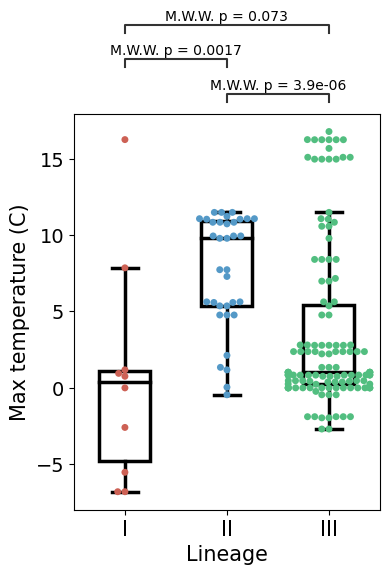

II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.359e-07 U_stat=3.354e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.283e-03 U_stat=7.450e+01
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.676e-02 U_stat=3.850e+02


/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 12.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


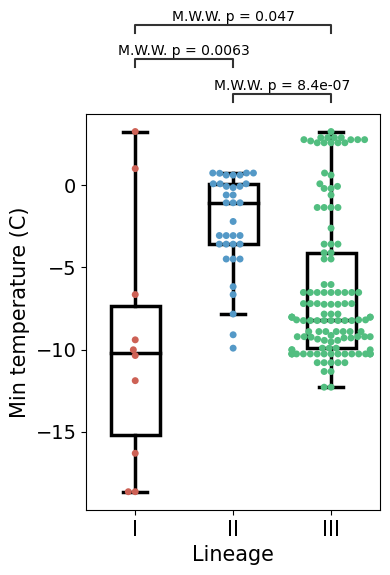

/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 31.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.510e-04 U_stat=1.310e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.389e-01 U_stat=2.105e+02
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.553e-01 U_stat=6.420e+02


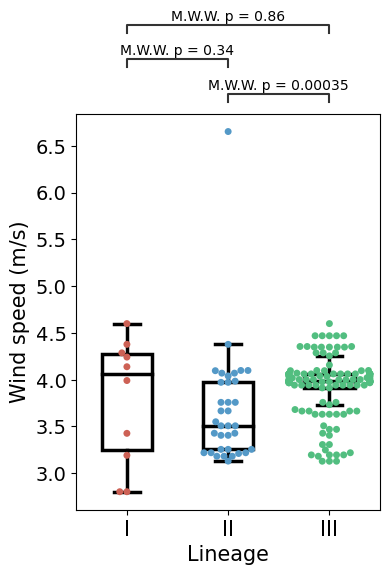

II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.691e-05 U_stat=1.210e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.517e-01 U_stat=2.280e+02
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.898e-01 U_stat=4.945e+02


/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 15.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


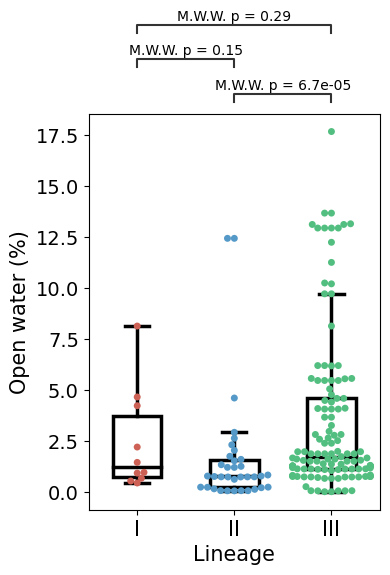

II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.968e-08 U_stat=3.456e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.972e-04 U_stat=4.200e+01
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.133e-01 U_stat=4.325e+02


/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 7.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


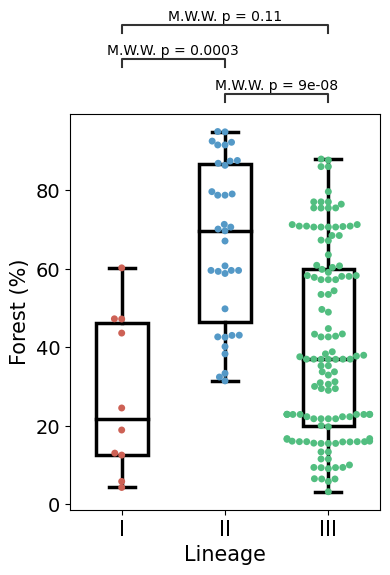

II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.202e-07 U_stat=3.444e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.552e-03 U_stat=6.400e+01
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.364e-01 U_stat=6.935e+02


/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 44.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


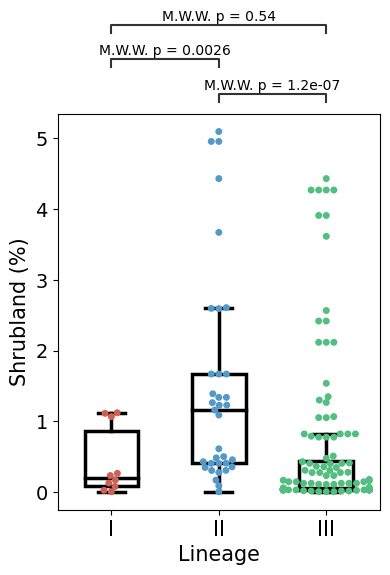

/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 28.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 22.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.102e-07 U_stat=9.390e+02
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.358e-04 U_stat=3.150e+02
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.162e-01 U_stat=7.165e+02


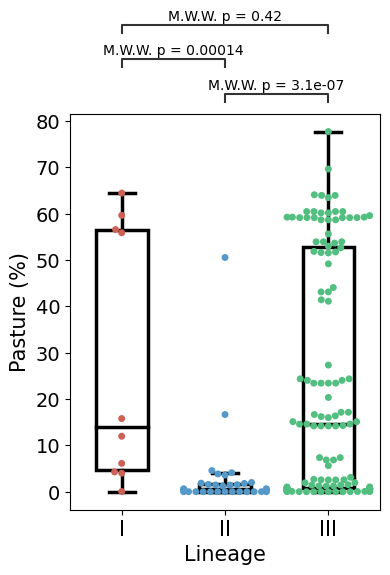

/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 25.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 45.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.497e-03 U_stat=1.536e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.335e-03 U_stat=2.930e+02
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.499e-02 U_stat=8.695e+02


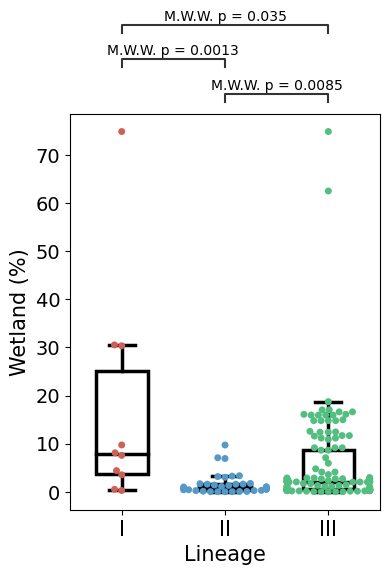

In [99]:
for key, val in sig_env.items():
    prep_gp = pd.merge(env_reset, filtered_isolate, on="Sample ID")
    prep_gp = prep_gp[[f"{key}", "Phylogroup"]]

    plot_3_box_with_mw_and_swarm(
        data=prep_gp,
        x="Phylogroup",
        y=f"{key}",
        box_pairs=[
            ("III", "II"),
            ("III", "I"),
            ("II", "I"),
        ],
        title=f"{key}",
        out_path=out_path_supp
    )

### Fig. 3b Multidimensional scaling (MDS) analysis for _Lm_ lineages based on abiotic conditions.

In [100]:
# Function for making ellipse
def plot_point_cov(points, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma ellipse based on the mean and covariance of a point
    "cloud" (points, an Nx2 array).

    Parameters
    ----------
        points : An Nx2 array of the data points.
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, linewidth=2.0, **kwargs)

    ax.add_artist(ellip)
    return ellip

In [101]:
# Filtering for samples with only one Phylogroup
monocytogenes_isolate = isolate[isolate['Species'] == 'L. monocytogenes']
filtered_isolate = monocytogenes_isolate.groupby('Sample ID').filter(lambda x: x['Phylogroup'].nunique() == 1)
filtered_isolate = filtered_isolate.drop_duplicates(subset='Sample ID')

# Reset the current index and keep it as a column
filtered_isolate = filtered_isolate.reset_index()

# Set 'Sample ID' as the new index
filtered_isolate = filtered_isolate.set_index('Sample ID')

#Filtering for monocytogenes
monocytogenes_isolate = filtered_isolate[filtered_isolate['Phylogroup'].isin(['III', 'II', 'I'])]

sample = env.copy()
merged_df_2 = pd.merge(sample, monocytogenes_isolate, left_index=True, right_index=True)
group = merged_df_2[['Phylogroup']].copy()
group.rename(columns={'Phylogroup': 'group'}, inplace=True)

In [102]:
# Use environmental variables as input for MDS
env = pd.read_csv(data_path + 'environ_all.csv', index_col=0)
env = env.dropna()
env_df = pd.merge(env, group, left_index=True, right_index=True)
env_df = env_df.drop("group", axis=1)

In [103]:
# Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(env_df) # Change to sig_env_df if wanna see only significant abiotic variable

# Compute the distance matrix
from sklearn.metrics import pairwise_distances
distance_matrix = pairwise_distances(scaled_data, metric='euclidean')

# Perform MDS
from sklearn.manifold import MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=20)
mds_coordinates = mds.fit_transform(distance_matrix)

/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [104]:
# Classify samples into groups based on presence of different lineages
mds_2d_df = pd.DataFrame(mds_coordinates).set_index(env_df.index)
mds_group = pd.merge(mds_2d_df, group, left_index=True, right_index=True)

In [105]:
# Perform PERMANOVA test on grouping
from skbio.stats.distance import permanova
from skbio.stats.distance import DistanceMatrix
from matplotlib.patches import Ellipse

grouping = list(mds_group['group'])

symmetric_distance_matrix = (distance_matrix + distance_matrix.T) / 2
symmetric_distance_matrix = DistanceMatrix(symmetric_distance_matrix, ids=env_df.index)

permanova_results = permanova(symmetric_distance_matrix, grouping, permutations=999)
print(permanova_results)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     107
number of groups                  3
test statistic             6.703212
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object


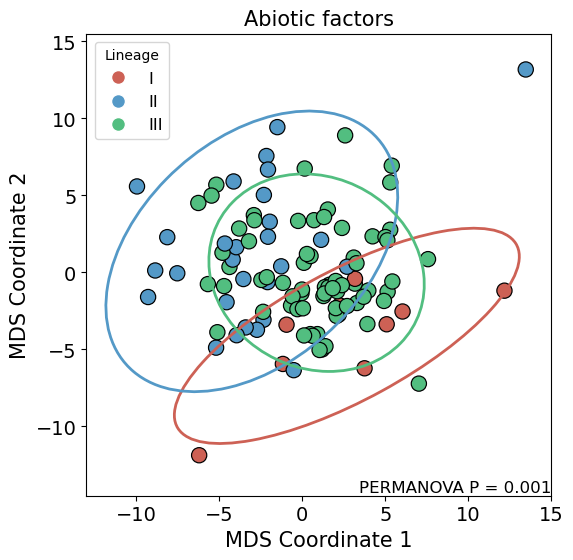

In [106]:
colors = ['#CD6155', '#5499C7', '#52BE80']
hue_order = ['I', 'II', 'III']

# Create the plot
plt.rcParams["figure.figsize"] = (6, 6)
ax = sns.scatterplot(x=0, y=1, hue='group', data=mds_group,
                     palette=colors, hue_order=hue_order,
                     s=120, edgecolor='black')

# Plotting ellipses
for lineage, color in zip(hue_order, colors):
    group_data = mds_group[mds_group['group'] == lineage][[0, 1]].values
    e = plot_point_cov(group_data, ax=ax, edgecolor=color, facecolor='none')
    e.set_label(lineage)

# Setting the plot title and labels
ax.set_title('Abiotic factors', size=15)
plt.xlabel('MDS Coordinate 1', size=15)
plt.ylabel('MDS Coordinate 2', size=15)

# Setting the plot limits
plt.xlim(-13, 15)
plt.ylim(-14.5, 15.5)

# Adding text for Permanova p value
plt.text(1, 0, f'PERMANOVA P = {permanova_results["p-value"]}', fontsize=12, ha='right', va='bottom', transform=ax.transAxes)

# Removing default legend
ax.legend_.remove()

# Creating custom legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='I', markerfacecolor='#CD6155', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w', label='II', markerfacecolor='#5499C7', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w', label='III', markerfacecolor='#52BE80', markersize=10)]

# Adding custom legend outside the plot
plt.legend(handles=legend_elements, loc='upper left', title='Lineage', fontsize=12)

plt.savefig(out_path_supp + 'fig_3b_mds_env.pdf', format='pdf', dpi=300)

# Display the plot
plt.show()

### Fig. S8. Relative abundance of bacterial phyla compared among _Lm_ lineages.

In [107]:
from scipy.stats import mannwhitneyu
from itertools import combinations
from statsmodels.stats.multitest import multipletests

def pairwise_mannwhitneyu(data, groups):
    p_values = {}
    group_combinations = combinations(groups, 2)
    
    for group1, group2 in group_combinations:
        try:
            _, p_value = mannwhitneyu(data[group1], data[group2], alternative='two-sided')
            p_values[f"{group1}_{group2}"] = p_value
        except ValueError as e:
            print(f"Error comparing {group1} and {group2}: {e}")
    
    return p_values

def assign_labels(p_values, alpha=0.05):
    groups = sorted(set(group for pair in p_values.keys() for group in pair.split('_')))
    labels = {group: set('a') for group in groups}
    
    def get_p_value(g1, g2):
        pair = f"{g1}_{g2}" if g1 < g2 else f"{g2}_{g1}"
        return p_values.get(pair, 0)
    
    for i, group1 in enumerate(groups):
        for group2 in groups[i+1:]:
            if get_p_value(group1, group2) < alpha:
                if labels[group1] == labels[group2]:
                    new_label = chr(ord(max(labels[group2])) + 1)
                    labels[group2] = set(new_label)
                    
    for group in groups:
        if all(get_p_value(group, other) >= alpha for other in groups if other != group):
            labels[group] = set(''.join(sorted(set.union(*labels.values()))))
    
    result_labels = {group: ''.join(sorted(label)) for group, label in labels.items()}
    print("Final labels:", result_labels)
    return result_labels

# Function for FDR correction
def fdr(p_value):
    p_v = []
    for c_key in p_value:
        p_v.append(p_value[c_key][0])
    array = np.array(p_v)
    rej, pvalscorr, _, _ = smt.multipletests(array, method = 'fdr_bh')
    p_corr = pvalscorr.tolist()
    n_p = 0
    fdr = {}
    for c_key in p_value:
        fdr[c_key] = p_corr[n_p]
        n_p = n_p + 1
    return fdr

In [108]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
from collections import defaultdict

def KW_test(isolate, env, plot_title, out_path):
    """
    Performs Kruskal-Wallis tests, applies FDR correction, performs pairwise Mann-Whitney U tests with FDR correction,
    assigns labels to corrected p-values, and generates plots based on the results. Exports DataFrame of corrected
    pairwise p-values with labels appended.

    Parameters:
    - isolate (DataFrame): DataFrame containing isolate information.
    - env (DataFrame): DataFrame containing environmental data.
    - plot_title (str): Title for the plots.
    - out_path (str): Output path for saving the plots.

    Returns:
    - pairwise_pvals_corrected_df (DataFrame): DataFrame containing FDR-corrected pairwise Mann-Whitney U test p-values 
      and their labels for significant variables.
    """
    # Assign groups for samples positive for LM and negative for LM
    monocytogenes_isolate = isolate[isolate['Species'] == 'L. monocytogenes']
    monocytogenes_isolate_L1 = monocytogenes_isolate[monocytogenes_isolate['Phylogroup'] == 'III']
    monocytogenes_isolate_L2 = monocytogenes_isolate[monocytogenes_isolate['Phylogroup'] == 'II']
    monocytogenes_isolate_L3 = monocytogenes_isolate[monocytogenes_isolate['Phylogroup'] == 'I']

    # Perform KW tests
    pval = defaultdict(list)
    for columnName, columnData in env.items():
        L1 = columnData[columnData.index.isin(monocytogenes_isolate_L1["Sample ID"])]
        L2 = columnData[columnData.index.isin(monocytogenes_isolate_L2["Sample ID"])]
        L3 = columnData[columnData.index.isin(monocytogenes_isolate_L3["Sample ID"])]

        # Check if all values in the column are identical
        if len(set(L1)) > 1 and len(set(L2)) > 1 and len(set(L3)) > 1:
            # Perform the Kruskal-Wallis test only if there is variation in the column
            u, prob = kruskal(L1, L2, L3)
            pval[columnName].append(prob)
        else:
            # If all values are identical, set p-value to 1.0
            pval[columnName].append(np.float64(1.0))

    # Apply FDR correction to identify significant variables
    sig_env = fdr_sig(pval)
    n_sig_env = len(sig_env)

    print("Number of significant variables: ", n_sig_env)
    for key, value in sig_env.items():
        print(f'{key}: {value}')

    # Reset index on the env DataFrame so that we can merge based on Sample ID
    env_reset = env.reset_index()
    env_reset = env_reset.rename(columns={'index': 'Sample ID'})

    # Filter the isolate DataFrame to keep only rows with 'LM lineage III', 'LM lineage II', 'LM lineage I' in 'Phylogroup'
    filtered_isolate = isolate[isolate['Phylogroup'].isin(['III', 'II', 'I'])]

    heatmap_df = pd.DataFrame(columns=['I', 'II', 'III'])  # Initialize an empty DataFrame for heatmap
    pairwise_pvals = {}  # Initialize a dictionary to store pairwise Mann-Whitney U test results

    for key, val in sig_env.items():
        prep_gp = pd.merge(env_reset, filtered_isolate, on='Sample ID')
        prep_gp = prep_gp[[f"{key}", 'Phylogroup']]

        if n_sig_env > 10:
            # Calculate mean values for positive and negative groups and append to heatmap_df
            mean_L1 = prep_gp[prep_gp['Phylogroup'] == 'III'][key].mean()
            mean_L2 = prep_gp[prep_gp['Phylogroup'] == 'II'][key].mean()
            mean_L3 = prep_gp[prep_gp['Phylogroup'] == 'I'][key].mean()

            heatmap_df.loc[key] = [mean_L1, mean_L2, mean_L3]

        # Perform pairwise Mann-Whitney U tests
        L1_vals = prep_gp[prep_gp['Phylogroup'] == 'III'][key]
        L2_vals = prep_gp[prep_gp['Phylogroup'] == 'II'][key]
        L3_vals = prep_gp[prep_gp['Phylogroup'] == 'I'][key]

        # Initialize dictionary to store pairwise p-values for the current variable
        pairwise_pvals[key] = pairwise_mannwhitneyu({'III': L1_vals, 'II': L2_vals, 'I': L3_vals}, ['I', 'II', 'III'])

    # Apply FDR correction for each row's pairwise p-values
    pairwise_pvals_corrected = {}
    for column, p_values in pairwise_pvals.items():
        pvals = list(p_values.values())

        # Apply FDR correction
        _, pvals_corrected, _, _ = multipletests(pvals, method='fdr_bh', alpha=0.05)

        # Store corrected p-values
        pairs_with_p_less_than_0_05 = {pair: pvals_corrected[i] for i, pair in enumerate(p_values.keys())}
        pairwise_pvals_corrected[column] = pairs_with_p_less_than_0_05

    # Convert the corrected pairwise p-values to DataFrame
    pairwise_pvals_corrected_df = pd.DataFrame.from_dict(pairwise_pvals_corrected, orient='index')

    # Assign labels to the corrected pairwise p-values
    labels_assigned = {}
    for column, p_values in pairwise_pvals_corrected.items():
        labels_assigned[column] = assign_labels(p_values)

    # Convert labels to DataFrame and transpose
    assigned_df = pd.DataFrame(labels_assigned).transpose()

    # Rename columns in pairwise_pvals_corrected_df
    assigned_df = assigned_df.rename(columns={'I': 'I_y', 'II': 'II_y', 'III': 'III_y'})

    # Merge assigned_annotation with heatmap_df
    heatmap_df = heatmap_df.merge(assigned_df, how='left', left_index=True, right_index=True)

    # Iterate over rows in the DataFrame to get rid of cases where there are the same letters - significant in KW but not pairwise MW
    for index, row in heatmap_df.iterrows():
        if row['I_y'] == row['II_y'] == row['III_y']:
            heatmap_df.at[index, 'I_y'] = ''
            heatmap_df.at[index, 'II_y'] = ''
            heatmap_df.at[index, 'III_y'] = ''

    # Export heatmap with annotations
    if n_sig_env > 10:
        plot_heatmap_mean_log_annot(heatmap_df, assigned_df, plot_title, out_path=out_path)
    else:
        # Plot boxplots for variables with fewer significant results
        for key, val in sig_env.items():
            prep_gp = pd.merge(env_reset, filtered_isolate, on='Sample ID')
            prep_gp = prep_gp[[f"{key}", 'Phylogroup']]
            plot_3_box_with_mw_and_swarm(data=prep_gp, x='Phylogroup', y=f"{key}",
                                         box_pairs=[('I', 'II'), ('I', 'III'), ('II', 'III')],
                                         title=f"{key}", out_path=out_path)

    return pd.concat([pairwise_pvals_corrected_df, assigned_df], axis=1)

In [109]:
isolate = pd.read_csv(data_path + "Listeria_genomes.csv", index_col=0)

rename_mapping = {
    'L1': 'III',
    'L2': 'II',
    'L3': 'I',
}
isolate['Phylogroup'] = isolate['Phylogroup'].apply(lambda x: rename_mapping.get(x, x))

phylum_count_data = pd.read_csv(data_path + "phylum_count.csv")
phylum_count_data_cleaned = data_cleaner(phylum_count_data, sep = "p__")
phylum_count_data_cleaned.set_index('index', inplace=True)
phylum_count_data_cleaned = phylum_count_data_cleaned.dropna()

In [110]:
phylum_count_data_cleaned_t = phylum_count_data_cleaned.transpose()
len(phylum_count_data_cleaned_t)

28

Number of significant variables:  6
Acidobacteria: 0.004146504728999427
Nitrospirae: 0.002950736040027008
Planctomycetes: 0.002950736040027008
Proteobacteria: 0.004146504728999427
WPS-2: 0.002950736040027008
WS3: 0.03940908264529922
Final labels: {'I': 'ab', 'II': 'a', 'III': 'b'}
Final labels: {'I': 'ab', 'II': 'a', 'III': 'b'}
Final labels: {'I': 'a', 'II': 'a', 'III': 'b'}
Final labels: {'I': 'a', 'II': 'b', 'III': 'a'}
Final labels: {'I': 'a', 'II': 'b', 'III': 'a'}
Final labels: {'I': 'ab', 'II': 'a', 'III': 'b'}
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.429e-01 U_stat=2.930e+02
II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.962e-06 U_stat=1.162e+03
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.394e-01 U_stat=5.950e+02


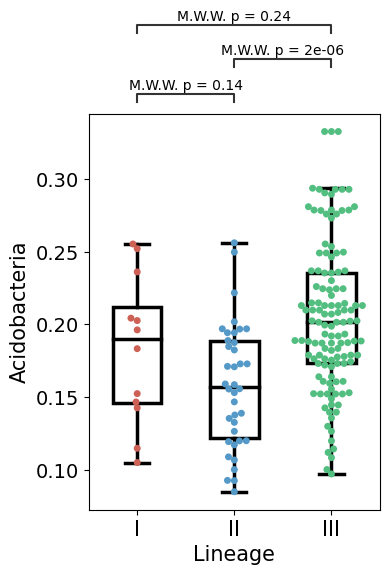

I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.807e-02 (ns) U_stat=3.190e+02
II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.327e-06 U_stat=1.144e+03
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.052e-01 U_stat=6.620e+02


/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 5.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


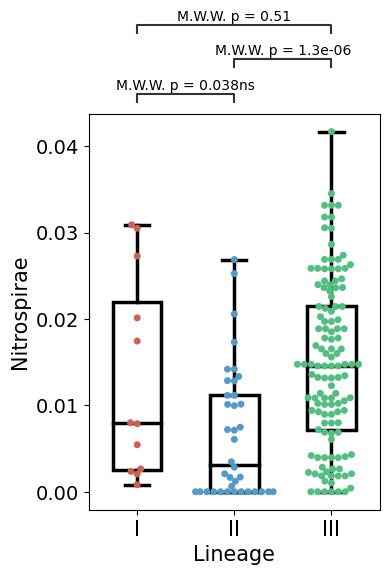

I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.498e-02 U_stat=1.540e+02
II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.674e-07 U_stat=3.708e+03
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.769e-02 U_stat=1.062e+03


/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 7.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


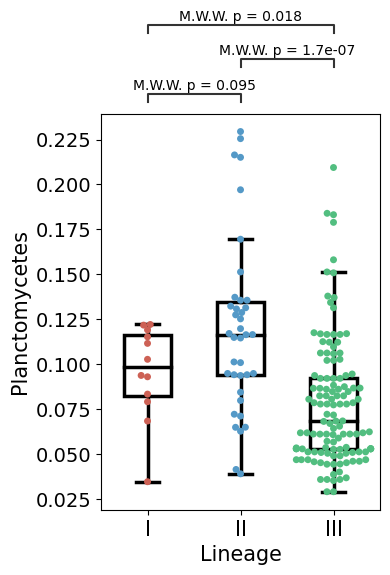

I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.653e-03 U_stat=8.900e+01
II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.882e-05 U_stat=3.466e+03
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.076e-01 U_stat=5.840e+02


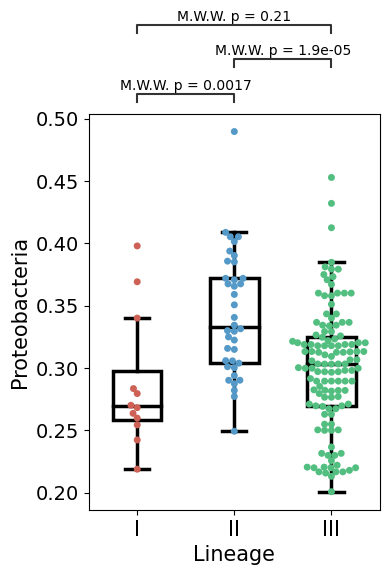

I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.873e-03 U_stat=1.130e+02
II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.521e-06 U_stat=3.445e+03
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.415e-01 U_stat=7.150e+02


/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 66.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


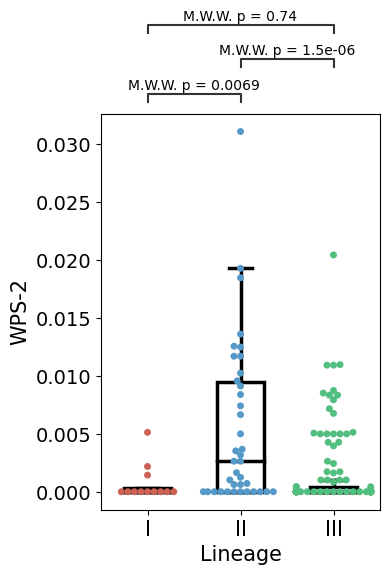

/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 21.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 12.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.887e-02 (ns) U_stat=3.160e+02
II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.166e-04 U_stat=1.540e+03
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.664e-01 U_stat=7.440e+02


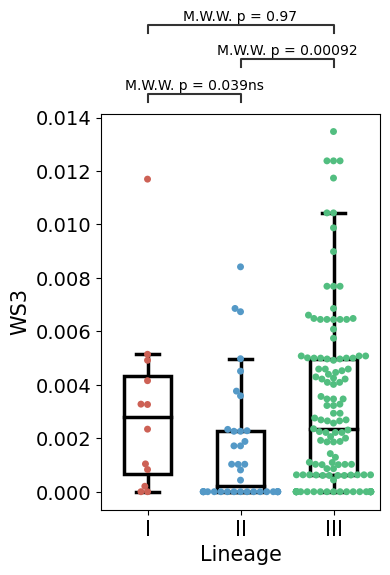

I_II     I_III        II_III I_y II_y III_y
Acidobacteria   0.214276  0.239390  5.884998e-06  ab    a     b
Nitrospirae     0.057110  0.505197  3.979798e-06  ab    a     b
Planctomycetes  0.094976  0.026534  5.022897e-07   a    a     b
Proteobacteria  0.002480  0.207570  5.645716e-05   a    b     a
WPS-2           0.010310  0.741463  4.563146e-06   a    b     a
WS3             0.058306  0.966434  2.749910e-03  ab    a     b

In [111]:
KW_test(isolate, phylum_count_data_cleaned, "Phylum relative abundance in samples pos for L1 vs L2 vs L3", out_path=out_path_supp)

### Fig. 3c MDS analysis for _Lm_ lineages based on bacterial community composition using weighted UniFrac distances based on OTUs.

In [112]:
# Filtering for Samples with only one Phylogroup
otus_data = pd.read_excel(data_path + "rarified_OTU_table-with-taxonomy_processed.xlsx", index_col=0, header=1)
otus_data = otus_data.dropna()

monocytogenes_isolate = isolate[isolate['Species'] == 'L. monocytogenes']
filtered_isolate = monocytogenes_isolate.groupby('Sample ID').filter(lambda x: x['Phylogroup'].nunique() == 1)
filtered_isolate = filtered_isolate.drop_duplicates(subset='Sample ID')

# Reset the current index and keep it as a column
filtered_isolate = filtered_isolate.reset_index()

# Set 'Sample ID' as the new index
filtered_isolate = filtered_isolate.set_index('Sample ID')

#Filtering for monocytogenes
monocytogenes_isolate = filtered_isolate[filtered_isolate['Phylogroup'].isin(['III', 'II', 'I'])]

sample = otus_data.copy()
merged_df_2 = pd.merge(sample, monocytogenes_isolate, left_index=True, right_index=True)
group = merged_df_2[['Phylogroup']].copy()
group.rename(columns={'Phylogroup': 'group'}, inplace=True)
group.groupby('group').size()

group
I      10
II     31
III    70
dtype: int64

In [113]:
# MDS using weighted UniFrac distance
weighted_unifrac_dist = pd.read_csv(data_path + "OTU_weighted_unifrac_distance_matrix.tsv", sep='\t')

# Filter rows 
filtered_weighted_unifrac_dist = weighted_unifrac_dist[weighted_unifrac_dist['Unnamed: 0'].isin(group.index)]
filtered_weighted_unifrac_dist = filtered_weighted_unifrac_dist[['Unnamed: 0'] + [col for col in filtered_weighted_unifrac_dist.columns if col in group.index]]
filtered_weighted_unifrac_dist.shape

(111, 112)

In [114]:
from sklearn.manifold import MDS

# Compute the distance matrix
distance_matrix = filtered_weighted_unifrac_dist.drop(columns=['Unnamed: 0']).to_numpy()

# Perform MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=20)
mds_coordinates = mds.fit_transform(distance_matrix)

# Classify samples into groups based on presence of Lm lineages
mds_2d_df = pd.DataFrame(mds_coordinates).set_index(filtered_weighted_unifrac_dist['Unnamed: 0'])
mds_group = pd.merge(mds_2d_df, group, left_index=True, right_index=True)
#print (mds_group['group'].value_counts())
#mds_group

/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [115]:
# Perform PERMANOVA test on grouping
from skbio.stats.distance import permanova
from skbio.stats.distance import DistanceMatrix
from matplotlib.patches import Ellipse

grouping = list(mds_group['group'])
symmetric_distance_matrix = (distance_matrix + distance_matrix.T) / 2
symmetric_distance_matrix = DistanceMatrix(symmetric_distance_matrix, ids=filtered_weighted_unifrac_dist['Unnamed: 0'])

permanova_results = permanova(symmetric_distance_matrix, grouping, permutations=999)
print(permanova_results)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     111
number of groups                  3
test statistic             5.829262
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object


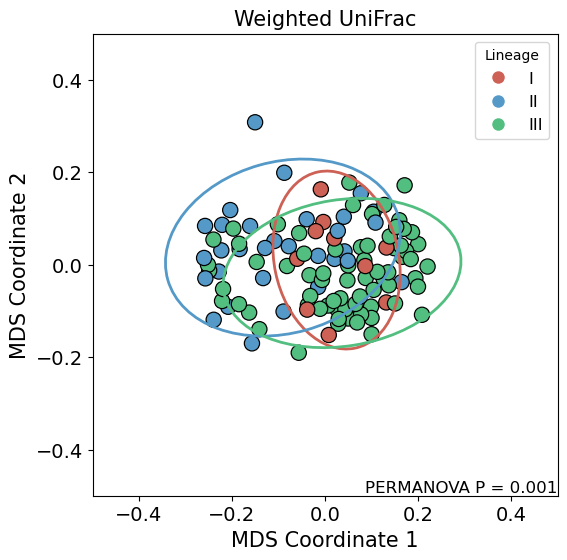

In [116]:
colors = ['#CD6155', '#5499C7', '#52BE80']
hue_order = ['I', 'II', 'III']

# Create the plot
plt.rcParams["figure.figsize"] = (6, 6)
ax = sns.scatterplot(x=0, y=1, hue='group', data=mds_group,
                     palette=colors, hue_order=hue_order,
                     s=120, edgecolor='black')

# Plotting ellipses
for lineage, color in zip(hue_order, colors):
    group_data = mds_group[mds_group['group'] == lineage][[0, 1]].values
    e = plot_point_cov(group_data, ax=ax, edgecolor=color, facecolor='none')
    e.set_label(lineage)

# Setting the plot title and labels
ax.set_title('Weighted UniFrac', size=15)
plt.xlabel('MDS Coordinate 1', size=15)
plt.ylabel('MDS Coordinate 2', size=15)

# Setting the plot limits
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)

# Adding text for PERMANOVA p value
plt.text(1, 0, f'PERMANOVA P = {permanova_results["p-value"]}', fontsize=12, ha='right', va='bottom', transform=ax.transAxes)

# Removing default legend
ax.legend_.remove()

# Creating custom legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='I', markerfacecolor='#CD6155', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w', label='II', markerfacecolor='#5499C7', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w', label='III', markerfacecolor='#52BE80', markersize=10)]

# Adding custom legend outside the plot
plt.legend(handles=legend_elements, loc='upper right', title='Lineage', fontsize=12)

plt.savefig(out_path_supp + 'fig_3c_mds_unifrac_otu.pdf', format='pdf', dpi=300)

# Display the plot
plt.show()

### Fig. 3d Pangenome sizes of _Lm_ lineages

In [117]:
isolate = pd.read_csv(data_path + "Listeria_genomes.csv", index_col=0)

# renaming L1, L2, L3 to LM lineage III, LM lineage II, LM lineage I respectively
rename_mapping = {
    "L1": "III",
    "L2": "II",
    "L3": "I",
}
isolate["Phylogroup"] = isolate["Phylogroup"].apply(lambda x: rename_mapping.get(x, x))

# Filtering for L. monocytogenes
lm_isolate = isolate[isolate["Species"] == "L. monocytogenes"]
lm_isolate = lm_isolate.set_index('Isolate ID')

lm_1 = list(lm_isolate[lm_isolate["Phylogroup"] == "I"].index)
lm_2 = list(lm_isolate[lm_isolate["Phylogroup"] == "II"].index)
lm_3 = list(lm_isolate[lm_isolate["Phylogroup"] == "III"].index)
lm_all = lm_isolate.index.tolist()

In [118]:
lm_1_pan = pd.read_csv(out_path_oth + "lm_1_pangenome.csv", index_col=0)
lm_2_pan = pd.read_csv(out_path_oth + "lm_2_pangenome.csv", index_col=0)
lm_3_pan = pd.read_csv(out_path_oth + "lm_3_pangenome.csv", index_col=0) 
lm_1_2_pan = pd.read_csv(out_path_oth + "lm_1_2_pangenome.csv", index_col=0)
lm_1_3_pan = pd.read_csv(out_path_oth + "lm_1_3_pangenome.csv", index_col=0)
lm_2_3_pan = pd.read_csv(out_path_oth + "lm_2_3_pangenome.csv", index_col=0)
lm_1_2_3_pan = pd.read_csv(out_path_oth + "overall_pangenome.csv", index_col=0)

In [119]:
print(lm_1_pan['cat'].value_counts())
print(lm_2_pan['cat'].value_counts())
print(lm_3_pan['cat'].value_counts())

cat
Core         2560
Accessory     913
Name: count, dtype: int64
cat
Core         2468
Accessory    1695
Name: count, dtype: int64
cat
Accessory    3034
Core         2366
Name: count, dtype: int64


In [120]:
# Observed and predicted pangenome size of Lm lineages
# Reading the dataframe
lm_1_pan = pd.read_csv(out_path_oth + "lm_1_pangenome.csv", index_col=0)
lm_2_pan = pd.read_csv(out_path_oth + "lm_2_pangenome.csv", index_col=0)
lm_3_pan = pd.read_csv(out_path_oth + "lm_3_pangenome.csv", index_col=0)

# Calculating the expected pangenome size using power law function (Extended Data Fig. 7 in ref: https://doi.org/10.1038/s41564-021-00935-7)
# Calculate the predicted pangenome size for 100 genomes - see if the trend is the consistent with the observed ones
pan_exp_lm_1 = 2723 * (100 ** 0.093)
pan_exp_lm_2 = 2618 * (100 ** 0.122)
pan_exp_lm_3 = 2490 * (100 ** 0.159)

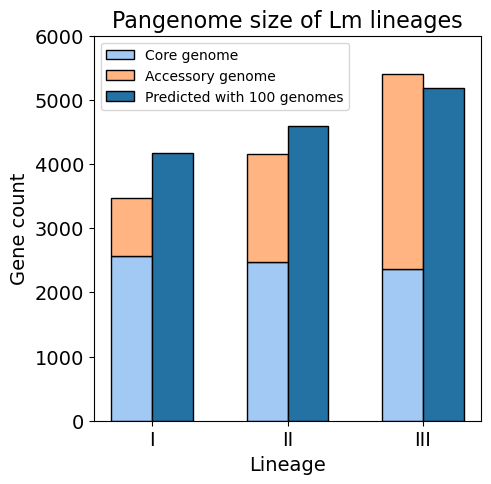

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define colors
palette = sns.color_palette("pastel")

# Define lineage labels
lineages = ['I', 'II', 'III']

# Get Core and Accessory counts for each lineage
core_counts = [
    lm_1_pan['cat'].value_counts().get('Core', 0),  
    lm_2_pan['cat'].value_counts().get('Core', 0),  
    lm_3_pan['cat'].value_counts().get('Core', 0)   
]

accessory_counts = [
    lm_1_pan['cat'].value_counts().get('Accessory', 0),  
    lm_2_pan['cat'].value_counts().get('Accessory', 0),  
    lm_3_pan['cat'].value_counts().get('Accessory', 0)   
]

# Define expected counts (replace with actual expected values)
expected_counts = [pan_exp_lm_1, pan_exp_lm_2, pan_exp_lm_3]  

# Define bar width and positions
bar_width = 0.3
r1 = np.arange(len(lineages))  # Positions for Core+Accessory bars
r2 = r1 + bar_width  # Positions for Expected bars

# Plotting
plt.figure(figsize=(5, 5))

# Plot Core+Accessory as stacked bars
plt.bar(r1, core_counts, color=palette[0], width=bar_width, edgecolor='black', label='Core genome')
plt.bar(r1, accessory_counts, color=palette[1], width=bar_width, edgecolor='black', label='Accessory genome', bottom=core_counts)

# Plot Expected values as separate bars next to Core+Accessory bars
plt.bar(r2, expected_counts, color='#2471A3', width=bar_width, edgecolor='#000000', label='Predicted with 100 genomes')

# Labels and ticks
plt.xlabel('Lineage', fontsize=14)
plt.xticks(r1 + bar_width / 2, lineages)  # Align labels between groups
plt.ylabel('Gene count', fontsize=14)
plt.ylim(0, 6000)
plt.title('Pangenome size of Lm lineages', fontsize=16)

# Legend
plt.legend(loc="upper left")

# Save and show
plt.savefig(out_path_3 + 'fig_3d_core_accessory_expected_by_lineage.pdf', bbox_inches='tight', dpi=600)
plt.show()


### Fig. 3e Enrichment of COGs among lineage-associated genes.

In [122]:
## Load input data
env = pd.read_csv(data_path + 'environ_all.csv', index_col=0)
env = env.dropna()

isolate = pd.read_csv(data_path + "Listeria_genomes.csv", index_col=0)
rename_mapping = {
    "L1": "III",
    "L2": "II",
    "L3": "I",
}
isolate["Phylogroup"] = isolate["Phylogroup"].apply(lambda x: rename_mapping.get(x, x))

lm_isolate = isolate[isolate["Species"] == "L. monocytogenes"]
lm_isolate = lm_isolate.set_index('Isolate ID')

lm_1 = list(lm_isolate[lm_isolate["Phylogroup"] == "I"].index)
lm_2 = list(lm_isolate[lm_isolate["Phylogroup"] == "II"].index)
lm_3 = list(lm_isolate[lm_isolate["Phylogroup"] == "III"].index)
lm_all = lm_isolate.index.tolist()

gen_pre_abs = pd.read_csv(data_path + "gene_pre_abs_lm.csv", index_col=0)

gen_annot = pd.read_csv(data_path + "gene_func_annot.csv")
gen_annot.rename(columns={" COG Functional Category": "COG Functional Category"}, inplace=True)
gen_annot.rename(columns={" query_name": "query_name"}, inplace=True)
gen_annot = gen_annot[['query_name', 'COG Functional Category']]

# In gen_annot Replace '0' and Nan with 'S' - All 0, Nan and S are indicating 'Function unknown' 
gen_annot['COG Functional Category'] = gen_annot['COG Functional Category'].replace('0', 'S')
gen_annot['COG Functional Category'] = gen_annot['COG Functional Category'].fillna('S')

In [123]:
# Identifying the genes significantly different among Lm lineages

import pandas as pd
import numpy as np
from statsmodels.stats.contingency_tables import Table
from collections import defaultdict
import statsmodels.stats.multitest as smt

# Create a dictionary to store p-values
pval = defaultdict(list)

# Function to perform Fisher's Exact Test for a 2x3 table
def fisher_exact_2x3(table):
    # Using statsmodels' Table class for Fisher's Exact Test
    tbl = Table(table)
    result = tbl.test_nominal_association()
    p_value = result.pvalue
    return p_value

# Perform Fisher's Exact Test for each gene
for gene in gen_pre_abs.index:
    # Create a contingency table for each gene
    group_1 = gen_pre_abs.loc[gene, gen_pre_abs.columns.isin(lm_1)]
    group_2 = gen_pre_abs.loc[gene, gen_pre_abs.columns.isin(lm_2)]
    group_3 = gen_pre_abs.loc[gene, gen_pre_abs.columns.isin(lm_3)]
    
    # Count the presence (1) and absence (0) for each group
    contingency_table = [
        [sum(group_1 == 1), sum(group_2 == 1), sum(group_3 == 1)],
        [sum(group_1 == 0), sum(group_2 == 0), sum(group_3 == 0)]
    ]
    
    # Perform Fisher's Exact Test
    p = fisher_exact_2x3(contingency_table)
    
    # Store the p-value
    pval[gene].append(p)


sig_gene = fdr_sig(pval)

# Convert 'sig_gene' to a DataFrame
sig_gene_df = pd.DataFrame.from_dict(sig_gene, orient='index', columns=['p_value'])

# Save the DataFrame to a CSV file
sig_gene_df.to_csv(out_path_supp + 'sig_gene.csv', index_label='gene')

In [124]:
# Annotating COG for the gene that is significantly different among Lm lineages (sig_gene)
# Convert the sig_gene dictionary to a DataFrame
sig_gene_df = pd.DataFrame(sig_gene.items(), columns=['Gene', 'Corrected p-value']).set_index('Gene')

# Merge significant genes with their corresponding COG Functional Category from gen_annot
gen_annot = gen_annot.set_index('query_name')
sig_gene_annotated = sig_gene_df.merge(gen_annot, left_index=True, right_index=True, how='left')

In [125]:
# Annotating COG for the gene that is significantly different among Lm lineages (sig_gene)
# Convert the sig_gene dictionary to a DataFrame
sig_gene_df = pd.DataFrame(sig_gene.items(), columns=['Gene', 'Corrected p-value']).set_index('Gene')

# Merge significant genes with their corresponding COG Functional Category from gen_annot
#gen_annot = gen_annot.set_index('query_name')
sig_gene_annotated = sig_gene_df.merge(gen_annot, left_index=True, right_index=True, how='left')

In [126]:
# Convert 'COG Functional Category' column to lists of individual characters
sig_gene_annotated['COG Functional Category'] = sig_gene_annotated['COG Functional Category'].apply(
    lambda x: [char.upper() for char in x if char.isalpha()]
)

# Create a long list of individual characters
cog_list = [char for sublist in sig_gene_annotated['COG Functional Category'] for char in sublist]

# Count the occurrences of each character
cog_series = pd.Series(cog_list)

In [127]:
# Count occurrences of each unique COG from the overall dataframe (N)
cog = gen_pre_abs.merge(gen_annot, left_index=True, right_index=True, how='left')

# Apply the function to split the rows - spliting genes (rows) that have >1 COG
cog_split = split_rows(cog, 'COG Functional Category')

# calculate the expected proportion for each COG
prop_exp = cog_split['COG Functional Category'].value_counts(normalize=True).to_frame(name='Proportion')

# calculate the observed proportion for each significant COG
count_sig_cog = cog_series.value_counts(normalize=False).to_frame(name='Count')

In [128]:
# Perform the enrichment analysis
sig_cog_enrich = enrichment_analysis(count_sig_cog, prop_exp)

In [129]:
# Prepare the dataframe for bubble plot visualization
sig_cog_enrich_count = pd.merge(sig_cog_enrich, count_sig_cog, left_index = True, right_index = True)
sig_cog_enrich_count = sig_cog_enrich_count.reset_index(names=['COG functional category']).sort_values(by="Enrichment index", ascending=False)
sig_cog_enrich_count = sig_cog_enrich_count[sig_cog_enrich_count['COG functional category'] != 'S']

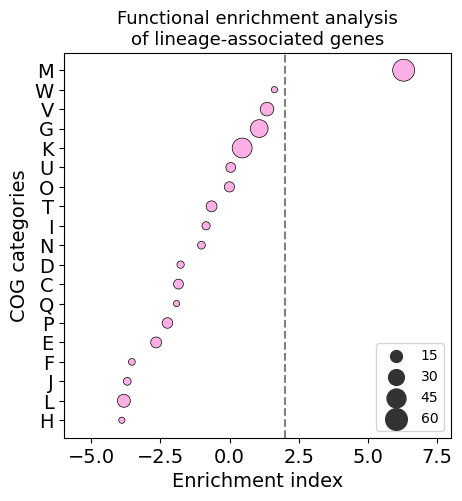

In [130]:
# Make a bubble plot
plt.rcParams["figure.figsize"] = (5, 5)

# Use a scatter plot with varying sizes and colors
bubble_plot = sns.scatterplot(
    data=sig_cog_enrich_count,
    x='Enrichment index',
    y='COG functional category',
    size='Count',
    color='#FAB0E4',
    sizes=(20, 250),  # Adjust the range of bubble sizes
    alpha=1,
    edgecolor='black',
    linewidth=0.5,
)

#plt.axvline(x=-2, color='grey', linestyle='--')
plt.axvline(x=2, color='grey', linestyle='--')
plt.title('Functional enrichment analysis\nof lineage-associated genes', size = 13)
plt.xlabel('Enrichment index', size = 14)
plt.ylabel('COG categories', size = 14)
plt.legend(loc="lower right", bbox_to_anchor=(1, 0))
plt.xlim(-6, 8)

plt.savefig(out_path_3 + 'fig_3e_enrich.pdf', bbox_inches='tight', dpi=600)
plt.show()

### Fig. 3f; Fig. S9b Comparison of genome size, GC content, and MGEs among _Lm_ lineages

In [131]:
# Load input data
mge = pd.read_csv(data_path_lm + "lm_env_mge.csv")
mge = mge.dropna()
mge.rename(columns={"is_prop": "IS per genome (%)"}, inplace=True)
mge.rename(columns={"tn_prop": "Transposons per genome (%)"}, inplace=True)
mge.rename(columns={"phastest_prop": "Prophage per genome (%)"}, inplace=True)
mge.rename(columns={"plasmid_cnt": "Plasmid count (n)"}, inplace=True)
mge.set_index("Isolate ID", inplace=True)
mge = mge[['Genome size (bp)', 'GC (%)', 'IS per genome (%)', 'Transposons per genome (%)', 'Prophage per genome (%)', 'Plasmid count (n)']]
mge_richness = mge.merge(gen_pre_abs_t[['richness']], left_index=True, right_index=True, how='left')
mge_richness_reset = mge_richness.reset_index()

isolate = pd.read_csv(data_path + "Listeria_genomes.csv", index_col=0)
rename_mapping = {
    "L1": "III",
    "L2": "II",
    "L3": "I",
}
isolate["Phylogroup"] = isolate["Phylogroup"].apply(lambda x: rename_mapping.get(x, x))
isolate = isolate.drop(columns=["Genome size (bp)", "GC (%)"])
filtered_isolate = isolate[isolate["Phylogroup"].isin(["III", "II", "I"])]

In [132]:
from scipy.stats import kruskal
from collections import defaultdict

# perform KW tests
pval_kw = defaultdict(list)

for columnName, columnData in mge_richness.items():
    L1 = columnData[columnData.index.isin(lm_1)]
    L2 = columnData[columnData.index.isin(lm_2)]
    L3 = columnData[columnData.index.isin(lm_3)]
    u, prob = kruskal(L1, L2, L3)
    pval_kw[columnName].append(prob)

pval_kw

defaultdict(list,
            {'Genome size (bp)': [0.00223127318032463],
             'GC (%)': [5.461498562900649e-16],
             'IS per genome (%)': [1.1938156937673301e-13],
             'Transposons per genome (%)': [9.768379263851714e-08],
             'Prophage per genome (%)': [0.8807613102250279],
             'Plasmid count (n)': [0.06895824113127229],
             'richness': [0.08634113149057186]})

I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.172e-01 U_stat=2.440e+02
II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.153e-03 U_stat=2.699e+03
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.472e-02 (ns) U_stat=8.980e+02


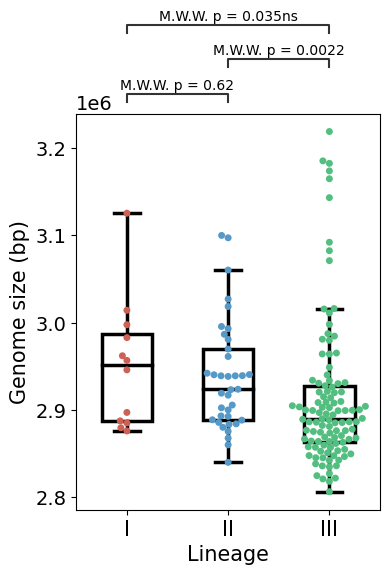

I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.552e-01 U_stat=2.835e+02
II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.298e-14 U_stat=3.205e+02
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.682e-06 U_stat=1.260e+02


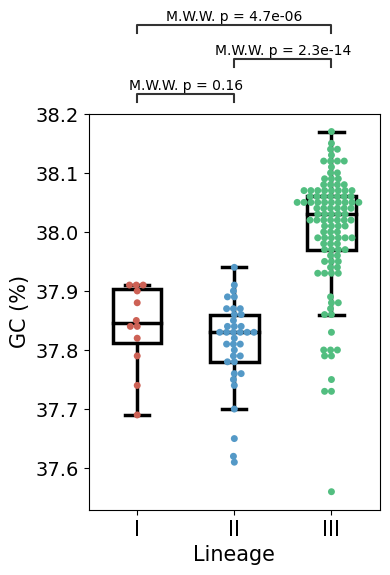

/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 43.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.395e-06 U_stat=2.400e+01
II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.773e-13 U_stat=3.654e+03
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.231e-02 U_stat=9.180e+02


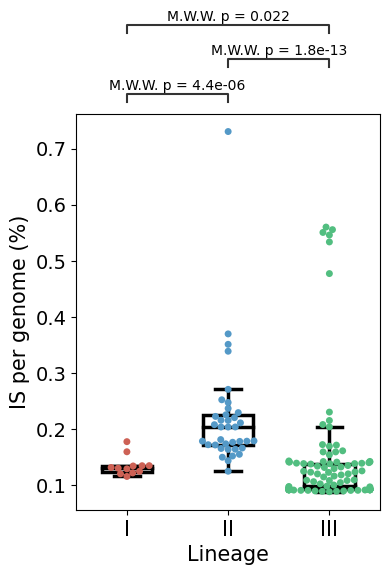

I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.951e-07 U_stat=1.000e+00
II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.715e-07 U_stat=3.179e+03
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.741e-01 U_stat=7.570e+02


/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 36.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


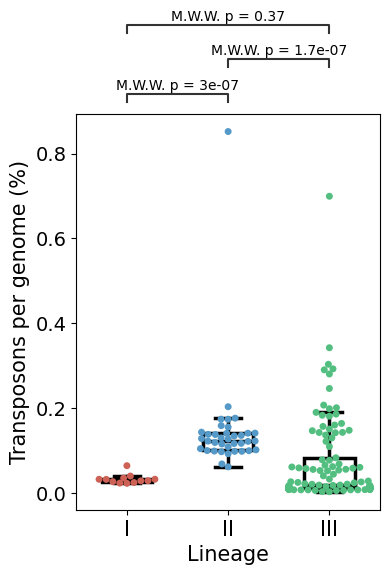

/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 29.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 51.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.783e-01 U_stat=2.530e+02
II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.501e-01 U_stat=1.974e+03
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.516e-01 U_stat=6.910e+02


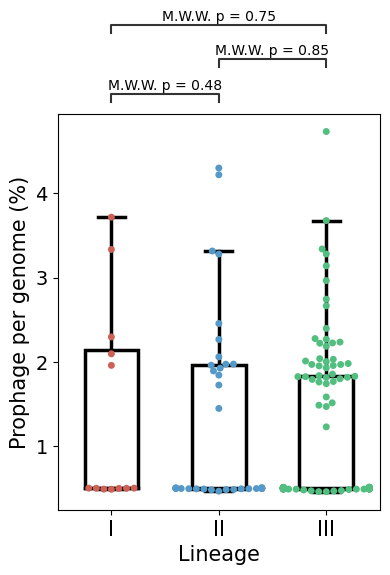

/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 45.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 79.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.934e-01 U_stat=2.580e+02
II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.119e-01 U_stat=2.201e+03
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.734e-02 (ns) U_stat=8.245e+02


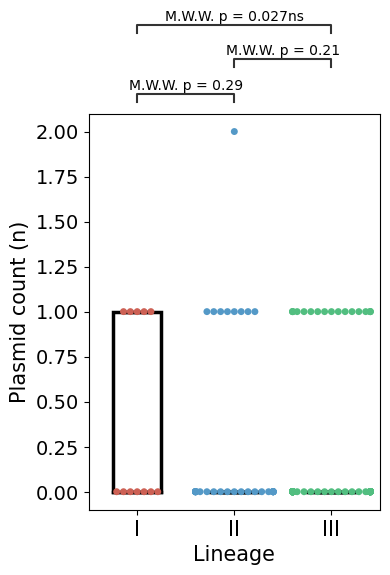

I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.707e-01 U_stat=2.145e+02
II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.683e-02 (ns) U_stat=2.481e+03
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.940e-01 U_stat=7.755e+02


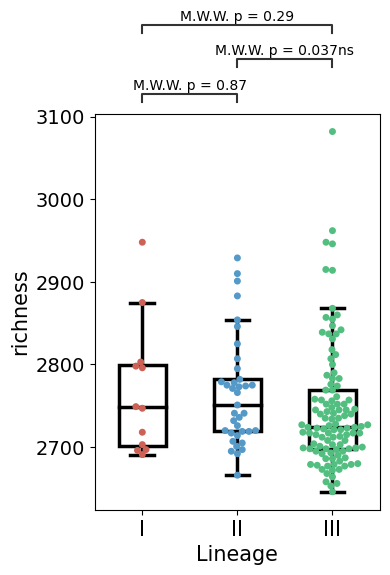

In [133]:
for key, val in pval_kw.items():
    prep_gp = pd.merge(mge_richness_reset, filtered_isolate, on="Isolate ID")
    prep_gp = prep_gp[[f"{key}", "Phylogroup"]]
    temp = prep_gp

    plot_3_box_with_mw_and_swarm(
        data=prep_gp,
        figsize=(4, 6),
        x="Phylogroup",
        y=f"{key}",
        box_pairs=[
            ("I", "II"),
            ("II", "III"),
            ("I", "III"),
        ],
        title=f"{key}",
        out_path=out_path_3
    )

### Fig. S9a Comparison of _Listeria_ pathogenicity island (LIPI) genes among _Lm_ lineages

In [134]:
# Load packages and data
df1_s_c_phylo = pd.read_csv(data_path_lm + 'virulence_merged.csv')
df1_s_phylo = df1_s_c_phylo[df1_s_c_phylo['source'] == 'soil']
columns_to_check = df1_s_phylo.columns.difference(['id', 'source', 'Phylogroup'])

# Identify rows that contain values other than 0 or 1
non_binary_rows = df1_s_phylo[columns_to_check].apply(lambda row: row.isin([0, 1]).all(), axis=1)

# Get the rows that have non-binary values
non_binary_data = df1_s_phylo[~non_binary_rows]

In [135]:
# Comparison of virulence gene among Lm lineages
df1_s_c_phylo = pd.read_csv(data_path_lm + 'virulence_merged.csv')

# Modify the gene matrix to make it 0 or 1 only (replace values greater than 1 with 1 to indicate overall present)
columns_to_modify = df1_s_c_phylo.columns.difference(['id', 'source', 'Phylogroup'])
df1_s_c_phylo[columns_to_modify] = df1_s_c_phylo[columns_to_modify].applymap(lambda x: 1 if x > 1 else x)

In [136]:
# Select only 'soil' in 'source' column and create another dataframe
df1_s_phylo = df1_s_c_phylo[df1_s_c_phylo['source'] == 'soil']

import pandas as pd
import numpy as np
from statsmodels.stats.contingency_tables import Table
from collections import defaultdict
import statsmodels.stats.multitest as smt

# Function to perform Fisher's Exact Test for a 2x3 contingency table
def fisher_exact_2x3(table):
    """Performs a Fisher's Exact Test for a 2x3 contingency table."""
    tbl = Table(table)
    result = tbl.test_nominal_association()
    return result.pvalue

# Dictionary to store p-values for each gene
pval = defaultdict(list)

# Genes of interest
genes_of_interest = [
    'prfA', 'plcA', 'hly', 'mpl', 'actA', 'plcB', 'LIPI3_llsA', 
    'LIPI3_llsB', 'LIPI3_llsD', 'LIPI3_llsG', 'LIPI3_llsH', 
    'LIPI3_llsP', 'LIPI3_llsX', 'LIPI3_llsY', 'LM9005581_70009', 
    'LM9005581_70010', 'LM9005581_70011', 'LM9005581_70012', 
    'LM9005581_70013', 'LM9005581_70014'
]

# Loop through each gene and perform Fisher's Exact Test
for gene in genes_of_interest:
    # Group data by Phylogroup and count occurrences of presence (1) and absence (0)
    phylogroups = df1_s_phylo.groupby('Phylogroup')[gene].value_counts().unstack(fill_value=0)

    # Ensure we have 3 groups (lineages) and 2 categories (presence/absence)
    if phylogroups.shape == (3, 2):
        contingency_table = phylogroups.values.T
        p_value = fisher_exact_2x3(contingency_table)
    else:
        p_value = 1
    
    # Store the p-value
    pval[gene].append(p_value)

# Apply FDR correction using your custom fdr_sig function
sig_vir_s = fdr_sig(pval)

# Print significant columns
sig_vir_s

{'prfA': 0.0,
 'hly': 0.0,
 'LIPI3_llsA': 0.0,
 'LIPI3_llsB': 0.0,
 'LIPI3_llsD': 0.0,
 'LIPI3_llsG': 0.0,
 'LIPI3_llsH': 0.0,
 'LIPI3_llsP': 0.0,
 'LIPI3_llsX': 0.0,
 'LIPI3_llsY': 0.0,
 'LM9005581_70009': 0.0006547147438359935,
 'LM9005581_70010': 0.0006547147438359935,
 'LM9005581_70011': 0.0006547147438359935,
 'LM9005581_70012': 0.0006547147438359935,
 'LM9005581_70013': 0.0006547147438359935,
 'LM9005581_70014': 0.0006547147438359935}

In [137]:
def plot_heatmap_gene(heatmap_df, color, title="", out_path="", file_title="", figsize=(6, 6)):
    """
    Plots a heatmap based on values in 'I', 'II', and 'III' columns.

    Parameters:
    - heatmap_df (DataFrame): The DataFrame containing values for plotting the heatmap.
    - color (str): Color map for the heatmap.
    - title (str): Title of the plot.
    - out_path (str): Output path for saving the plot.
    - file_title (str): File title for saving the plot.
    - figsize (tuple): Size of the figure.
    """

    # Select only the columns 'I', 'II', and 'III' for plotting the heatmap
    heatmap_data = heatmap_df[['I', 'II', 'III']]

    # Create the heatmap
    plt.figure(figsize=figsize)
    ax = sns.heatmap(heatmap_data, cmap=color, annot=False, linewidths=0.5, vmin=0, vmax=1)

    plt.xlabel('Lineage', size=15)
    plt.ylabel('Gene', size=15)
    plt.title(title, size=15)

    # Make y-ticks horizontal
    plt.yticks(rotation=0, ha="right", fontsize=12)

    # Add a title for the color bar
    color_bar = ax.collections[0].colorbar
    color_bar.set_label('Proportion')

    # Add this line to fit the plot
    plt.tight_layout()

    # Generate a safe file title
    safe_file_title = file_title.replace("/", "_").replace("\\", "_")

    # Save the figure
    plt.savefig(f"{out_path}/{safe_file_title}.pdf", format="pdf", dpi=300)

    plt.show()

In [138]:
# Proportion heatmap for selected virulence genes
heatmap_df = pd.DataFrame(columns=["I", "II", "III"])
i = 0
for key, val in pval.items():
    prep_gp = df1_s_phylo

    # Calculate proportion of occurrences for each group
    total_count_L1 = prep_gp[prep_gp["Phylogroup"] == "LM lineage I"].shape[0]
    total_count_L2 = prep_gp[prep_gp["Phylogroup"] == "LM lineage II"].shape[0]
    total_count_L3 = prep_gp[prep_gp["Phylogroup"] == "LM lineage III"].shape[0]

    count_L1 = prep_gp[(prep_gp["Phylogroup"] == "LM lineage I") & (prep_gp[key] != 0)].shape[0]
    count_L2 = prep_gp[(prep_gp["Phylogroup"] == "LM lineage II") & (prep_gp[key] != 0)].shape[0]
    count_L3 = prep_gp[(prep_gp["Phylogroup"] == "LM lineage III") & (prep_gp[key] != 0)].shape[0]

    proportion_L1 = count_L1 / total_count_L1 if total_count_L1 != 0 else 0
    proportion_L2 = count_L2 / total_count_L2 if total_count_L2 != 0 else 0
    proportion_L3 = count_L3 / total_count_L3 if total_count_L3 != 0 else 0

    # Check if any proportions are non-zero before adding to heatmap_df
    if any([proportion_L1, proportion_L2, proportion_L3]):
        # Modify the key if it is found in sig_vir_s
        if key in sig_vir_s:
            key_modified = key + "*"  # Add asterisk
        else:
            key_modified = key  # No change

        # Append the proportions to the DataFrame using the modified key
        heatmap_df.loc[key_modified] = [proportion_L1, proportion_L2, proportion_L3]

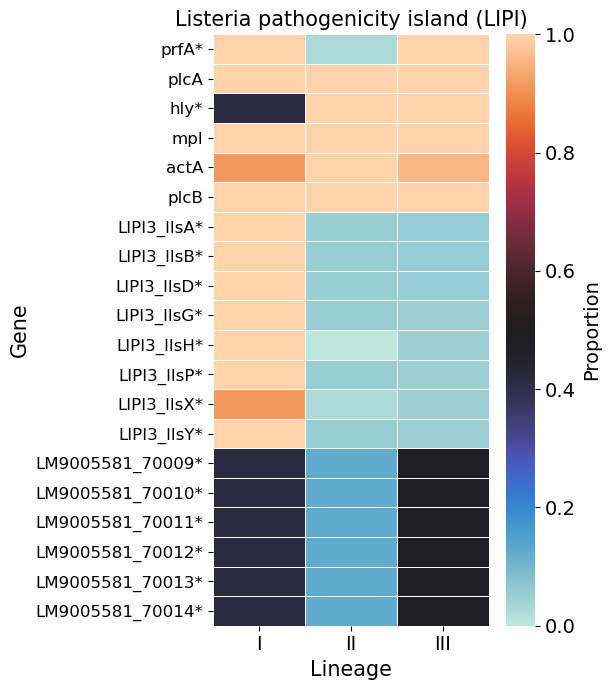

In [139]:
# LIPI
plot_heatmap_gene(heatmap_df, "icefire", title="Listeria pathogenicity island (LIPI)", out_path=out_path_supp, 
                        file_title="fig_s8a_lipi_lineage", figsize=(6, 7))

### Fig. S9a Comparison of internalin (_inl_) genes among _Lm_ lineages

In [140]:
# Select only 'soil' in 'source' column and create another dataframe
df1_s_phylo = df1_s_c_phylo[df1_s_c_phylo['source'] == 'soil']

# Dictionary to store p-values for each column
pval = defaultdict(list)

# Columns of interest
genes_of_interest = ['inlA', 'inlB', 'inlC', 'inlC2', 'inlD', 'inlE', 'inlF', 'inlG', 'inlH', 'inlJ', 'inlK', 'inlL', 'inlP1', 'inlP3', 'inlP4', 'inlPq']

# Loop through each gene and perform Fisher's Exact Test
for gene in genes_of_interest:
    # Group data by Phylogroup and count occurrences of presence (1) and absence (0)
    phylogroups = df1_s_phylo.groupby('Phylogroup')[gene].value_counts().unstack(fill_value=0)

    # Ensure we have 3 groups (lineages) and 2 categories (presence/absence)
    if phylogroups.shape == (3, 2):
        contingency_table = phylogroups.values.T
        p_value = fisher_exact_2x3(contingency_table)
    else:
        p_value = 1
    
    # Store the p-value
    pval[gene].append(p_value)

# Apply FDR correction using your custom fdr_sig function
sig_inl_s = fdr_sig(pval)

# Print significant columns
sig_inl_s

{'inlC': 3.877934932461358e-05,
 'inlF': 0.0,
 'inlG': 1.6196821661651484e-11,
 'inlJ': 4.4348145986194965e-05,
 'inlL': 0.0,
 'inlP3': 1.7763568394002505e-14,
 'inlP4': 6.014625834419955e-11,
 'inlPq': 1.7763568394002505e-14}

In [141]:
# Proportion heatmap for inl genes
heatmap_df = pd.DataFrame(columns=["I", "II", "III"])
i = 0
for key, val in pval.items():
    prep_gp = df1_s_phylo

    # Calculate proportion of occurrences for each group
    total_count_L1 = prep_gp[prep_gp["Phylogroup"] == "LM lineage I"].shape[0]
    total_count_L2 = prep_gp[prep_gp["Phylogroup"] == "LM lineage II"].shape[0]
    total_count_L3 = prep_gp[prep_gp["Phylogroup"] == "LM lineage III"].shape[0]

    count_L1 = prep_gp[(prep_gp["Phylogroup"] == "LM lineage I") & (prep_gp[key] != 0)].shape[0]
    count_L2 = prep_gp[(prep_gp["Phylogroup"] == "LM lineage II") & (prep_gp[key] != 0)].shape[0]
    count_L3 = prep_gp[(prep_gp["Phylogroup"] == "LM lineage III") & (prep_gp[key] != 0)].shape[0]

    proportion_L1 = count_L1 / total_count_L1 if total_count_L1 != 0 else 0
    proportion_L2 = count_L2 / total_count_L2 if total_count_L2 != 0 else 0
    proportion_L3 = count_L3 / total_count_L3 if total_count_L3 != 0 else 0

    # Check if any proportions are non-zero before adding to heatmap_df
    #if any([proportion_L1, proportion_L2, proportion_L3]):
    # Modify the key if it is found in sig_vir_s
    if key in sig_inl_s:
        key_modified = key + "*"  # Add asterisk
    else:
        key_modified = key  # No change

    # Append the proportions to the DataFrame using the modified key
    heatmap_df.loc[key_modified] = [proportion_L1, proportion_L2, proportion_L3]

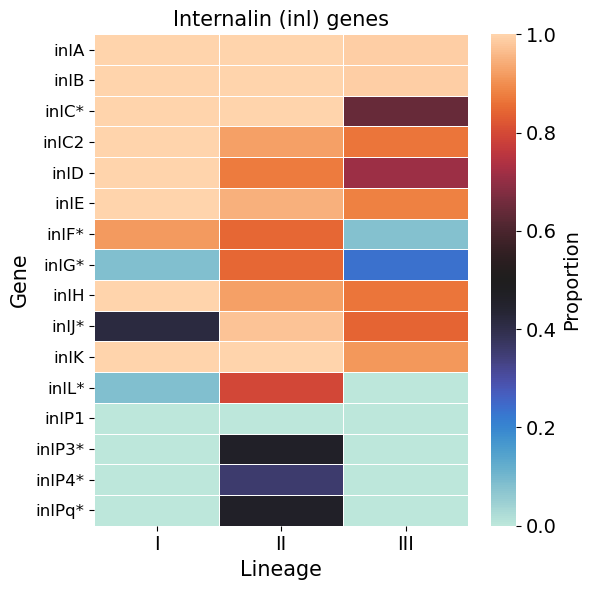

In [142]:
# inl
plot_heatmap_gene(
    heatmap_df, "icefire",
    "Internalin (inl) genes",
    out_path=out_path_supp, file_title="fig_s8b_inl_lineage", figsize=(6, 6))

### Fig. S9a Comparison of stress survival islet (SSI) genes among _Lm_ lineages

In [143]:
# Load input data
df2_s_c_phylo = pd.read_csv(data_path_lm + 'stress_merged.csv')

# Modify the gene matrix to make it 0 or 1 only (replace values greater than 1 with 1 to indicate overall present)
columns_to_modify = df2_s_c_phylo.columns.difference(['id', 'source', 'Phylogroup'])
df2_s_c_phylo[columns_to_modify] = df2_s_c_phylo[columns_to_modify].applymap(lambda x: 1 if x > 1 else x)

In [144]:
# Select only 'soil' in 'source' column and create another dataframe
df2_s_phylo = df2_s_c_phylo[df2_s_c_phylo['source'] == 'soil']

# Dictionary to store p-values for each column
pval = defaultdict(list)

# Columns of interest
genes_of_interest = ['SSI1_lmo0444', 'SSI1_lmo0445', 'SSI1_lmo0446', 'SSI1_lmo0447', 'SSI1_lmo0448', 'SSI2_lin0464', 'SSI2_lin0465']

# Loop through each gene and perform Fisher's Exact Test
for gene in genes_of_interest:
    # Group data by Phylogroup and count occurrences of presence (1) and absence (0)
    phylogroups = df2_s_phylo.groupby('Phylogroup')[gene].value_counts().unstack(fill_value=0)

    # Ensure we have 3 groups (lineages) and 2 categories (presence/absence)
    if phylogroups.shape == (3, 2):
        contingency_table = phylogroups.values.T
        p_value = fisher_exact_2x3(contingency_table)
    else:
        p_value = 1
    
    # Store the p-value
    pval[gene].append(p_value)

# Apply FDR correction using your custom fdr_sig function
sig_ssi_s = fdr_sig(pval)

# Print significant columns
sig_ssi_s

{'SSI1_lmo0444': 7.485567721232655e-13,
 'SSI1_lmo0445': 7.485567721232655e-13,
 'SSI1_lmo0446': 7.485567721232655e-13,
 'SSI1_lmo0447': 7.485567721232655e-13,
 'SSI1_lmo0448': 7.485567721232655e-13,
 'SSI2_lin0464': 2.950450994632092e-11,
 'SSI2_lin0465': 2.950450994632092e-11}

In [145]:
# Proportion heatmap for SSI
heatmap_df = pd.DataFrame(columns=["I", "II", "III"])
i = 0
for key, val in pval.items():
    prep_gp = df2_s_phylo

    # Calculate proportion of occurrences for each group
    total_count_L1 = prep_gp[prep_gp["Phylogroup"] == "LM lineage I"].shape[0]
    total_count_L2 = prep_gp[prep_gp["Phylogroup"] == "LM lineage II"].shape[0]
    total_count_L3 = prep_gp[prep_gp["Phylogroup"] == "LM lineage III"].shape[0]

    count_L1 = prep_gp[(prep_gp["Phylogroup"] == "LM lineage I") & (prep_gp[key] != 0)].shape[0]
    count_L2 = prep_gp[(prep_gp["Phylogroup"] == "LM lineage II") & (prep_gp[key] != 0)].shape[0]
    count_L3 = prep_gp[(prep_gp["Phylogroup"] == "LM lineage III") & (prep_gp[key] != 0)].shape[0]

    proportion_L1 = count_L1 / total_count_L1 if total_count_L1 != 0 else 0
    proportion_L2 = count_L2 / total_count_L2 if total_count_L2 != 0 else 0
    proportion_L3 = count_L3 / total_count_L3 if total_count_L3 != 0 else 0

    # Check if any proportions are non-zero before adding to heatmap_df
    if any([proportion_L1, proportion_L2, proportion_L3]):
        # Modify the key if it is found in sig_vir_s
        if key in sig_ssi_s:
            key_modified = key + "*"  # Add asterisk
        else:
            key_modified = key  # No change

        # Append the proportions to the DataFrame using the modified key
        heatmap_df.loc[key_modified] = [proportion_L1, proportion_L2, proportion_L3]

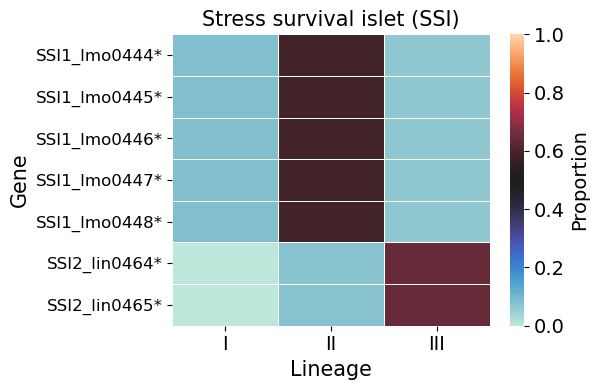

In [146]:
# SSI
plot_heatmap_gene(heatmap_df, "icefire", "Stress survival islet (SSI)", 
                        out_path=out_path_supp, file_title="fig_s8c_ssi", figsize=(6, 4))

### Fig. S9a Comparison of antibiotic resistance gene (ARG) genes among _Lm_ lineages

In [147]:
# Comparing ARGs between Lm lineages
df4_s_c_phylo = pd.read_csv(data_path_lm + "arg_merged.csv")

# Modify the gene matrix to make it 0 or 1 only (replace values greater than 1 with 1 to indicate overall present)
columns_to_modify = df4_s_c_phylo.columns.difference(['id', 'source', 'Phylogroup'])
df4_s_c_phylo[columns_to_modify] = df4_s_c_phylo[columns_to_modify].applymap(lambda x: 1 if x > 1 else x)

In [148]:
# Select only 'soil' in 'source' column and create another dataframe
df4_s_phylo = df4_s_c_phylo[df4_s_c_phylo['source'] == 'soil']

# Dictionary to store p-values for each column
pval = defaultdict(list)

# Columns of interest
genes_of_interest = ['fosX', 'lin', 'mprF', 'norB', 'sul']

# Loop through each gene and perform Fisher's Exact Test
for gene in genes_of_interest:
    # Group data by Phylogroup and count occurrences of presence (1) and absence (0)
    phylogroups = df4_s_phylo.groupby('Phylogroup')[gene].value_counts().unstack(fill_value=0)

    # Ensure we have 3 groups (lineages) and 2 categories (presence/absence)
    if phylogroups.shape == (3, 2):
        contingency_table = phylogroups.values.T
        p_value = fisher_exact_2x3(contingency_table)
    else:
        p_value = 1
    
    # Store the p-value
    pval[gene].append(p_value)

# Apply FDR correction using your custom fdr_sig function
sig_arg_s = fdr_sig(pval)

# Print significant columns
sig_arg_s

{}

In [149]:
# Proportion heatmap for ARG
heatmap_df = pd.DataFrame(columns=["I", "II", "III"])
i = 0
for key, val in pval.items():
    prep_gp = df4_s_phylo

    # Calculate proportion of occurrences for each group
    total_count_L1 = prep_gp[prep_gp["Phylogroup"] == "LM lineage I"].shape[0]
    total_count_L2 = prep_gp[prep_gp["Phylogroup"] == "LM lineage II"].shape[0]
    total_count_L3 = prep_gp[prep_gp["Phylogroup"] == "LM lineage III"].shape[0]

    count_L1 = prep_gp[(prep_gp["Phylogroup"] == "LM lineage I") & (prep_gp[key] != 0)].shape[0]
    count_L2 = prep_gp[(prep_gp["Phylogroup"] == "LM lineage II") & (prep_gp[key] != 0)].shape[0]
    count_L3 = prep_gp[(prep_gp["Phylogroup"] == "LM lineage III") & (prep_gp[key] != 0)].shape[0]

    proportion_L1 = count_L1 / total_count_L1 if total_count_L1 != 0 else 0
    proportion_L2 = count_L2 / total_count_L2 if total_count_L2 != 0 else 0
    proportion_L3 = count_L3 / total_count_L3 if total_count_L3 != 0 else 0

    # Check if any proportions are non-zero before adding to heatmap_df
    if any([proportion_L1, proportion_L2, proportion_L3]):
        # Modify the key if it is found in sig_vir_s
        if key in sig_arg_s:
            key_modified = key + "*"  # Add asterisk
        else:
            key_modified = key  # No change

        # Append the proportions to the DataFrame using the modified key
        heatmap_df.loc[key_modified] = [proportion_L1, proportion_L2, proportion_L3]

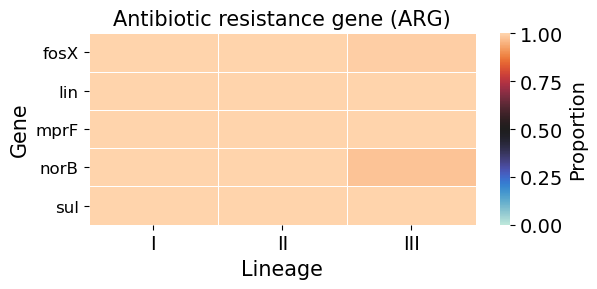

In [150]:
# ARG
plot_heatmap_gene(heatmap_df, "icefire", title="Antibiotic resistance gene (ARG)",
                  out_path=out_path_supp, file_title="fig_s8d_arg", figsize=(6, 3))

### Fig. 3g VPA showing the variation of gene richness for lineage III explained by abiotic and biotic factors.

In [151]:
# VPA

In [152]:
lineage_iii = env_phyla_cog_rich[env_phyla_cog_rich['Phylogroup'] == 'III']

In [153]:
%R -i lineage_iii

png 
  2 


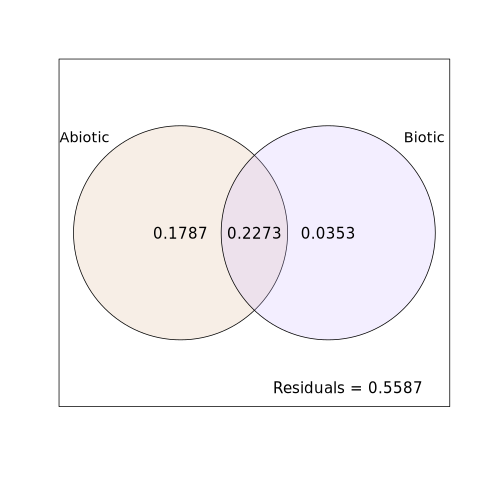

In [154]:
%%R

library(vegan)
library(tidyverse)

# Define the environmental variable list
env_list_all <- list(
  Abiotic = lineage_iii[, c(3:36)],
  Biotic = lineage_iii[, c(37:63)]
)

# Define the richness variable
richness_all <- list(
  Richness = lineage_iii[, c(64)]
)

# Function to perform variation partitioning
VarPart <- function(richness_all, env_list_all, out_path) {
  title <- file.path(out_path, 'fig_3g_abiot_bio_richness_vpa.pdf')
  pdf(title, width = 5, height = 5, pointsize = 8)

  # Perform the analysis on the specified variables
  plot(
    varpart(
      richness_all$Richness,
      env_list_all$Abiotic,
      env_list_all$Biotic
    ),
    digits = 3,
    Xnames = c('Abiotic', 'Biotic'),
    bg = c('#DEBB9B', '#D0BBFF'),
    cex = 1.25 # Adjust font size
  )
    
  title(main = 'VPA for gene richness (Lineage III only)')
  dev.off()
}

  plot(
    varpart(
      richness_all$Richness,
      env_list_all$Abiotic,
      env_list_all$Biotic
    ),
    digits = 3,
    Xnames = c('Abiotic', 'Biotic'),
    bg = c('#DEBB9B', '#D0BBFF'),
    cex = 1.25 # Adjust font size
  )

# Call the function for partitioning
out_path_3 <- "/projects/leaph/yingxian/lm_lineage_4va/out_2/fig_3/"
VarPart(richness_all, env_list_all, out_path_3)

#### Permutation test

In [155]:
df_env_sub = pd.read_csv(data_path_lm + "fig_3_vpa/3g_env_phyla_vpa_iii.csv", index_col=0)
df_shannon = pd.read_csv(data_path_lm + "fig_3_vpa/3g_richness_vpa_iii.csv", index_col=0)

In [156]:
%R -i df_env_sub
%R -i df_shannon

In [157]:
%%R

library(vegan)
library(tidyverse)

# Define the environmental variable list
env_list_all <- list(
  Abiotic = df_env_sub[, c(1:34)],
  Biotic = df_env_sub[, c(35:61)]
)

# Define the richness variable
richness_all <- list(
  Richness = df_shannon[, c(1)]
)

# Function to perform variation partitioning and extract residual R^2
VarPart <- function(richness_all, env_list_all) {
  # Perform variation partitioning (VPA)
  response <- varpart(
    richness_all$Richness,
    env_list_all$Abiotic,
    env_list_all$Biotic
  )
  
  # Extract the residual R^2 (adjusted R^2)
  residual_r2 <- response$part$indfract$Adj.R.square[[length(response$part$indfract$Adj.R.square)]]
  
  # Calculate explained variance
  explained_variance <- 1 - residual_r2
  
  # Return residual R^2 and explained variance
  return(c(residual_r2 = residual_r2, explained_variance = explained_variance))
}

# Observed results
observed_results <- VarPart(richness_all, env_list_all)

# Function to shuffle rows in df_shannon and compute VPA residual R^2
compute_shuffled_r2 <- function(df_env_sub, df_shannon) {
  # Shuffle the rows of df_shannon
  shuffled_shannon <- df_shannon
  shuffled_shannon[] <- lapply(shuffled_shannon, sample)  # Shuffle each column independently
  
  # Recompute the richness list
  shuffled_richness_all <- list(
    Richness = shuffled_shannon[, c(1)]
  )
  
  # Compute residual R^2 for shuffled data
  response <- varpart(
    shuffled_richness_all$Richness,
    env_list_all$Abiotic,
    env_list_all$Biotic
  )
  
  residual_r2 <- response$part$indfract$Adj.R.square[[length(response$part$indfract$Adj.R.square)]]
  explained_variance <- 1 - residual_r2
  
  return(c(residual_r2 = residual_r2, explained_variance = explained_variance))
}

# Function to perform 100 simulations and conduct one-tailed tests
run_simulations <- function(df_env_sub, df_shannon, observed_results, n_simulations = 100) {
  simulation_results <- data.frame(
    simulation = 1:n_simulations,
    residual_r2 = numeric(n_simulations),
    explained_variance = numeric(n_simulations),
    stringsAsFactors = FALSE
  )
  
  # Simulations
  for (i in 1:n_simulations) {
    result <- compute_shuffled_r2(df_env_sub, df_shannon)
    simulation_results$residual_r2[i] <- result["residual_r2"]
    simulation_results$explained_variance[i] <- result["explained_variance"]
  }
  
  # Observed explained variance
  observed_explained_variance <- observed_results["explained_variance"]
  
  # One-tailed p-value calculation
  p_value_higher <- mean(simulation_results$explained_variance >= observed_explained_variance)
  p_value_lower <- mean(simulation_results$explained_variance <= observed_explained_variance)
  
  # Save results
  simulation_results_metadata <- data.frame(
    observed_explained_variance = observed_explained_variance,
    P_val_higher = p_value_higher,
    P_val_lower = p_value_lower
  )
  
  # Define the output path
  out_path_vpa <- "/projects/leaph/yingxian/lm_lineage_4va/out_2/fig_3/vpa_permute/"
  
  # Save results
  write.csv(simulation_results, file = paste0(out_path_vpa, "3g_simulation_results.csv"), row.names = FALSE)
  write.csv(simulation_results_metadata, file = paste0(out_path_vpa, "3g_simulation_metadata.csv"), row.names = FALSE)
  
  return(list(simulation_results = simulation_results, metadata = simulation_results_metadata))
}

# Run simulations
results <- run_simulations(df_env_sub, df_shannon, observed_results, n_simulations = 100)

### Fig. 3h Variation of gene richness for COGs explained by abiotic and biotic factors at the species level and within lineage III.

In [158]:
df_env_sub = pd.read_csv(data_path_lm + "fig_3_vpa/3h_env_phyla_vpa_iii.csv", index_col=0)
df_shannon = pd.read_csv(data_path_lm + "fig_3_vpa/3h_richness_cog_iii.csv", index_col=0)

In [159]:
%R -i df_env_sub
%R -i df_shannon

In [160]:
%%R

library(vegan)
library(tidyverse)

# Define output path
out_path_vpa <- "/projects/leaph/yingxian/lm_lineage_4va/out_2/fig_3/vpa_permute/"

VarPart_val <- function(env_ls, shannon_ls){
  adjr2_ls <- list()
  for (shannon in names(shannon_ls)){
    response <- varpart(shannon_ls[[shannon]], env_ls$Abiotic, env_ls$Biotic)
    adjr2 <- response$part$indfract$Adj.R.square[[length(response$part$indfract$Adj.R.square)]]
    adjr2_ls[[shannon]] <- adjr2
  }
  df <- as.data.frame(adjr2_ls)
  return(df)  # Ensure the function explicitly returns the data frame
}

VarPart_plot <- function(env_ls, shannon_ls, shannon_colors = NULL){
  for (shannon in names(shannon_ls)){
    response <- varpart(shannon_ls[[shannon]], env_ls$Abiotic, env_ls$Biotic)
    
    # Define file path using paste0()
    file_path <- paste0(out_path_vpa, shannon, "_cog_env_vpa.pdf")
    pdf(file = file_path, width = 5, height = 5)
      
    plot(response, digits=2, Xnames = c('Abiotic', 'Biotic'), bg = c('#DEBB9B', '#D0BBFF'))
    title(main = shannon)
    dev.off()
  }
}

repeat_varpart <- function(r, k, df_env_sub, df_shannon, output_csv) {
  # Repeat the random selection `r` times
  dfs <- replicate(r, {
    # Randomly select k indices
    random_indices <- sample(nrow(df_env_sub), k)
    env_ls <- list(
      Abiotic = df_env_sub[random_indices, c(1:34)],
      Biotic = df_env_sub[random_indices, c(35:61)]
    )
    shannon_ls <- as.list(df_shannon[random_indices, ])
    df <- VarPart_val(env_ls, shannon_ls)
    return(list(env_ls = env_ls, shannon_ls = shannon_ls, df = df))
  }, simplify = FALSE)
  
  # Extract results from the last iteration
  last_iteration <- dfs[[r]]
  observed_df <- last_iteration$df
  
  # Ensure that the COG column names are the same as those in df_shannon
  cog_names <- colnames(df_shannon)
  
  # Reshape the data to include 'COG', 'Observed_R2', and 'Explained_variance'
  observed_r2 <- data.frame(
    COG = cog_names,
    Observed_R2 = as.numeric(unlist(observed_df)),
    Explained_var = 1 - as.numeric(unlist(observed_df))
  )
  
  # Write the simplified CSV file
  write.csv(observed_r2, output_csv, row.names = FALSE)
  
  # Return the last iteration's env_ls and shannon_ls for plotting
  return(last_iteration)
}

# Run the analysis
results <- repeat_varpart(
  r = 1, 
  k = 123, 
  df_env_sub = df_env_sub, 
  df_shannon = df_shannon, 
  output_csv = file.path(out_path_vpa, "3h_iii_cog_abio_bio_residuals.csv")
)

# Extract env_ls and shannon_ls from the last iteration's results for plotting
env_ls <- results$env_ls
shannon_ls <- results$shannon_ls

# Generate plots based on the last iteration's results
VarPart_plot(env_ls, shannon_ls)

#### Shuffle the data for each COG independently and repeat for VPA, correct the _P_-value using BH-FDR method

In [161]:
%%R

library(vegan)
library(tidyverse)

# Define the output path
output_path <- "/projects/leaph/yingxian/lm_lineage_4va/out_2/fig_3/vpa_permute/"

# Part 1: Simulate the results and store them in 2b_simulation_results.csv
simulate_varpart <- function(df_env_sub, df_shannon, n_shuffles = 100) {
  all_simulation_results <- list()
  
  # Loop over each COG
  for (cog in colnames(df_shannon)) {
    residual_r2_values <- numeric(n_shuffles)
    
    for (i in 1:n_shuffles) {
      # Shuffle the COG data correctly
      shuffled_shannon <- df_shannon
      shuffled_shannon[[cog]] <- sample(shuffled_shannon[[cog]])

      # Define environmental variables and Shannon values as lists
      env_ls <- list(
        Abiotic = df_env_sub[, c(1:34)],
        Biotic = df_env_sub[, c(35:61)]
      )
      shannon_ls <- as.list(shuffled_shannon)

      # Get the adjusted R² value
      adj_r2_df <- VarPart_val(env_ls, shannon_ls)
      residual_r2_values[i] <- adj_r2_df[[1, cog]] # Access the correct element
    }

    # Store simulation results for the current COG
    simulation_results <- data.frame(
      COG = cog,
      simulation = 1:n_shuffles,
      residual_r2 = residual_r2_values,
      explained_variance = 1 - residual_r2_values
    )
    all_simulation_results[[cog]] <- simulation_results
  }
  
  # Combine all simulation results into one data frame
  combined_simulation_results <- bind_rows(all_simulation_results)

  # Write results to CSV using file.path for better compatibility
  write.csv(combined_simulation_results, file = file.path(output_path, "3h_simulation_results.csv"), row.names = FALSE)
  
  return(combined_simulation_results)
}

# Run simulation and get results
simulation_results <- simulate_varpart(df_env_sub, df_shannon, n_shuffles = 100)

# Part 2: Calculate the one-tailed p-values and apply FDR correction
calculate_p_values <- function(df_env_sub, df_shannon, simulation_results) {
  metadata_accum <- data.frame(
    COG = character(),
    Observed_R2 = numeric(),
    Explained_Variance = numeric(),
    P_r2_higher = numeric(),
    P_r2_lower = numeric(),
    P_var_exp_higher = numeric(),
    P_var_exp_lower = numeric(),
    stringsAsFactors = FALSE
  )

  for (cog in colnames(df_shannon)) {
    # Define environmental variables and Shannon values as lists
    env_ls <- list(
      Abiotic = df_env_sub[, c(1:34)],
      Biotic = df_env_sub[, c(35:61)]
    )
    shannon_ls <- as.list(df_shannon)

    # Get adjusted R² values
    adj_r2_df <- VarPart_val(env_ls, shannon_ls)
    observed_r2 <- adj_r2_df[[1, cog]]
    observed_explained_variance <- 1 - observed_r2

    # Extract simulation results for current COG
    residual_r2_values <- simulation_results %>%
      filter(COG == cog) %>%
      pull(residual_r2)
    explained_variance_values <- 1 - residual_r2_values

    # Calculate p-values (one-tailed)
    p_r2_higher <- mean(residual_r2_values >= observed_r2, na.rm = TRUE)
    p_r2_lower <- mean(residual_r2_values <= observed_r2, na.rm = TRUE)
    p_var_exp_higher <- mean(explained_variance_values >= observed_explained_variance, na.rm = TRUE)
    p_var_exp_lower <- mean(explained_variance_values <= observed_explained_variance, na.rm = TRUE)

    # Add to metadata
    metadata_accum <- bind_rows(metadata_accum, data.frame(
      COG = cog,
      Observed_R2 = observed_r2,
      Explained_Variance = observed_explained_variance,
      P_r2_higher = p_r2_higher,
      P_r2_lower = p_r2_lower,
      P_var_exp_higher = p_var_exp_higher,
      P_var_exp_lower = p_var_exp_lower
    ))
  }

  # Apply FDR correction
  metadata_accum <- metadata_accum %>%
    mutate(
      P_r2_higher_FDR = p.adjust(P_r2_higher, method = "BH"),
      P_r2_lower_FDR = p.adjust(P_r2_lower, method = "BH"),
      P_var_exp_higher_FDR = p.adjust(P_var_exp_higher, method = "BH"),
      P_var_exp_lower_FDR = p.adjust(P_var_exp_lower, method = "BH")
    )

  # Write to CSV using file.path
  write.csv(metadata_accum, file = file.path(output_path, "3h_metadata_iii_cog_results_with_fdr.csv"), row.names = FALSE)

  return(metadata_accum)
}

# Run p-value calculation
metadata_df <- calculate_p_values(df_env_sub, df_shannon, simulation_results)

(-1.0, 18.0)

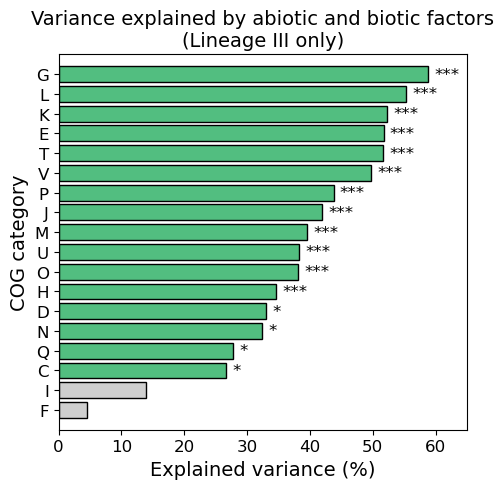

In [162]:
# Barplot for variance explained and their P-vals
abiot_bio_cog_permute_iii = pd.read_csv(data_path_lm + "metadata_iii_cog_results_with_fdr.csv", index_col=False)
abiot_bio_cog_permute_iii = abiot_bio_cog_permute_iii[['COG', 'Explained_Variance', 'P_var_exp_higher_FDR', 'P_var_exp_lower_FDR']]

# Create a new column 'P-val' with the relevant values or 'NS' if none are < 0.05
abiot_bio_cog_permute_iii['FDR-P-val'] = np.where(
    abiot_bio_cog_permute_iii['P_var_exp_higher_FDR'] < 0.05,
    abiot_bio_cog_permute_iii['P_var_exp_higher_FDR'],
    np.where(abiot_bio_cog_permute_iii['P_var_exp_lower_FDR'] < 0.05, abiot_bio_cog_permute_iii['P_var_exp_lower_FDR'], 'NS')
)

# Create a new column 'than_null' with 'higher', 'lower', or 'NS'
abiot_bio_cog_permute_iii['than_null'] = np.where(
    abiot_bio_cog_permute_iii['P_var_exp_higher_FDR'] < 0.05,
    'higher',
    np.where(abiot_bio_cog_permute_iii['P_var_exp_lower_FDR'] < 0.05, 'lower', 'NS')
)

abiot_bio_cog_permute_iii = abiot_bio_cog_permute_iii[['COG', 'Explained_Variance', 'FDR-P-val', 'than_null']]

# Sorting the proportions in descending order
abiot_bio_cog_permute_iii_sorted = abiot_bio_cog_permute_iii.sort_values(by='Explained_Variance', ascending=True)
abiot_bio_cog_permute_iii_sorted = abiot_bio_cog_permute_iii_sorted[~abiot_bio_cog_permute_iii_sorted['COG'].isin(['S', 'W'])]

# Convert Explained_Variance to percentages
abiot_bio_cog_permute_iii_sorted['Explained_Variance'] *= 100

# Create asterisks based on FDR-P-val
abiot_bio_cog_permute_iii_sorted['FDR-P-val'] = pd.to_numeric(abiot_bio_cog_permute_iii_sorted['FDR-P-val'], errors='coerce')
abiot_bio_cog_permute_iii_sorted['FDR-P-val'] = abiot_bio_cog_permute_iii_sorted['FDR-P-val'].fillna('NS')

def get_asterisks(p_val):
    if p_val == 'NS':
        return ''
    elif p_val < 0.001:
        return '***'
    elif p_val < 0.01:
        return '**'
    elif p_val < 0.05:
        return '*'
    else:
        return '' 

abiot_bio_cog_permute_iii_sorted['Asterisks'] = abiot_bio_cog_permute_iii_sorted['FDR-P-val'].apply(get_asterisks)

# Define a color mapping based on 'than_null' column
color_mapping = {
    'higher': '#52BE80', 
    'lower': '#f39c12', 
    'NS': '#CFCFCF'
}

# Map colors to the 'than_null' column
bar_colors = abiot_bio_cog_permute_iii_sorted['than_null'].map(color_mapping)

# Plotting the horizontal bar chart
plt.figure(figsize=(5, 5))
bars = plt.barh(
    abiot_bio_cog_permute_iii_sorted['COG'], 
    abiot_bio_cog_permute_iii_sorted['Explained_Variance'], 
    color=bar_colors, 
    edgecolor='#000000'
)

# Adding the asterisks at the end of the respective bars
for bar, label in zip(bars, abiot_bio_cog_permute_iii_sorted['Asterisks']):
    if label:  # Only annotate if there is an asterisk
        plt.text(
            bar.get_width() + 1,  # Position slightly to the right of the bar
            bar.get_y() + bar.get_height() / 2,  # Centered vertically
            label, 
            va='center', 
            ha='left', 
            fontsize=12, 
            color='black'
        )

# Customize labels and title
plt.xlabel('Explained variance (%)', fontsize=14)
plt.ylabel('COG category', fontsize=14)
plt.title('Variance explained by abiotic and biotic factors\n(Lineage III only)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.xlim(0, 65)
plt.ylim(-1, 18)

#plt.savefig(out_path_3 + 'fig_3f_cog_abio_bio_iii_var_exp.pdf', bbox_inches='tight', dpi=600)
#plt.show()

In [163]:
abiot_bio_cog_permute_sorted['Remarks'] = 'Overall'
abiot_bio_cog_permute_iii_sorted['Remarks'] = 'Lineage III'
abiot_bio_cog_overall_and_iii = pd.concat([abiot_bio_cog_permute_iii_sorted, abiot_bio_cog_permute_sorted], axis=0)
abiot_bio_cog_overall_and_iii = abiot_bio_cog_overall_and_iii.sort_values(by='Explained_Variance', ascending=False)
abiot_bio_cog_overall_and_iii["Remarks"] = abiot_bio_cog_overall_and_iii["Remarks"].replace("Overall", "Species level")
#abiot_bio_cog_overall_and_iii = abiot_bio_cog_overall_and_iii[abiot_bio_cog_overall_and_iii['FDR-P-val'] != 'NS']

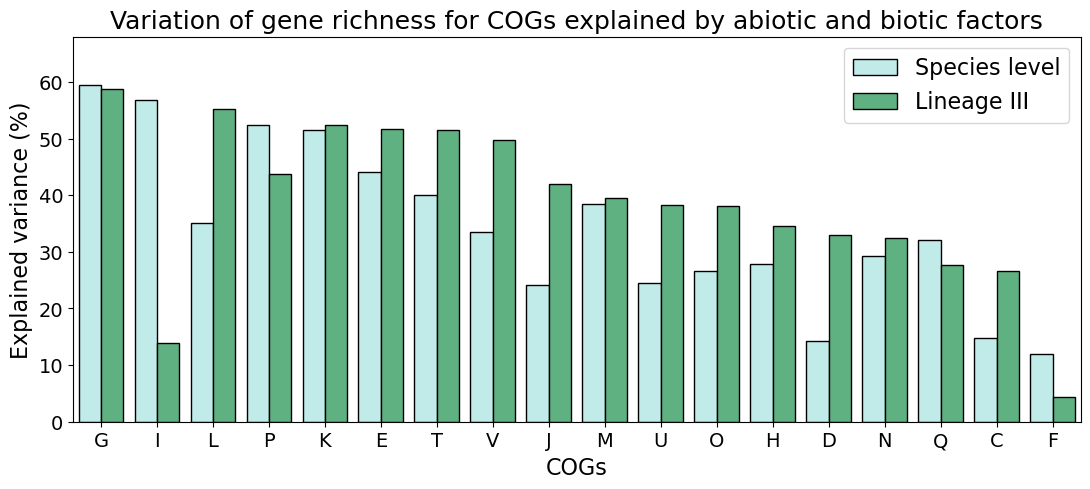

In [164]:
import seaborn as sns
import matplotlib.pyplot as plt

# Adjust the figure size
plt.figure(figsize=(13, 5))

# Bar plot for richness with outlines on the bars
bar_plot = sns.barplot(
    data=abiot_bio_cog_overall_and_iii,
    x="COG",
    y="Explained_Variance",
    hue="Remarks",
    palette=["#B9F2F0", "#52BE80"],
    edgecolor='black'
)

# Customize labels and title
plt.xlabel("COGs", fontsize=16)
plt.ylabel("Explained variance (%)", fontsize=16)
plt.title("Variation of gene richness for COGs explained by abiotic and biotic factors", fontsize=18)

# Adjust font size for x and y ticks
plt.xticks(rotation=0, ha="center", fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0, 68)

# Manually create legend for the bar plot only
handles, labels = bar_plot.get_legend_handles_labels() 
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title="", loc='upper right', fontsize=16)  

# Save and show the plot
plt.savefig(out_path_3 + "fig_3h_overall_iii_var_exp.pdf", bbox_inches="tight", dpi=300)
plt.show()

## Fig. 4 | Dispersal patterns of _Lm_ lineages in soil and their epidemiological links to clinical isolates.

### Fig. 4a Linear regression for genetic similarities measured by average nucleotide identity (ANI) and geographic distances for _Lm_ lineage I, II, and III.

In [165]:
# Load input and data pre-processing
df_ani = pd.read_excel(data_path_lm + "ANIB_matrix_all_listeria.xlsx", index_col=0)
isolate = pd.read_csv(data_path + "Listeria_genomes.csv", index_col=2)

lm_isolate = isolate[isolate["Species"] == "L. monocytogenes"]
lm_ids = lm_isolate.index.astype(str)
common_ids = lm_ids.intersection(df_ani.index.astype(str))

df_ani_lm = df_ani.loc[common_ids, common_ids]

df_ani_lm_long = (
    df_ani_lm
      .stack()
      .reset_index()
      .rename(columns={'level_0': 'genome1',
                       'level_1': 'genome2',
                       0: 'ANI'})
      .query("genome1 < genome2")  # keep only upper triangle & drop self-pairs
)

# Assign lineages for each isolate set
lineage_dict = {}
lineage_dict.update({gid: 'I' for gid in monocytogenes_isolate_L3.index})
lineage_dict.update({gid: 'II'  for gid in monocytogenes_isolate_L2.index})
lineage_dict.update({gid: 'III' for gid in monocytogenes_isolate_L1.index})

# Map genome1 and genome2 to their lineages
df_ani_lm_long['genome1_lineage'] = df_ani_lm_long['genome1'].map(lineage_dict)
df_ani_lm_long['genome2_lineage'] = df_ani_lm_long['genome2'].map(lineage_dict)

In [166]:
# Load distance input and merge it with previous dfs
df_dist = pd.read_csv(data_path_lm + "geo_dist.csv", index_col=0)

# Merge geo dist for genome1
df_ani_lm_long = df_ani_lm_long.merge(
    df_dist[['lat', 'lon']], 
    left_on='genome1', 
    right_index=True, 
    how='left',
    suffixes=('', '_genome1')
)

# Rename merged columns for genome1
df_ani_lm_long = df_ani_lm_long.rename(columns={'lat': 'genome1_lat', 'lon': 'genome1_lon'})

# Merge for genome2
df_ani_lm_long = df_ani_lm_long.merge(
    df_dist[['lat', 'lon']], 
    left_on='genome2', 
    right_index=True, 
    how='left',
    suffixes=('', '_genome2')
)

# Rename merged columns for genome2
df_ani_lm_long = df_ani_lm_long.rename(columns={'lat': 'genome2_lat', 'lon': 'genome2_lon'})

# Calculate pairwise distance in km
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate great-circle distance between two coordinates in kilometers.
    """
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Earth radius in km
    return c * r

df_ani_lm_long['distance_km'] = haversine(
    df_ani_lm_long['genome1_lat'],
    df_ani_lm_long['genome1_lon'],
    df_ani_lm_long['genome2_lat'],
    df_ani_lm_long['genome2_lon']
)

In [167]:
# Stratify by lineages
df_ani_lm_i = df_ani_lm_long[
    (df_ani_lm_long['genome1_lineage'] == 'I') & 
    (df_ani_lm_long['genome2_lineage'] == 'I')
].copy()

df_ani_lm_ii = df_ani_lm_long[
    (df_ani_lm_long['genome1_lineage'] == 'II') & 
    (df_ani_lm_long['genome2_lineage'] == 'II')
].copy()

df_ani_lm_iii = df_ani_lm_long[
    (df_ani_lm_long['genome1_lineage'] == 'III') & 
    (df_ani_lm_long['genome2_lineage'] == 'III')
].copy()
df_ani_lm_iii = df_ani_lm_iii[df_ani_lm_iii['ANI'] >= 0.97].copy()

In [168]:
len(df_ani_lm_i)

66

In [169]:
from scipy.stats import linregress
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_distance_decay(
    data,
    x='dis',
    y='ANIB',
    y_label='',
    point_color="#5DADE2",
    point_size=20,
    title=None,
    out_path='decay_plot.pdf',
    ax=None,
    ylim=None
):
    # --- Check if data is empty ---
    if data.empty:
        print("No data provided.")
        return

    # --- Linear regression ---
    slope, intercept, r_value, p_value, std_err = linregress(data[x], data[y])
    r_squared = r_value ** 2

    # --- Print slope in console ---
    print(f"Slope: {slope:.3e}")

    # --- Plot setup ---
    if ax is None:
        plt.figure(figsize=(4.5, 4))
        ax = plt.gca()

    # --- Scatter plot ---
    sns.scatterplot(
        data=data,
        x=x,
        y=y,
        color=point_color,
        s=point_size,
        edgecolor=None,
        linewidth=0,
        ax=ax
    )

    # --- Regression line and 95% CI ---
    x_sorted = np.sort(data[x])
    y_pred = slope * x_sorted + intercept

    # Standard error of the mean (SEM) for predicted y
    n = len(data[x])
    y_residuals = data[y] - (slope * data[x] + intercept)
    residual_std = np.std(y_residuals, ddof=1)
    sem = residual_std / np.sqrt(n)
    ci = 1.96 * sem  # 95% CI

    # Plot regression line
    ax.plot(x_sorted, y_pred, color="gray", alpha=0.7, linewidth=2)

    # Shaded 95% CI
    ax.fill_between(x_sorted, y_pred - ci, y_pred + ci, color='gray', alpha=0.2)

    # --- Display slope and R² on plot ---
    slope_label = f"Slope = {slope:.3e}"
    r2_label = f"$R^2$ = {r_squared:.2f}"
    ax.text(
        0.98, 0.98,
        slope_label + '\n' + r2_label,
        ha='right',
        va='top',
        transform=ax.transAxes,
        fontsize=10,
        color='black'
    )

    # --- Labels and aesthetics ---
    ax.set_xlabel("Geographic distance (km)", fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    if title:
        ax.set_title(title, fontsize=13)

    ax.tick_params(axis='both', labelsize=11)
    ax.grid(False)

    if ylim is not None:
        ax.set_ylim(ylim)

    # --- Save plot (only if standalone) ---
    if out_path is not None and ax is plt.gca():
        plt.tight_layout()
        plt.savefig(out_path, format='pdf', dpi=300)
        plt.show()

Slope: -1.445e-07
Slope: -2.752e-06
Slope: -2.200e-06


/localscratch/ipykernel_625849/3270295205.py:91: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


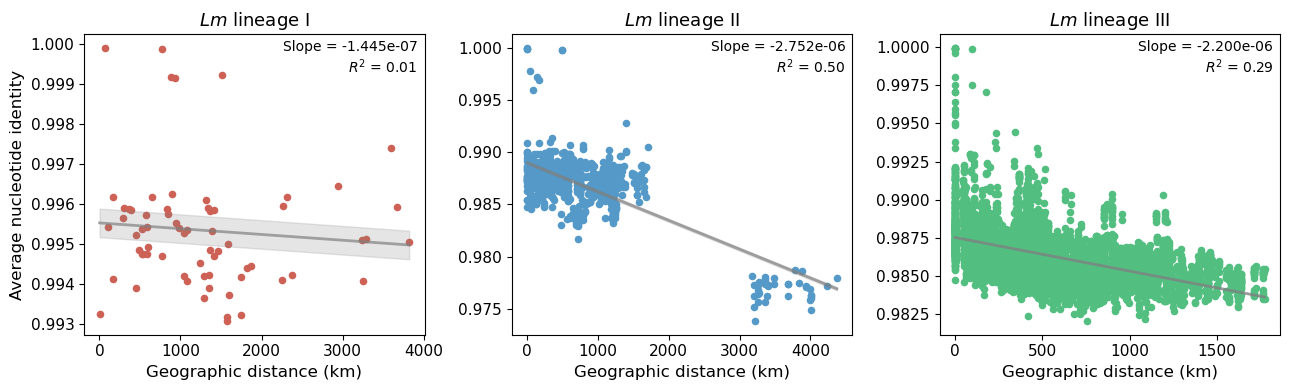

In [170]:
fig, axs = plt.subplots(1, 3, figsize=(13, 4), constrained_layout=True)

plot_distance_decay(df_ani_lm_i,   x='distance_km', y='ANI',
                    y_label='Average nucleotide identity',
                    point_color="#CD6155", point_size=30,
                    title='$\\it{Lm}$ lineage I', ax=axs[0])

plot_distance_decay(df_ani_lm_ii,  x='distance_km', y='ANI',
                    y_label='',
                    point_color="#5499C7", point_size=30,
                    title='$\\it{Lm}$ lineage II', ax=axs[1])

plot_distance_decay(df_ani_lm_iii, x='distance_km', y='ANI',
                    y_label='',
                    point_color="#52BE80", point_size=30,
                    title='$\\it{Lm}$ lineage III', ax=axs[2])

fig.savefig(out_path_4 + "4a_ddr_ani_plots.svg", dpi=300)
plt.show()

### Fig. S10 Dispersal patterns of _Lm_ lineages after downsampling.

Slope: -1.445e-07
Slope: -2.436e-06
Slope: -2.416e-06


/localscratch/ipykernel_625849/3270295205.py:91: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


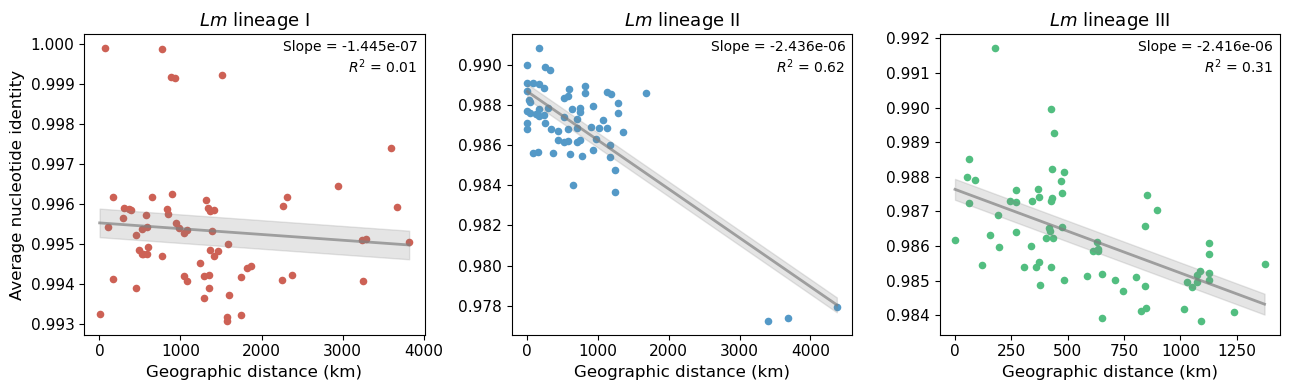

In [171]:
# Randomly select same sample size (n=66)
df_ani_lm_ii_rsel = df_ani_lm_ii.sample(n=66, random_state=42)
df_ani_lm_iii_rsel = df_ani_lm_iii.sample(n=66, random_state=42)

fig, axs = plt.subplots(1, 3, figsize=(13, 4), constrained_layout=True)

plot_distance_decay(df_ani_lm_i,   x='distance_km', y='ANI',
                    y_label='Average nucleotide identity',
                    point_color="#CD6155", point_size=30,
                    title='$\\it{Lm}$ lineage I', ax=axs[0])

plot_distance_decay(df_ani_lm_ii_rsel,  x='distance_km', y='ANI',
                    y_label='',
                    point_color="#5499C7", point_size=30,
                    title='$\\it{Lm}$ lineage II', ax=axs[1])

plot_distance_decay(df_ani_lm_iii_rsel, x='distance_km', y='ANI',
                    y_label='',
                    point_color="#52BE80", point_size=30,
                    title='$\\it{Lm}$ lineage III', ax=axs[2])

fig.savefig(out_path_4 + "sXX_ddr_ani_plots.svg", dpi=300)
plt.show()

### Fig. S11 Dispersal patterns of _Lm_ lineage II after excluding the distant cluster.

Slope: -1.015e-06


/localscratch/ipykernel_625849/3270295205.py:91: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


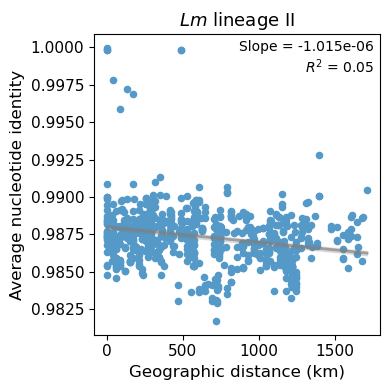

In [172]:
# Remove distant points
df_ani_lm_ii_r = df_ani_lm_ii[df_ani_lm_ii['distance_km'] <= 3000].copy()

# Create figure and axes
fig, axs = plt.subplots(1, 1, figsize=(4, 4), constrained_layout=True)

plot_distance_decay(
    df_ani_lm_ii_r,
    x='distance_km',
    y='ANI',
    y_label='Average nucleotide identity',
    point_color="#5499C7",
    point_size=30,
    title='$\\it{Lm}$ lineage II',
    ax=axs
)

fig.savefig(out_path_4 + "sx_ddr_ani_lineage_ii.svg", dpi=300)
plt.show()

### Fig. S14 Genomic features compared between epidemiologically linked soil and clinical _Lm_ lineage I isolates.

In [173]:
# Load input file
mge_2 = pd.read_csv(data_path_lm + "lm_env_cli_mge.csv", delimiter=",")
mge_2.rename(columns={"Plasmid_Cnt": "Plasmid count (n)"}, inplace=True)

In [174]:
# L7-0745 IDs
id_L7_0745 = ['L7-0745', 'PDT000035566-3']

# L7-0846 IDs
id_L7_0846 = ['L7-0846', 'PDT000420514-2']

id_L7_1173 = [
    'L7-1173', 'PDT000000019-9', 'PDT000000547-7','PDT000001113-5','PDT000001247-3', 'PDT000066307-2', 'PDT000077162-2','PDT000134761-2', 'PDT000136839-3', 
    'PDT000234207-2','PDT000289159-2','PDT000413819-1','PDT000420047-2', 'PDT000420220-2', 'PDT000420305-2','PDT000420411-2']

In [175]:
# Filter the DataFrame based on the IDs
mge_2 = mge_2[mge_2['id'].isin(id_L7_0745 + id_L7_0846 + id_L7_1173)]

# Add a 'strain' column to annotate 'group A' and 'group B'
mge_2.loc[mge_2['id'].isin(id_L7_0745), 'related_strain'] = 'L7-0745'
mge_2.loc[mge_2['id'].isin(id_L7_0846), 'related_strain'] = 'L7-0846'
mge_2.loc[mge_2['id'].isin(id_L7_1173), 'related_strain'] = 'L7-1173'

# Print the resulting DataFrame
mge_2 = mge_2.sort_values(by='related_strain', ascending=True)
len(mge_2)

20

In [176]:
from scipy import stats

# Define the columns to compare
mge_columns = ['Genome size (bp)', 'GC (%)', 'IS per genome (%)', 'Transposons per genome (%)', 'Prophage per genome (%)', 'Plasmid count (n)']

# Group the DataFrame by 'related_strain'
groups_related_strain = mge_2.groupby('related_strain')

# Iterate over each group based on 'related_strain'
for strain, strain_data in groups_related_strain:
    print(f"Related Strain: {strain}:")
    
    # Group the data within the current 'related_strain' group by 'Source'
    source_groups = strain_data.groupby('Source')
    
    # Extract the values for the 'soil' source group of the current 'related_strain' group
    soil_values = source_groups.get_group('soil')
    
    # Print the reference values (for debugging purposes)
    # print(f"Reference values (Source='soil'):\n{soil_values}\n")
    
    # Initialize a dictionary to store Wilcoxon rank-sum test results for each column
    wilcoxon_results = {}
    
    # Iterate over each column to compare
    for column in mge_columns:
        # Extract values for the current column from the 'soil' source group
        soil_column_values = soil_values[column].values
        
        # Iterate over each source group within the current 'related_strain' group
        for source, source_group_data in source_groups:
            if source == 'soil':
                continue
            
            # Extract values for the current column from the current source group
            column_values = source_group_data[column].values
            
            try:
                # Perform Wilcoxon Rank-Sum Test comparing column values to the soil reference values
                _, p_value = stats.ranksums(column_values, soil_column_values)
                
                # Store the p-value in the dictionary
                wilcoxon_results[f'{column} - Source {source}'] = p_value
                
                # Print the p-value for the current source group and column
                print(f"{column} - Source {source}: p-value = {p_value}")
            
            except ValueError:
                # Handle the ValueError: All numbers are identical in wilcoxon
                print(f"{column} - Source {source}: All numbers are identical in wilcoxon. Skipping this source group.")
                continue
    
    # print("Wilcoxon rank-sum test results:")
    print(wilcoxon_results)

Related Strain: L7-0745:
Genome size (bp) - Source clinical: p-value = 0.31731050786291415
GC (%) - Source clinical: p-value = 0.31731050786291415
IS per genome (%) - Source clinical: p-value = 0.31731050786291415
Transposons per genome (%) - Source clinical: p-value = 0.31731050786291415
Prophage per genome (%) - Source clinical: p-value = 0.31731050786291415
Plasmid count (n) - Source clinical: p-value = 1.0
{'Genome size (bp) - Source clinical': 0.31731050786291415, 'GC (%) - Source clinical': 0.31731050786291415, 'IS per genome (%) - Source clinical': 0.31731050786291415, 'Transposons per genome (%) - Source clinical': 0.31731050786291415, 'Prophage per genome (%) - Source clinical': 0.31731050786291415, 'Plasmid count (n) - Source clinical': 1.0}
Related Strain: L7-0846:
Genome size (bp) - Source clinical: p-value = 0.31731050786291415
GC (%) - Source clinical: p-value = 0.31731050786291415
IS per genome (%) - Source clinical: p-value = 0.31731050786291415
Transposons per genome (

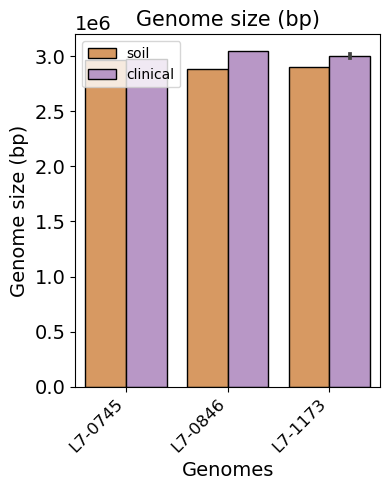

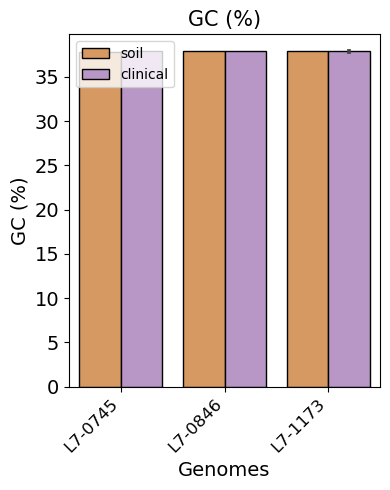

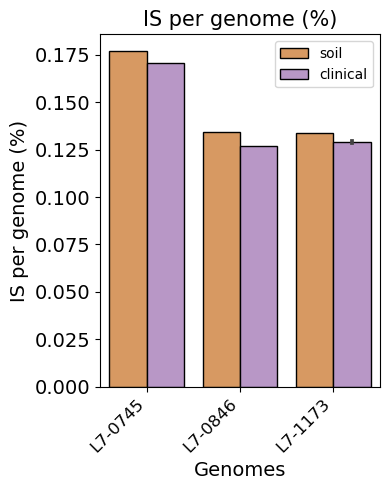

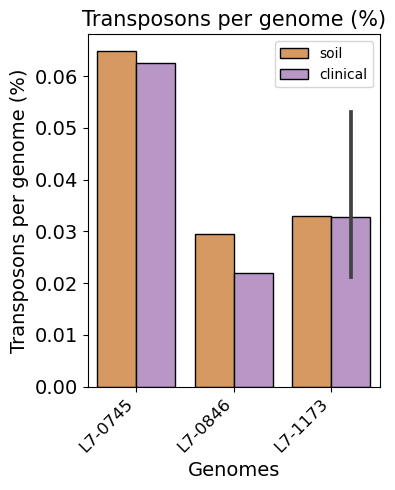

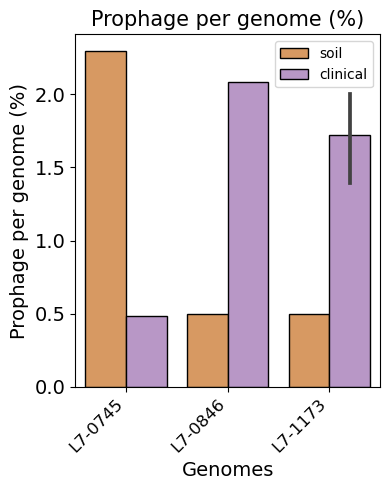

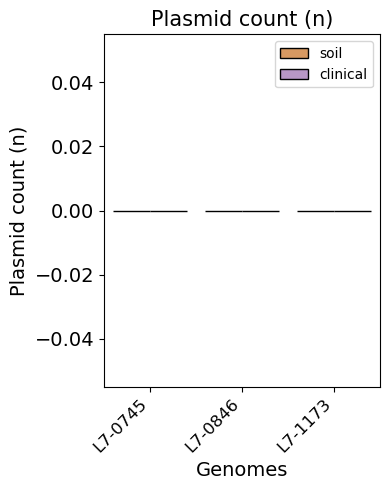

Wilcoxon rank-sum test results:

Genome size (bp):
L7-0745_clinical: 0.31731050786291415
L7-0846_clinical: 0.31731050786291415
L7-1173_clinical: 0.10374167823654154

GC (%):
L7-0745_clinical: 0.31731050786291415
L7-0846_clinical: 0.31731050786291415
L7-1173_clinical: 0.32897177441062453

IS per genome (%):
L7-0745_clinical: 0.31731050786291415
L7-0846_clinical: 0.31731050786291415
L7-1173_clinical: 0.10374167823654154

Transposons per genome (%):
L7-0745_clinical: 0.31731050786291415
L7-0846_clinical: 0.31731050786291415
L7-1173_clinical: 0.2328233516916538

Prophage per genome (%):
L7-0745_clinical: 0.31731050786291415
L7-0846_clinical: 0.31731050786291415
L7-1173_clinical: 0.32897177441062453

Plasmid count (n):
L7-0745_clinical: 1.0
L7-0846_clinical: 1.0
L7-1173_clinical: 1.0


In [177]:
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the desired order for 'Related Strain' column
desired_order = ['L7-0745', 'L7-0846', 'L7-1173']

# Define the columns to compare
mge_columns = ['Genome size (bp)', 'GC (%)', 'IS per genome (%)', 'Transposons per genome (%)', 'Prophage per genome (%)', 'Plasmid count (n)']

# Sort the DataFrame based on the 'related_strain' column
mge_2_sorted = mge_2.sort_values(by='related_strain')

# Group the sorted DataFrame by the 'related_strain' column
groups_related_strain = mge_2_sorted.groupby('related_strain')

# Initialize lists to store data for plotting
plot_data = {column: {'Related Strain': [], 'Source': [], 'value': []} for column in mge_columns}

# Initialize dictionary to store Wilcoxon rank-sum test results
wilcoxon_results = {column: {} for column in mge_columns}

# Iterate over each group based on 'related_strain'
for strain, strain_data in groups_related_strain:
    # Group the data within the current 'related_strain' group by 'Source'
    source_groups = strain_data.groupby('Source')
    
    # Iterate over each column to compare
    for column in mge_columns:
        # Extract values for the 'soil' source group
        soil_values = source_groups.get_group('soil')[column].values
        
        # Iterate over each source group within the current 'related_strain' group
        for source, source_group_data in source_groups:
            # Extract values for the current column from the current source group
            column_values = source_group_data[column].values
            
            # Append data for plotting
            plot_data[column]['Related Strain'].extend([strain] * len(column_values))
            plot_data[column]['Source'].extend([source] * len(column_values))
            plot_data[column]['value'].extend(column_values)
            
            # Perform Wilcoxon rank-sum test if the source is not 'soil'
            if source != 'soil':
                try:
                    # Perform Wilcoxon rank-sum test comparing column values to soil values
                    statistic, p_value = stats.ranksums(column_values, soil_values)
                    wilcoxon_results[column][f'{strain}_{source}'] = p_value
                except ValueError:
                    wilcoxon_results[column][f'{strain}_{source}'] = 'N/A'

# Create separate plots for each column
for column in mge_columns:
    # Create a DataFrame for plotting
    plot_df = pd.DataFrame(plot_data[column])
    
    # Maintain the desired order for 'Related Strain' column
    plot_df['Related Strain'] = pd.Categorical(plot_df['Related Strain'], categories=desired_order, ordered=True)

    # Plot the barplot
    plt.figure(figsize=(4, 5))
    sns.barplot(x='Related Strain', y='value', hue='Source', data=plot_df, palette={"soil": "#EB984E", "clinical": "#BB8FCE"}, edgecolor="black", hue_order=["soil", "clinical"])

    # Set labels and title
    plt.title(f'{column}', size=15)
    plt.xlabel('Genomes', size=14)
    plt.ylabel(column, size=14)
    
    # Set custom x-tick labels (if needed)
    plt.xticks(fontsize=12, rotation=45, ha="right")

    # Show plot and save it
    plt.legend(title=None)
    plt.tight_layout()
    plt.savefig(out_path_4 + f'{column}_comparison.pdf', dpi=300)
    plt.show()

# Print Wilcoxon rank-sum test results
print("Wilcoxon rank-sum test results:")
for column in mge_columns:
    print(f"\n{column}:")
    for key, value in wilcoxon_results[column].items():
        print(f"{key}: {value}")

In [178]:
# Read the CSV files
df_phylo = pd.read_csv(data_path_lm + "lm_phylogroups.csv", delimiter=",")

df_phylo_old = pd.read_csv(data_path + "Listeria_genomes.csv", delimiter=",")

# Renaming column 'Isolate ID' to 'id'
df_phylo_old.rename(columns={'Isolate ID': 'id'}, inplace=True)

# Replace values in the 'Phylogroup' column
df_phylo_old['Phylogroup'].replace({'L1': 'LM lineage III', 'L2': 'LM lineage II', 'L3': 'LM lineage I'}, inplace=True)

# Select only LM in the previous soil dataframe
lm_df = df_phylo_old[df_phylo_old['Species'] == 'L. monocytogenes'].copy()

# Merge df_phylo and lm_df on 'id' column
merged_df = pd.merge(lm_df, df_phylo[['id', 'Phylogroup']], on='id', suffixes=('_lm', '_new'), how='inner')

# Check if 'Phylogroup' values match
matched_phylogroups = merged_df['Phylogroup_lm'] == merged_df['Phylogroup_new']

# Print the comparison result
print(matched_phylogroups.value_counts())
print(lm_df['Phylogroup'].value_counts())

# Summary - the new LM lineages matched with the old ones

True    177
Name: count, dtype: int64
Phylogroup
LM lineage III    126
LM lineage II      39
LM lineage I       12
Name: count, dtype: int64


In [179]:
# Comparison of virulence gene among Lm lineages
df1_s_c_phylo = pd.read_csv(data_path_lm + 'virulence_merged.csv')

In [180]:
# Columns lists for each group
lipi_1 = ['prfA', 'plcA', 'hly', 'mpl', 'actA', 'plcB']
lipi_3 = ['LIPI3_llsA', 'LIPI3_llsB', 'LIPI3_llsD', 'LIPI3_llsG', 'LIPI3_llsH', 'LIPI3_llsP', 'LIPI3_llsX', 'LIPI3_llsY']
lipi_4 = ['LM9005581_70009', 'LM9005581_70010', 'LM9005581_70011', 'LM9005581_70012', 'LM9005581_70013', 'LM9005581_70014']
inl = ['inlA', 'inlB', 'inlC', 'inlC2', 'inlD', 'inlE', 'inlF', 'inlG', 'inlH', 'inlJ', 'inlK', 'inlL', 'inlP1', 'inlP3', 'inlP4', 'inlPq']

# Create DataFrames for each group
df_lipi_1 = df1_s_c_phylo[['id', 'source', 'Phylogroup'] + lipi_1]
df_lipi_3 = df1_s_c_phylo[['id', 'source', 'Phylogroup'] + lipi_3]
df_lipi_4 = df1_s_c_phylo[['id', 'source', 'Phylogroup'] + lipi_4]
df_inl = df1_s_c_phylo[['id', 'source', 'Phylogroup'] + inl]

In [181]:
# Filter the DataFrame based on the IDs
df_lipi_1 = df_lipi_1[df_lipi_1['id'].isin(id_L7_0745 + id_L7_0846 + id_L7_1173)]

# Add a 'strain' column to annotate 'group A' and 'group B'
df_lipi_1.loc[df_lipi_1['id'].isin(id_L7_0745), 'related_strain'] = 'L7-0745'
df_lipi_1.loc[df_lipi_1['id'].isin(id_L7_0846), 'related_strain'] = 'L7-0846'
df_lipi_1.loc[df_lipi_1['id'].isin(id_L7_1173), 'related_strain'] = 'L7-1173'

# Print the resulting DataFrame
df_lipi_1 = df_lipi_1.sort_values(by='related_strain', ascending=True)

In [182]:
lipi_1 = ['prfA', 'plcA', 'hly', 'mpl', 'actA', 'plcB']
df_lipi_1.loc[:, 'lipi_1_sum'] = df_lipi_1[lipi_1].sum(axis=1)

# Filter for a specific related_strain (assuming 'L7-1173')
selected = df_lipi_1[df_lipi_1['related_strain'] == 'L7-1173']

# Group the DataFrame by the 'source' column
groups = selected.groupby('source')

# Initialize a dictionary to store Wilcoxon rank-sum test results
wilcoxon_results = {}

# Iterate over each group
for group_name, group_data in groups:
    # Compute row sum for the current group
    group_data['lipi_1_sum'] = group_data[lipi_1].sum(axis=1)
    
    # Extract 'lipi_1_sum' values for the current group
    current_group_values = group_data['lipi_1_sum'].values
    
    # Extract 'lipi_1_sum' values for the 'soil' group (assuming it's the reference)
    soil_values = selected[selected['source'] == 'soil']['lipi_1_sum'].values
    
    try:
        # Perform Wilcoxon rank-sum test comparing current group values to soil values
        _, p_value = stats.ranksums(current_group_values, soil_values)
        
        # Store the p-value in the dictionary
        wilcoxon_results[group_name] = p_value
        
        # Print the p-value for the current group
        print(f"{group_name}: p-value = {p_value}")
    
    except ValueError:
        # Handle the ValueError: All numbers are identical in wilcoxon
        print(f"{group_name}: All numbers are identical in wilcoxon. Skipping this group.")
        continue

# Print the Wilcoxon rank-sum test results
print("Wilcoxon rank-sum test results:")
print(wilcoxon_results)

clinical: p-value = 1.0
soil: p-value = 1.0
Wilcoxon rank-sum test results:
{'clinical': 1.0, 'soil': 1.0}


In [183]:
from scipy.stats import wilcoxon

# Define the columns in the DataFrame
lipi_1 = ['prfA', 'plcA', 'hly', 'mpl', 'actA', 'plcB']

# Sort the DataFrame based on the 'related_strain' column
df_lipi_1_sorted = df_lipi_1.sort_values(by='related_strain')

# Group the sorted DataFrame by the 'related_strain' column
groups_related_strain = df_lipi_1_sorted.groupby('related_strain')

# Iterate over each group based on 'related_strain'
for strain, strain_data in groups_related_strain:
    print(f"Related Strain: {strain}:")
    
    # Group the data within the current 'related_strain' group by 'source'
    source_groups = strain_data.groupby('source')
    
    # Extract lipi_1 sum values for the 'soil' source group of the current 'related_strain' group
    soil_lipi_1_sum_values = source_groups.get_group('soil')['lipi_1_sum'].values
    
    # Initialize a dictionary to store Wilcoxon rank-sum test results for each source group
    wilcoxon_results = {}
    
    # Iterate over each source group within the current 'related_strain' group
    for source, source_group_data in source_groups:
        # Skip 'soil' source group
        if source == 'soil':
            continue
        
        # Extract lipi_1 sum values for the current source group
        lipi_1_sum_values = source_group_data['lipi_1_sum'].values
        
        try:
            # Perform Wilcoxon rank-sum test (two-sided) comparing lipi_1 sum values to the soil reference values
            _, p_value = stats.ranksums(lipi_1_sum_values, soil_lipi_1_sum_values, alternative='two-sided')
            
            # Store the p-value in the dictionary
            wilcoxon_results[source] = p_value
            
            # Print the p-value for the current source group
            print(f"Source {source}: p-value = {p_value}")
        
        except ValueError:
            # Handle the ValueError: All numbers are identical in wilcoxon
            print(f"Source {source}: All numbers are identical in wilcoxon. Skipping this source group.")
            continue
    
    # Print Wilcoxon rank-sum test results for the current 'related_strain' group
    print("Wilcoxon rank-sum test results:")
    print(wilcoxon_results)

Related Strain: L7-0745:
Source clinical: p-value = 0.31731050786291415
Wilcoxon rank-sum test results:
{'clinical': 0.31731050786291415}
Related Strain: L7-0846:
Source clinical: p-value = 1.0
Wilcoxon rank-sum test results:
{'clinical': 1.0}
Related Strain: L7-1173:
Source clinical: p-value = 1.0
Wilcoxon rank-sum test results:
{'clinical': 1.0}


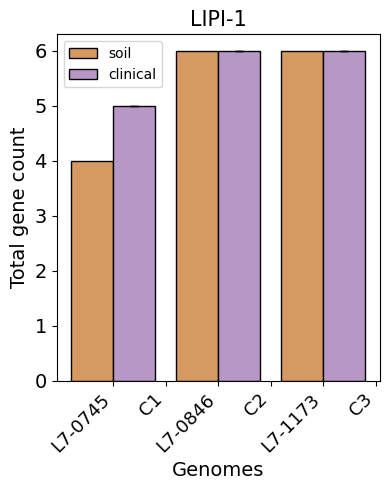

In [184]:
from scipy.stats import wilcoxon
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sort the DataFrame based on the 'related_strain' column
df_lipi_1_sorted = df_lipi_1.sort_values(by='related_strain')

# Group the sorted DataFrame by the 'related_strain' column
groups_related_strain = df_lipi_1_sorted.groupby('related_strain')

# Initialize lists to store data for plotting
x_values = []
y_values = []
errors = []
sources = []
p_values = []  # Store p-values for each pair

# Iterate over each group based on 'related_strain'
for strain, strain_data in groups_related_strain:
    # Group the data within the current 'related_strain' group by 'source'
    source_groups = strain_data.groupby('source')
    
    # Iterate over each source group within the current 'related_strain' group
    for source, source_group_data in source_groups:
        # Extract sum values for the current source group
        lipi_1_sum_values = source_group_data['lipi_1_sum']
        
        # Append data for plotting
        x_values.append(strain)
        y_values.append(lipi_1_sum_values.mean())
        errors.append(lipi_1_sum_values.std())  # Error bars represent the standard deviation
        sources.append(source)
        
        # Perform Wilcoxon rank-sum test and store p-value
        soil_lipi_1_sum_values = source_groups.get_group('soil')['lipi_1_sum'].values
        lipi_1_sum_values = source_group_data['lipi_1_sum'].values
        try:
            _, p_value = stats.ranksums(lipi_1_sum_values, soil_lipi_1_sum_values, alternative='two-sided')
            p_values.append(p_value)
        except ValueError:
            p_values.append(np.nan)

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'Related Strain': x_values,
    'Source': sources,
    'lipi_1_sum': y_values,
    'error': errors,
    'p_value': p_values
})

# Replace NaN values in 'error' column with zeros
plot_df['error'].fillna(0, inplace=True)

# Fill 'p_value' column with the same value for rows with the same 'Related Strain'
plot_df['p_value'] = plot_df.groupby('Related Strain')['p_value'].transform('first')

# Define the desired order for 'Related Strain' column
desired_order = ['L7-0745', 'L7-0846', 'L7-1173']

# Convert 'Related Strain' column to categorical data with desired order
plot_df['Related Strain'] = pd.Categorical(plot_df['Related Strain'], categories=desired_order, ordered=True)

# Define the order of hue levels
hue_order = ['soil', 'clinical']

# Plot the barplot without error bars
plt.figure(figsize=(4, 5))
sns.barplot(x='Related Strain', y='lipi_1_sum', hue='Source', hue_order=hue_order, data=plot_df, ci=None, palette=["#EB984E", "#BB8FCE"], edgecolor="black")

# Calculate error bars for 'clinical' source
clinical_errors = plot_df[plot_df['Source'] == 'clinical']['error']

# Define the offset for moving the error bars to the right
error_bar_offset = 0.2  # Adjust as needed

# Plot the error bars for 'clinical' bars
for i, strain in enumerate(desired_order):
    clinical_data = plot_df[(plot_df['Related Strain'] == strain) & (plot_df['Source'] == 'clinical')]
    plt.errorbar(i + error_bar_offset, clinical_data['lipi_1_sum'].values[0], yerr=clinical_data['error'].values[0], fmt='none', color='black', capsize=3)

# Set custom x-tick labels
tick_labels = ['L7-0745', 'C1', 'L7-0846', 'C2', 'L7-1173', 'C3']
tick_positions = np.arange(len(tick_labels)) / 2

# Set x-ticks and labels
plt.xticks(ticks=tick_positions, labels=tick_labels, fontsize=13, rotation=45, ha="right")

# Set labels and title
plt.title('LIPI-1', size=15)
plt.xlabel('Genomes', size=14)
plt.ylabel('Total gene count', size=14)

# Show plot
legend = plt.legend(title=None)
plt.tight_layout()
plt.savefig(out_path_supp + "fig_sXX_LIPI_1.pdf", dpi=300)
plt.show()

In [185]:
# Filter the DataFrame based on the IDs
df_lipi_3 = df_lipi_3[df_lipi_3['id'].isin(id_L7_0745 + id_L7_0846 + id_L7_1173)]

# Add a 'strain' column to annotate 'group A' and 'group B'
df_lipi_3.loc[df_lipi_3['id'].isin(id_L7_0745), 'related_strain'] = 'L7-0745'
df_lipi_3.loc[df_lipi_3['id'].isin(id_L7_0846), 'related_strain'] = 'L7-0846'
df_lipi_3.loc[df_lipi_3['id'].isin(id_L7_1173), 'related_strain'] = 'L7-1173'

df_lipi_3.loc[:, 'lipi_3_sum'] = df_lipi_3[lipi_3].sum(axis=1)

In [186]:
# Sort the DataFrame based on the 'related_strain' column
df_lipi_3_sorted = df_lipi_3.sort_values(by='related_strain')

# Group the sorted DataFrame by the 'related_strain' column
groups_related_strain = df_lipi_3_sorted.groupby('related_strain')

# Iterate over each group based on 'related_strain'
for strain, strain_data in groups_related_strain:
    print(f"Related Strain: {strain}:")
    
    # Group the data within the current 'related_strain' group by 'source'
    source_groups = strain_data.groupby('source')
    
    # Extract lipi_3 sum values for the 'soil' source group of the current 'related_strain' group
    soil_lipi_3_sum_values = source_groups.get_group('soil')['lipi_3_sum'].values
    
    # Initialize a dictionary to store Wilcoxon rank-sum test results for each source group
    wilcoxon_results = {}
    
    # Iterate over each source group within the current 'related_strain' group
    for source, source_group_data in source_groups:
        # Skip 'soil' source group
        if source == 'soil':
            continue
        
        # Extract lipi_3 sum values for the current source group
        lipi_3_sum_values = source_group_data['lipi_3_sum'].values
        
        try:
            # Perform Wilcoxon rank-sum test (two-sided) comparing lipi_3 sum values to the soil reference values
            _, p_value = stats.ranksums(lipi_3_sum_values, soil_lipi_3_sum_values, alternative='two-sided')
            
            # Store the p-value in the dictionary
            wilcoxon_results[source] = p_value
            
            # Print the p-value for the current source group
            print(f"Source {source}: p-value = {p_value}")
        
        except ValueError:
            # Handle the ValueError: All numbers are identical in wilcoxon
            print(f"Source {source}: All numbers are identical in wilcoxon. Skipping this source group.")
            continue
    
    # Print Wilcoxon rank-sum test results for the current 'related_strain' group
    print("Wilcoxon rank-sum test results:")
    print(wilcoxon_results)

Related Strain: L7-0745:
Source clinical: p-value = 1.0
Wilcoxon rank-sum test results:
{'clinical': 1.0}
Related Strain: L7-0846:
Source clinical: p-value = 1.0
Wilcoxon rank-sum test results:
{'clinical': 1.0}
Related Strain: L7-1173:
Source clinical: p-value = 1.0
Wilcoxon rank-sum test results:
{'clinical': 1.0}


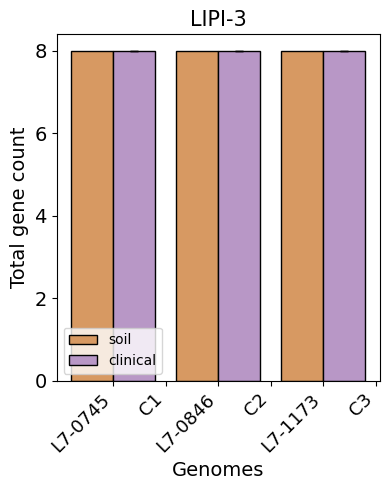

In [187]:
# Sort the DataFrame based on the 'related_strain' column
df_lipi_3_sorted = df_lipi_3.sort_values(by='related_strain')

# Group the sorted DataFrame by the 'related_strain' column
groups_related_strain = df_lipi_3_sorted.groupby('related_strain')

# Initialize lists to store data for plotting
x_values = []
y_values = []
errors = []
sources = []
p_values = []  # Store p-values for each pair

# Iterate over each group based on 'related_strain'
for strain, strain_data in groups_related_strain:
    # Group the data within the current 'related_strain' group by 'source'
    source_groups = strain_data.groupby('source')
    
    # Iterate over each source group within the current 'related_strain' group
    for source, source_group_data in source_groups:
        # Extract sum values for the current source group
        lipi_3_sum_values = source_group_data['lipi_3_sum']
        
        # Append data for plotting
        x_values.append(strain)
        y_values.append(lipi_3_sum_values.mean())
        errors.append(lipi_3_sum_values.std())  # Error bars represent the standard deviation
        sources.append(source)
        
        # Perform Wilcoxon rank-sum test and store p-value
        soil_lipi_3_sum_values = source_groups.get_group('soil')['lipi_3_sum'].values
        lipi_3_sum_values = source_group_data['lipi_3_sum'].values
        try:
            _, p_value = stats.ranksums(lipi_3_sum_values, soil_lipi_3_sum_values, alternative='two-sided')
            p_values.append(p_value)
        except ValueError:
            p_values.append(np.nan)

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'Related Strain': x_values,
    'Source': sources,
    'lipi_3_sum': y_values,
    'error': errors,
    'p_value': p_values
})

# Replace NaN values in 'error' column with zeros
plot_df['error'].fillna(0, inplace=True)

# Fill 'p_value' column with the same value for rows with the same 'Related Strain'
plot_df['p_value'] = plot_df.groupby('Related Strain')['p_value'].transform('first')

# Define the desired order for 'Related Strain' column
desired_order = ['L7-0745', 'L7-0846', 'L7-1173']

# Convert 'Related Strain' column to categorical data with desired order
plot_df['Related Strain'] = pd.Categorical(plot_df['Related Strain'], categories=desired_order, ordered=True)

# Define the order of hue levels
hue_order = ['soil', 'clinical']

# Plot the barplot without error bars
plt.figure(figsize=(4, 5))
sns.barplot(x='Related Strain', y='lipi_3_sum', hue='Source', hue_order=hue_order, data=plot_df, ci=None, palette=["#EB984E", "#BB8FCE"], edgecolor="black")

# Calculate error bars for 'clinical' source
clinical_errors = plot_df[plot_df['Source'] == 'clinical']['error']

# Define the offset for moving the error bars to the right
error_bar_offset = 0.2  # Adjust as needed

# Plot the error bars for 'clinical' bars
for i, strain in enumerate(desired_order):
    clinical_data = plot_df[(plot_df['Related Strain'] == strain) & (plot_df['Source'] == 'clinical')]
    plt.errorbar(i + error_bar_offset, clinical_data['lipi_3_sum'].values[0], yerr=clinical_data['error'].values[0], fmt='none', color='black', capsize=3)

# Set custom x-tick labels
tick_labels = ['L7-0745', 'C1', 'L7-0846', 'C2', 'L7-1173', 'C3']
tick_positions = np.arange(len(tick_labels)) / 2

# Set x-ticks and labels
plt.xticks(ticks=tick_positions, labels=tick_labels, fontsize=13, rotation=45, ha="right")

# Set labels and title
plt.title('LIPI-3', size=15)
plt.xlabel('Genomes', size=14)
plt.ylabel('Total gene count', size=14)

# Show plot
legend = plt.legend(title=None)
plt.tight_layout()
plt.savefig(out_path_supp + "fig_sXX_LIPI_3.pdf", dpi=300)
plt.show()

In [188]:
lipi_4 = ['LM9005581_70009', 'LM9005581_70010', 'LM9005581_70011', 'LM9005581_70012', 'LM9005581_70013', 'LM9005581_70014']

# Filter the DataFrame based on the IDs
df_lipi_4 = df_lipi_4[df_lipi_4['id'].isin(id_L7_0745 + id_L7_0846 + id_L7_1173)]

# Add a 'strain' column to annotate 'group A' and 'group B'
df_lipi_4.loc[df_lipi_4['id'].isin(id_L7_0745), 'related_strain'] = 'L7-0745'
df_lipi_4.loc[df_lipi_4['id'].isin(id_L7_0846), 'related_strain'] = 'L7-0846'
df_lipi_4.loc[df_lipi_4['id'].isin(id_L7_1173), 'related_strain'] = 'L7-1173'

df_lipi_4.loc[:, 'lipi_4_sum'] = df_lipi_4[lipi_4].sum(axis=1)

In [189]:
from scipy.stats import wilcoxon

# Sort the DataFrame based on the 'related_strain' column
df_lipi_4_sorted = df_lipi_4.sort_values(by='related_strain')

# Group the sorted DataFrame by the 'related_strain' column
groups_related_strain = df_lipi_4_sorted.groupby('related_strain')

# Iterate over each group based on 'related_strain'
for strain, strain_data in groups_related_strain:
    print(f"Related Strain: {strain}:")
    
    # Group the data within the current 'related_strain' group by 'source'
    source_groups = strain_data.groupby('source')
    
    # Extract lipi_4 sum values for the 'soil' source group of the current 'related_strain' group
    soil_lipi_4_sum_values = source_groups.get_group('soil')['lipi_4_sum'].values
    
    # Initialize a dictionary to store Wilcoxon rank-sum test results for each source group
    wilcoxon_results = {}
    
    # Iterate over each source group within the current 'related_strain' group
    for source, source_group_data in source_groups:
        # Skip 'soil' source group
        if source == 'soil':
            continue
        
        # Extract lipi_1 sum values for the current source group
        lipi_4_sum_values = source_group_data['lipi_4_sum'].values
        
        try:
            # Perform Wilcoxon rank-sum test (two-sided) comparing lipi_4 sum values to the soil reference values
            _, p_value = stats.ranksums(lipi_4_sum_values, soil_lipi_4_sum_values, alternative='two-sided')
            
            # Store the p-value in the dictionary
            wilcoxon_results[source] = p_value
            
            # Print the p-value for the current source group
            print(f"Source {source}: p-value = {p_value}")
        
        except ValueError:
            # Handle the ValueError: All numbers are identical in wilcoxon
            print(f"Source {source}: All numbers are identical in wilcoxon. Skipping this source group.")
            continue
    
    # Print Wilcoxon rank-sum test results for the current 'related_strain' group
    print("Wilcoxon rank-sum test results:")
    print(wilcoxon_results)

Related Strain: L7-0745:
Source clinical: p-value = 1.0
Wilcoxon rank-sum test results:
{'clinical': 1.0}
Related Strain: L7-0846:
Source clinical: p-value = 1.0
Wilcoxon rank-sum test results:
{'clinical': 1.0}
Related Strain: L7-1173:
Source clinical: p-value = 1.0
Wilcoxon rank-sum test results:
{'clinical': 1.0}


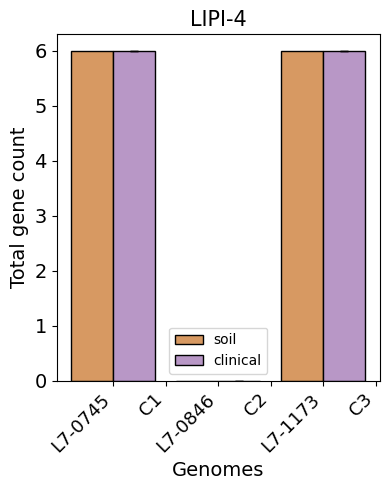

In [190]:
# Sort the DataFrame based on the 'related_strain' column
df_lipi_4_sorted = df_lipi_4.sort_values(by='related_strain')

# Group the sorted DataFrame by the 'related_strain' column
groups_related_strain = df_lipi_4_sorted.groupby('related_strain')

# Initialize lists to store data for plotting
x_values = []
y_values = []
errors = []
sources = []
p_values = []  # Store p-values for each pair

# Iterate over each group based on 'related_strain'
for strain, strain_data in groups_related_strain:
    # Group the data within the current 'related_strain' group by 'source'
    source_groups = strain_data.groupby('source')
    
    # Iterate over each source group within the current 'related_strain' group
    for source, source_group_data in source_groups:
        # Extract sum values for the current source group
        lipi_4_sum_values = source_group_data['lipi_4_sum']
        
        # Append data for plotting
        x_values.append(strain)
        y_values.append(lipi_4_sum_values.mean())
        errors.append(lipi_4_sum_values.std())  # Error bars represent the standard deviation
        sources.append(source)
        
        # Perform Wilcoxon rank-sum test and store p-value
        soil_lipi_4_sum_values = source_groups.get_group('soil')['lipi_4_sum'].values
        lipi_4_sum_values = source_group_data['lipi_4_sum'].values
        try:
            _, p_value = stats.ranksums(lipi_4_sum_values, soil_lipi_4_sum_values, alternative='two-sided')
            p_values.append(p_value)
        except ValueError:
            p_values.append(np.nan)

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'Related Strain': x_values,
    'Source': sources,
    'lipi_4_sum': y_values,
    'error': errors,
    'p_value': p_values
})

# Replace NaN values in 'error' column with zeros
plot_df['error'].fillna(0, inplace=True)

# Fill 'p_value' column with the same value for rows with the same 'Related Strain'
plot_df['p_value'] = plot_df.groupby('Related Strain')['p_value'].transform('first')

# Define the desired order for 'Related Strain' column
desired_order = ['L7-0745', 'L7-0846', 'L7-1173']

# Convert 'Related Strain' column to categorical data with desired order
plot_df['Related Strain'] = pd.Categorical(plot_df['Related Strain'], categories=desired_order, ordered=True)

# Define the order of hue levels
hue_order = ['soil', 'clinical']

# Plot the barplot without error bars
plt.figure(figsize=(4, 5))
sns.barplot(x='Related Strain', y='lipi_4_sum', hue='Source', hue_order=hue_order, data=plot_df, ci=None, palette=["#EB984E", "#BB8FCE"], edgecolor="black")

# Calculate error bars for 'clinical' source
clinical_errors = plot_df[plot_df['Source'] == 'clinical']['error']

# Define the offset for moving the error bars to the right
error_bar_offset = 0.2  # Adjust as needed

# Plot the error bars for 'clinical' bars
for i, strain in enumerate(desired_order):
    clinical_data = plot_df[(plot_df['Related Strain'] == strain) & (plot_df['Source'] == 'clinical')]
    plt.errorbar(i + error_bar_offset, clinical_data['lipi_4_sum'].values[0], yerr=clinical_data['error'].values[0], fmt='none', color='black', capsize=3)

# Set custom x-tick labels
tick_labels = ['L7-0745', 'C1', 'L7-0846', 'C2', 'L7-1173', 'C3']
tick_positions = np.arange(len(tick_labels)) / 2

# Set x-ticks and labels
plt.xticks(ticks=tick_positions, labels=tick_labels, fontsize=13, rotation=45, ha="right")

# Set labels and title
plt.title('LIPI-4', size=15)
plt.xlabel('Genomes', size=14)
plt.ylabel('Total gene count', size=14)

# Show plot
legend = plt.legend(title=None)
plt.xticks(fontsize=13, rotation=45, ha="right")
plt.tight_layout()
plt.savefig(out_path_supp + "fig_sXX_lipi_4.pdf", dpi=300)
plt.show()

In [191]:
inl = ['inlA', 'inlB', 'inlC', 'inlC2', 'inlD', 'inlE', 'inlF', 'inlG', 'inlH', 'inlJ', 'inlK', 'inlL', 'inlP1', 'inlP3', 'inlP4', 'inlPq']

# Filter the DataFrame based on the IDs
df_inl = df_inl[df_inl['id'].isin(id_L7_0745 + id_L7_0846 + id_L7_1173)]

# Add a 'strain' column to annotate 'group A' and 'group B'
df_inl.loc[df_inl['id'].isin(id_L7_0745), 'related_strain'] = 'L7-0745'
df_inl.loc[df_inl['id'].isin(id_L7_0846), 'related_strain'] = 'L7-0846'
df_inl.loc[df_inl['id'].isin(id_L7_1173), 'related_strain'] = 'L7-1173'

df_inl.loc[:, 'inl_sum'] = df_inl[inl].sum(axis=1)

In [192]:
# Sort the DataFrame based on the 'related_strain' column
df_inl_sorted = df_inl.sort_values(by='related_strain')

# Group the sorted DataFrame by the 'related_strain' column
groups_related_strain = df_inl_sorted.groupby('related_strain')

# Iterate over each group based on 'related_strain'
for strain, strain_data in groups_related_strain:
    print(f"Related Strain: {strain}:")
    
    # Group the data within the current 'related_strain' group by 'source'
    source_groups = strain_data.groupby('source')
    
    # Extract inl sum values for the 'soil' source group of the current 'related_strain' group
    soil_inl_sum_values = source_groups.get_group('soil')['inl_sum'].values
    
    # Initialize a dictionary to store Wilcoxon test results for each source group
    wilcoxon_results = {}
    
    # Iterate over each source group within the current 'related_strain' group
    for source, source_group_data in source_groups:
        # Skip 'soil' source group
        if source == 'soil':
            continue
        
        # Extract inl sum values for the current source group
        inl_sum_values = source_group_data['inl_sum'].values
        
        try:
            # Perform two-sided Wilcoxon rank-sum test comparing inl sum values to the soil reference values
            _, p_value = stats.ranksums(inl_sum_values, soil_inl_sum_values, alternative='two-sided')
            
            # Store the p-value in the dictionary
            wilcoxon_results[source] = p_value
            
            # Print the p-value for the current source group
            print(f"Source {source}: p-value = {p_value}")
        
        except ValueError:
            # Handle the ValueError: All numbers are identical in Wilcoxon test
            print(f"Source {source}: All numbers are identical in Wilcoxon test. Skipping this source group.")
            continue
    
    # Print Wilcoxon test results for the current 'related_strain' group
    print("Wilcoxon test results:")
    print(wilcoxon_results)

Related Strain: L7-0745:
Source clinical: p-value = 1.0
Wilcoxon test results:
{'clinical': 1.0}
Related Strain: L7-0846:
Source clinical: p-value = 0.31731050786291415
Wilcoxon test results:
{'clinical': 0.31731050786291415}
Related Strain: L7-1173:
Source clinical: p-value = 0.10374167823654154
Wilcoxon test results:
{'clinical': 0.10374167823654154}


In [193]:
from scipy import stats

# Sort the DataFrame based on the 'related_strain' column
df_inl_sorted = df_inl.sort_values(by='related_strain')

# Group the sorted DataFrame by the 'related_strain' column
groups_related_strain = df_inl_sorted.groupby('related_strain')

# Iterate over each group based on 'related_strain'
for strain, strain_data in groups_related_strain:
    print(f"Related Strain: {strain}:")
    
    # Group the data within the current 'related_strain' group by 'source'
    source_groups = strain_data.groupby('source')
    
    # Extract inl sum values for the 'soil' source group of the current 'related_strain' group
    soil_inl_sum_values = source_groups.get_group('soil')['inl_sum'].values
    
    # Initialize a dictionary to store Mann-Whitney U test results for each source group
    mw_results = {}
    
    # Iterate over each source group within the current 'related_strain' group
    for source, source_group_data in source_groups:
        # Skip 'soil' source group
        if source == 'soil':
            continue
        
        # Extract inl sum values for the current source group
        inl_sum_values = source_group_data['inl_sum'].values
        
        try:
            # Perform two-sided Mann-Whitney U test comparing inl sum values to the soil reference values
            _, p_value = stats.mannwhitneyu(inl_sum_values, soil_inl_sum_values, alternative='two-sided')
            
            # Store the p-value in the dictionary
            mw_results[source] = p_value
            
            # Print the p-value for the current source group
            print(f"Source {source}: p-value = {p_value}")
        
        except ValueError:
            # Handle the ValueError: All numbers are identical in Mann-Whitney U test
            print(f"Source {source}: All numbers are identical in Mann-Whitney U test. Skipping this source group.")
            continue
    
    # Print Mann-Whitney U test results for the current 'related_strain' group
    print("Mann-Whitney U test results:")
    print(mw_results)

Related Strain: L7-0745:
Source clinical: p-value = 1.0
Mann-Whitney U test results:
{'clinical': 1.0}
Related Strain: L7-0846:
Source clinical: p-value = 1.0
Mann-Whitney U test results:
{'clinical': 1.0}
Related Strain: L7-1173:
Source clinical: p-value = 0.0003005976074404503
Mann-Whitney U test results:
{'clinical': 0.0003005976074404503}


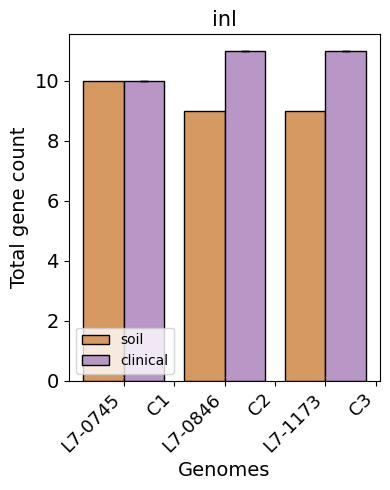

In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Sort the DataFrame based on the 'related_strain' column
df_inl_sorted = df_inl.sort_values(by='related_strain')

# Group the sorted DataFrame by the 'related_strain' column
groups_related_strain = df_inl_sorted.groupby('related_strain')

# Initialize lists to store data for plotting
x_values = []
y_values = []
errors = []
sources = []
p_values = []  # Store p-values for each Related Strain

# Iterate over each group based on 'related_strain'
for strain, strain_data in groups_related_strain:
    # Group the data within the current 'related_strain' group by 'source'
    source_groups = strain_data.groupby('source')
    
    # Iterate over each source group within the current 'related_strain' group
    for source, source_group_data in source_groups:
        # Extract sum values for the current source group
        inl_sum_values = source_group_data['inl_sum']
        
        # Append data for plotting
        x_values.append(strain)
        y_values.append(inl_sum_values.mean())
        errors.append(inl_sum_values.std())
        sources.append(source)
        
        # Perform Mann-Whitney U test and store p-value
        soil_inl_sum_values = source_groups.get_group('soil')['inl_sum'].values
        inl_sum_values = source_group_data['inl_sum'].values
        try:
            _, p_value = stats.mannwhitneyu(inl_sum_values, soil_inl_sum_values, alternative='two-sided')
            p_values.append(p_value)
        except ValueError:
            p_values.append(np.nan)

# Create a DataFrame for plotting
plot_df = pd.DataFrame({'Related Strain': x_values, 'Source': sources, 'inl_sum': y_values, 'error': errors, 'p_value': p_values})

# Replace NaN values in 'error' column with zeros
plot_df['error'].fillna(0, inplace=True)

# Fill 'p_value' column with the same value for rows with the same 'Related Strain'
plot_df['p_value'] = plot_df.groupby('Related Strain')['p_value'].transform('first')

# Define the desired order for 'Related Strain' column
desired_order = ['L7-0745', 'L7-0846', 'L7-1173']

# Convert 'Related Strain' column to categorical data with desired order
plot_df['Related Strain'] = pd.Categorical(plot_df['Related Strain'], categories=desired_order, ordered=True)

# Define the order of hue levels
hue_order = ['soil', 'clinical']

# Plot the barplot without error bars
plt.figure(figsize=(4, 5))
sns.barplot(x='Related Strain', y='inl_sum', hue='Source', hue_order=hue_order, data=plot_df, ci=None, palette=["#EB984E", "#BB8FCE"], edgecolor="black")

# Calculate error bars for 'clinical' source
clinical_errors = plot_df[plot_df['Source'] == 'clinical']['error']

# Define the offset for moving the error bars to the right
error_bar_offset = 0.2  # Adjust as needed

# Plot the error bars for 'clinical' bars
for i, strain in enumerate(desired_order):
    clinical_data = plot_df[(plot_df['Related Strain'] == strain) & (plot_df['Source'] == 'clinical')]
    plt.errorbar(i + error_bar_offset, clinical_data['inl_sum'].values[0], yerr=clinical_data['error'].values[0], fmt='none', color='black', capsize=3)

# Set custom x-tick labels
tick_labels = ['L7-0745', 'C1', 'L7-0846', 'C2', 'L7-1173', 'C3']
tick_positions = np.arange(len(tick_labels)) / 2

# Set x-ticks and labels
plt.xticks(ticks=tick_positions, labels=tick_labels, fontsize=13, rotation=45, ha="right")

# Set labels and title
plt.title('inl', size=15)
plt.xlabel('Genomes', size=14)
plt.ylabel('Total gene count', size=14)

# Show plot
legend = plt.legend(title=None) 
plt.xticks(fontsize=13, rotation=45, ha="right")
plt.tight_layout()
plt.savefig(out_path_supp + "fig_sXX_inl.pdf", dpi=300)
plt.show()

In [195]:
# Comparing ARGs between LM lineages of environmental and clinical origin 
df4_s_c_phylo = pd.read_csv(data_path_lm + "arg_merged.csv")

In [196]:
arg = ['fosX', 'lin', 'mprF', 'norB', 'sul']
df4_s_c_phylo = df4_s_c_phylo[df4_s_c_phylo['id'].isin(id_L7_0745 + id_L7_0846 + id_L7_1173)]

df4_s_c_phylo.loc[df4_s_c_phylo['id'].isin(id_L7_0745), 'related_strain'] = 'L7-0745'
df4_s_c_phylo.loc[df4_s_c_phylo['id'].isin(id_L7_0846), 'related_strain'] = 'L7-0846'
df4_s_c_phylo.loc[df4_s_c_phylo['id'].isin(id_L7_1173), 'related_strain'] = 'L7-1173'

df4_s_c_phylo.loc[:, 'arg_sum'] = df4_s_c_phylo[arg].sum(axis=1)

# Print the resulting DataFrame
df4_s_c_phylo = df4_s_c_phylo.sort_values(by='related_strain', ascending=True)
#df4_s_c_phylo

In [197]:

# Choose a specific 'related_strain' group to compare
selected_strain = 'L7-1173'

# Filter the DataFrame for the selected 'related_strain'
selected_group = df4_s_c_phylo[df4_s_c_phylo['related_strain'] == selected_strain]

# Group by 'source' within the selected 'related_strain'
source_groups = selected_group.groupby('source')

# Extract 'arg_sum' values for 'soil' and 'clinical' sources
soil_values = source_groups.get_group('soil')['arg_sum'].values
clinical_values = source_groups.get_group('clinical')['arg_sum'].values

# Check if all values are identical in either 'soil' or 'clinical' group
if len(set(soil_values)) == 1 and len(set(clinical_values)) == 1:
    print("All values are identical in either 'soil' or 'clinical'. Cannot perform the test.")
else:
    try:
        # Perform Wilcoxon Rank-Sum Test (two-sided) comparing 'clinical' to 'soil'
        _, p_value = stats.ranksums(clinical_values, soil_values, alternative='two-sided')

        # Print the results
        print(f"For Related Strain '{selected_strain}':")
        print(f"Wilcoxon rank-sum test p-value: {p_value}")

        # Print decision based on significance level (e.g., alpha = 0.05)
        alpha = 0.05
        if p_value < alpha:
            print("There is a statistically significant difference between 'clinical' and 'soil'.")
        else:
            print("There is no statistically significant difference between 'clinical' and 'soil'.")
        
    except ValueError:
        print("An error occurred while performing the Wilcoxon rank-sum test.")

For Related Strain 'L7-1173':
Wilcoxon rank-sum test p-value: 0.10374167823654154
There is no statistically significant difference between 'clinical' and 'soil'.


/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


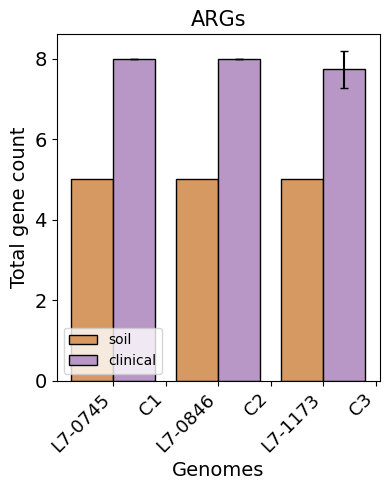

In [198]:
# Sort the DataFrame based on the 'related_strain' column
df4_s_c_phylo_sorted = df4_s_c_phylo.sort_values(by='related_strain')

# Group the sorted DataFrame by the 'related_strain' column
groups_related_strain = df4_s_c_phylo_sorted.groupby('related_strain')

# Initialize lists to store data for plotting
x_values = []
y_values = []
errors = []
sources = []
p_values = []  # Store p-values for each Related Strain

# Iterate over each group based on 'related_strain'
for strain, strain_data in groups_related_strain:
    # Group the data within the current 'related_strain' group by 'source'
    source_groups = strain_data.groupby('source')
    
    # Iterate over each source group within the current 'related_strain' group
    for source, source_group_data in source_groups:
        # Extract sum values for the current source group
        arg_sum_values = source_group_data['arg_sum']
        
        # Append data for plotting
        x_values.append(strain)
        y_values.append(arg_sum_values.mean())
        errors.append(arg_sum_values.std())
        sources.append(source)
        
        # Perform Wilcoxon rank-sum test and store p-value
        soil_arg_sum_values = source_groups.get_group('soil')['arg_sum'].values
        arg_sum_values = source_group_data['arg_sum'].values
        try:
            _, p_value = wilcoxon(arg_sum_values, soil_arg_sum_values, alternative='two-sided')
            p_values.append(p_value)
        except ValueError:
            p_values.append(np.nan)

# Create a DataFrame for plotting
plot_df = pd.DataFrame({'Related Strain': x_values, 'Source': sources, 'arg_sum': y_values, 'error': errors, 'p_value': p_values})

# Replace NaN values in 'error' column with zeros
plot_df['error'].fillna(0, inplace=True)

# Fill 'p_value' column with the same value for rows with the same 'Related Strain'
plot_df['p_value'] = plot_df.groupby('Related Strain')['p_value'].transform('first')

# Define the desired order for 'Related Strain' column
desired_order = ['L7-0745', 'L7-0846', 'L7-1173']

# Convert 'Related Strain' column to categorical data with desired order
plot_df['Related Strain'] = pd.Categorical(plot_df['Related Strain'], categories=desired_order, ordered=True)

# Define the order of hue levels
hue_order = ['soil', 'clinical']

# Plot the barplot without error bars
plt.figure(figsize=(4, 5))
sns.barplot(x='Related Strain', y='arg_sum', hue='Source', hue_order=hue_order, data=plot_df, ci=None, palette=["#EB984E", "#BB8FCE"], edgecolor="black")

# Calculate error bars for 'clinical' source
clinical_errors = plot_df[plot_df['Source'] == 'clinical']['error']

# Define the offset for moving the error bars to the right
error_bar_offset = 0.2  # Adjust as needed

# Plot the error bars for 'clinical' bars
for i, strain in enumerate(desired_order):
    clinical_data = plot_df[(plot_df['Related Strain'] == strain) & (plot_df['Source'] == 'clinical')]
    plt.errorbar(i + error_bar_offset, clinical_data['arg_sum'].values[0], yerr=clinical_data['error'].values[0], fmt='none', color='black', capsize=3)

# Set custom x-tick labels
tick_labels = ['L7-0745', 'C1', 'L7-0846', 'C2', 'L7-1173', 'C3']
tick_positions = np.arange(len(tick_labels)) / 2

# Set x-ticks and labels
plt.xticks(ticks=tick_positions, labels=tick_labels, fontsize=13, rotation=45, ha="right")

# Set labels and title
plt.title('ARGs', size=15)
plt.xlabel('Genomes', size=14)
plt.ylabel('Total gene count', size=14)

# Show plot
legend = plt.legend(title=None) 
plt.xticks(fontsize=13, rotation=45, ha="right")
plt.tight_layout()
plt.savefig(out_path_supp + "fig_sXX_arg_genes_comparison.pdf", dpi=300)
plt.show()